# [Maureen] Inftrain ABX Analysis

## Includes bilingual data

In [1]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import seaborn as sns

#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower

sns.set_theme()

HOME="/linkhome/rech/genini01/ucv88ce/"
models_path=os.path.join(HOME,"projects/MultilingualCPC/experiments/checkpoints/inftrain" )
eval_path=""

* Functions definition

In [2]:
def retrieve_scores( size= [50,100, 200, 400, 800], abx_type="both", easyfilter = False, models_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/checkpoints/inftrain'):
    fam_dict={}

    #columns = fam_id 	size 	eval_lang 	en_model 	fr_model 	bil_totalsize_A 	bil_totalsize_B 	same 	different 	bil_langsize 	bil_totalsize 	mono_avg (same and diff are just the scores from tje model corresponding to th train and eval)
    #do average of within and across
    langs=["EN","FR","EN+FR"]
    #langs=["EN","FR","EN+FR.bk"]

    for s in sorted(size):
        s=int(s)
        for fam in ["{}".format(str(x).zfill(2)) for x in range(int(32/s*100))] :

            for eval_lang in ['english','french']:
                k = fam+"_"+eval_lang+"_"+str(s)

                values = [fam, int(s), eval_lang]

                for model in langs:
                    
                    if model == "EN" or model == "FR" :
                        
                        path = os.path.join(models_path,model,str(s)+"h",fam,"cpc_small/ABX","**",eval_lang, "ABX_scores.json")
                        json_f = glob(path, recursive=True)
                        if easyfilter : 
                            json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                        else:
                            json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                        
                        if len(json_f) > 1:
                            json_f = [max(json_f, key=os.path.getctime)]

                        if not json_f :
                            score = np.nan
                        else:
                            with open(json_f[0], "r") as f:

                                scores = json.load(f)
                            if abx_type == "both" :
                                score = np.mean([scores['within'],scores['across']]) * 100
                            else :
                                score = scores[abx_type]*100
                        values.append(score)

                    elif model == "EN+FR" :
                        bil_scores = []
                        for bil_fam in [str(int(fam)*2).zfill(2), str((int(fam)*2) + 1).zfill(2)] :
                            path = os.path.join(models_path,model,str(s)+"h",bil_fam,"cpc_small/ABX","**",eval_lang, "ABX_scores.json")
                            json_f = glob(path, recursive=True)
                            
                            
                            if easyfilter : 
                                json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                            else:
                                json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                                                        
                            if len(json_f) > 1:
                                
                                json_f = [max(json_f, key=os.path.getctime)]

                            if not json_f :
                                score = np.nan
                            else:
                                with open(json_f[0], "r") as f:
                                    scores = json.load(f)
                                if abx_type == "both" :
                                    score = np.mean([scores['within'],scores['across']]) * 100
                                else :
                                    score = scores[abx_type]*100 
                                    
                            values.append(score)
                            
                            #below add langsize
                            if fam+"_"+eval_lang+"_"+str(int(s/2)) in fam_dict :
                                fam_dict[bil_fam+"_"+eval_lang+"_"+str(int(s/2))][-1] = score


                        
                    if model == "EN" and eval_lang == "english" :
                        same = score
                    elif model == "EN" and eval_lang == "french" :
                        different = score
                    elif model == "FR" and eval_lang == "french" :
                        same = score
                    elif model == "FR" and eval_lang == "english" :
                        different = score

                values.append(same)
                values.append(different)
                values.append(np.nan) #eate space for the "bil_add"
                fam_dict[k] = values
                


    

    df = pd.DataFrame.from_dict(fam_dict, orient='index', columns=["fam_id", "size", "eval_lang", "en_model", "fr_model", "bil_totalsize_A", "bil_totalsize_B", 'same', 'different', "bil_langsize"])
    df['bil_totalsize'] = df[["bil_totalsize_A", "bil_totalsize_B"]].mean(axis=1)
    df["mono_avg"] = df[["en_model", "fr_model"]].mean(axis=1)
    return df

## Retrieve ABX scores & datasets

*MDS - Todo : add lambda function to systematically retrieve latest checkpoint ABX score*

1. df_within : original ABX scores calculated "within speaker"
2. df_across : original ABX scores calculated "across speakers"
3. df_ef_within : "easyfilter" ABX scores calculated "within speaker"
4. df_ef_across : "easyfilter" ABX scores calculated "across speakers"


The "easyfilter" abx scores correspond, for the french scores, to the scores calculated on the "quickfix" item files (see [Google Document](https://docs.google.com/document/d/1XoGX52rBFOwue2twX02IuEhO_-ZktSZh-qdvpuBqK3I/edit?usp=sharing)). The english scores are the same as the original ones. 

In [4]:
abx_type="both"
abx_type="within"


df_within = retrieve_scores(abx_type="within")
df_within_size = df_within.groupby(by="size").mean()

df_across = retrieve_scores(abx_type="across")
df_across_size = df_across.groupby(by="size").mean()

#easy filter
ef_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/eval/inftrain'
df_ef_within = retrieve_scores(abx_type="within", easyfilter=True, models_path=ef_path)
df_ef_within_size = df_ef_within.groupby(by="size").mean()

df_ef_across = retrieve_scores(abx_type="across", easyfilter=True, models_path=ef_path)
df_ef_across_size = df_ef_across.groupby(by="size").mean()


#### Concatenate original and easyfilter datasets to allow comparison 

In [5]:
df_ef_within["zerospeech"] = "easyfilter"
df_within["zerospeech"] = "original"
large_df_within = df_within.append(df_ef_within)

df_ef_across["zerospeech"] = "easyfilter"
df_across["zerospeech"] = "original"
large_df_across = df_across.append(df_ef_across)

# Figures

## A. Boxplots of ABX scores in function of training size for the different model types

### A1 - ABX across speakers - original
- Test set : average of French and English
- Df : Original

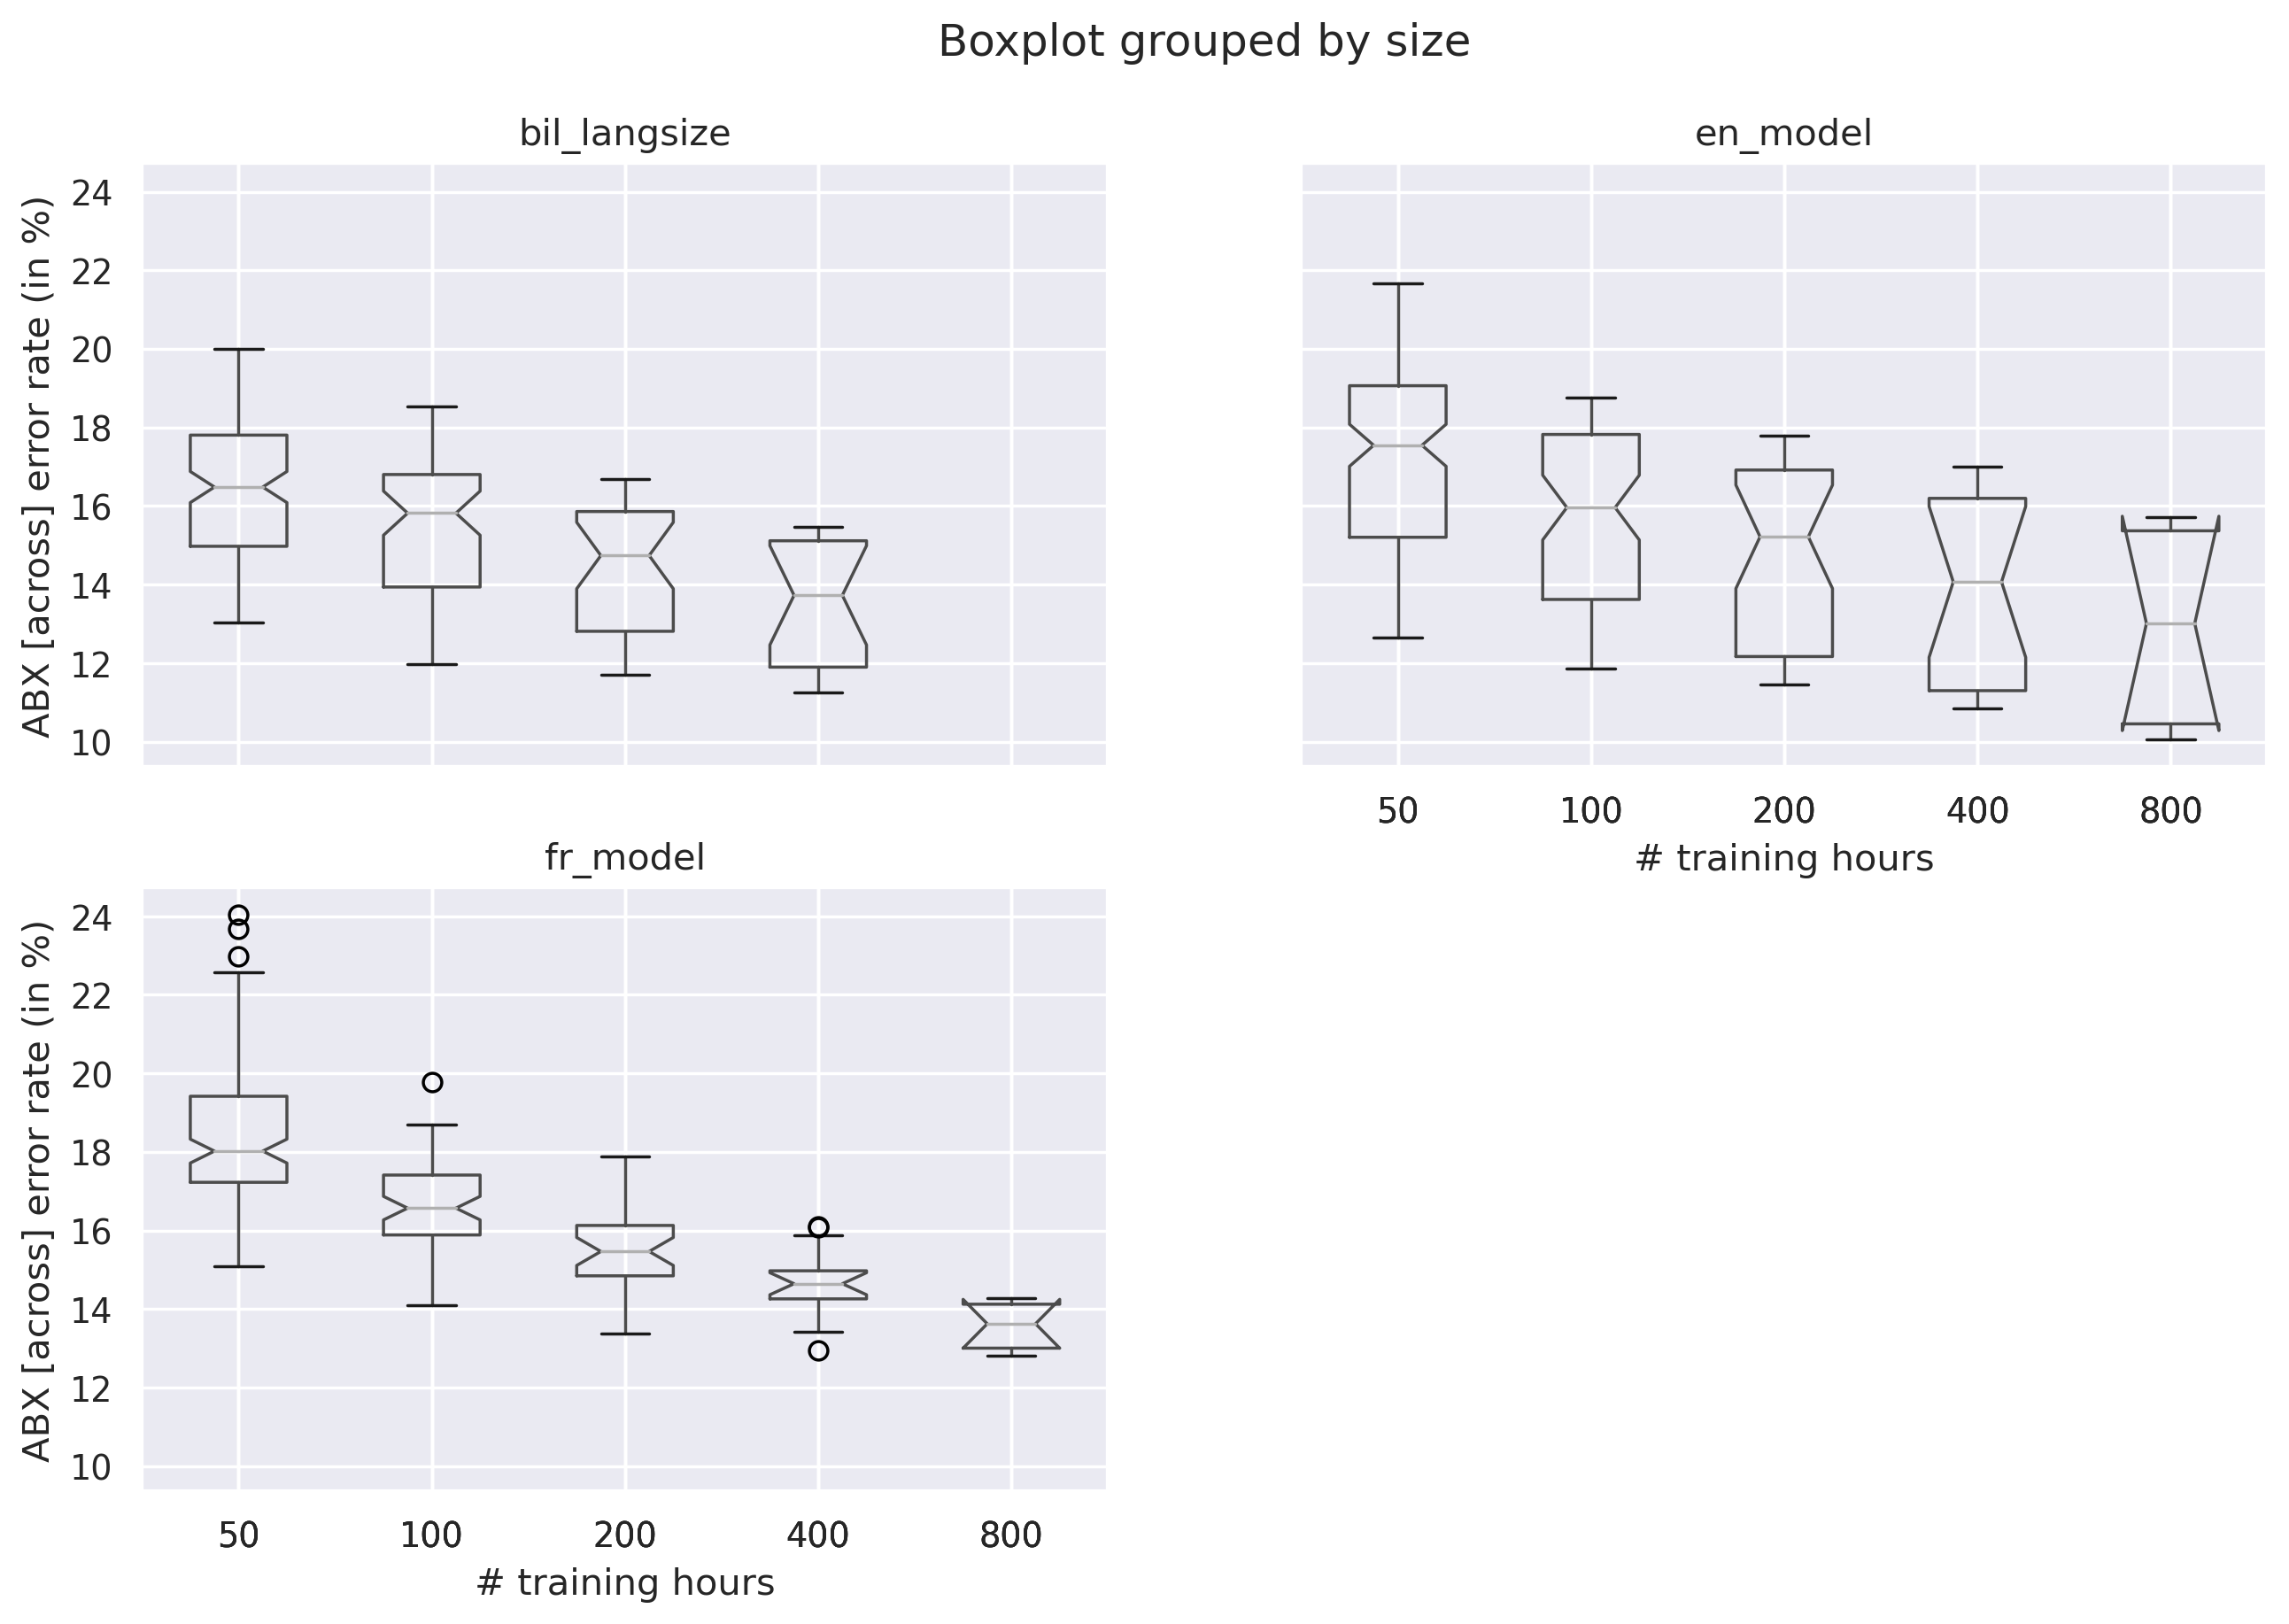

In [7]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [across] error rate (in %)')
    bp.set_xlabel('# training hours')


### A2 - ABX within speakers  - original
- Test set : average of French and English
- Df : Original

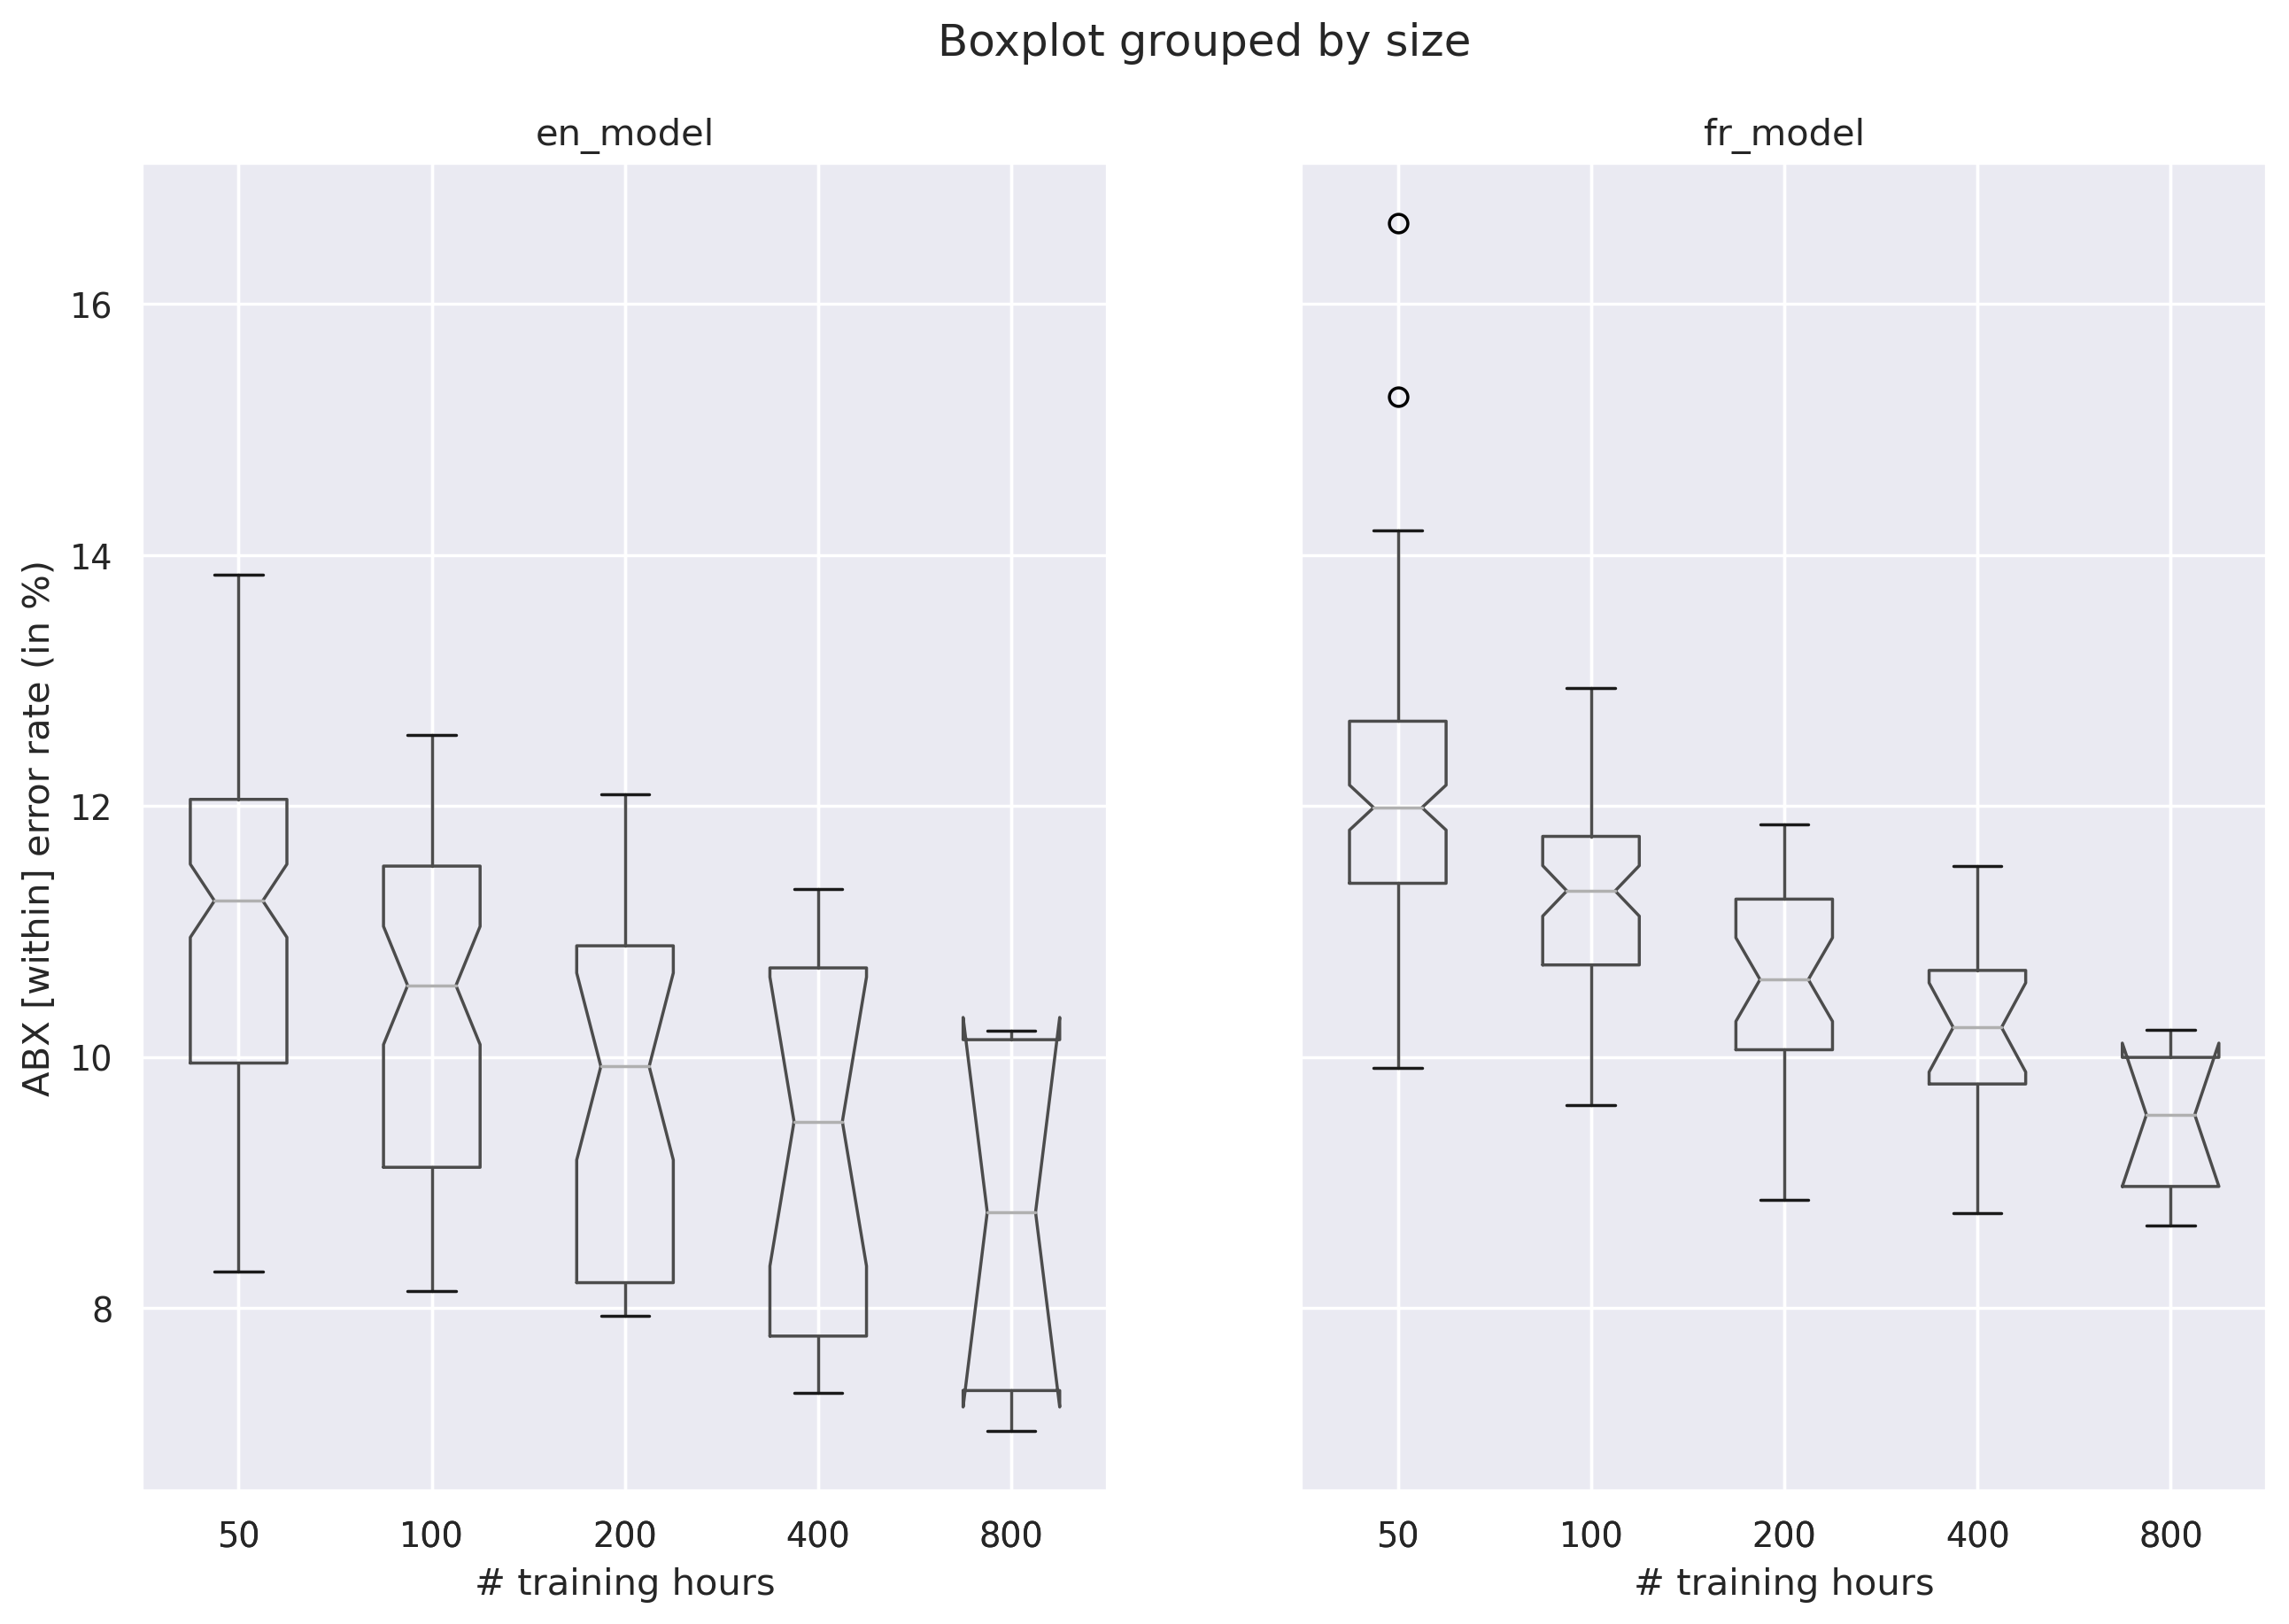

In [8]:
boxplot = df_within[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
#boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [within] error rate (in %)')
    bp.set_xlabel('# training hours')


### A3 - ABX within speakers - QuickFix French
- Test set : average of French and English
- Df : QuickFix

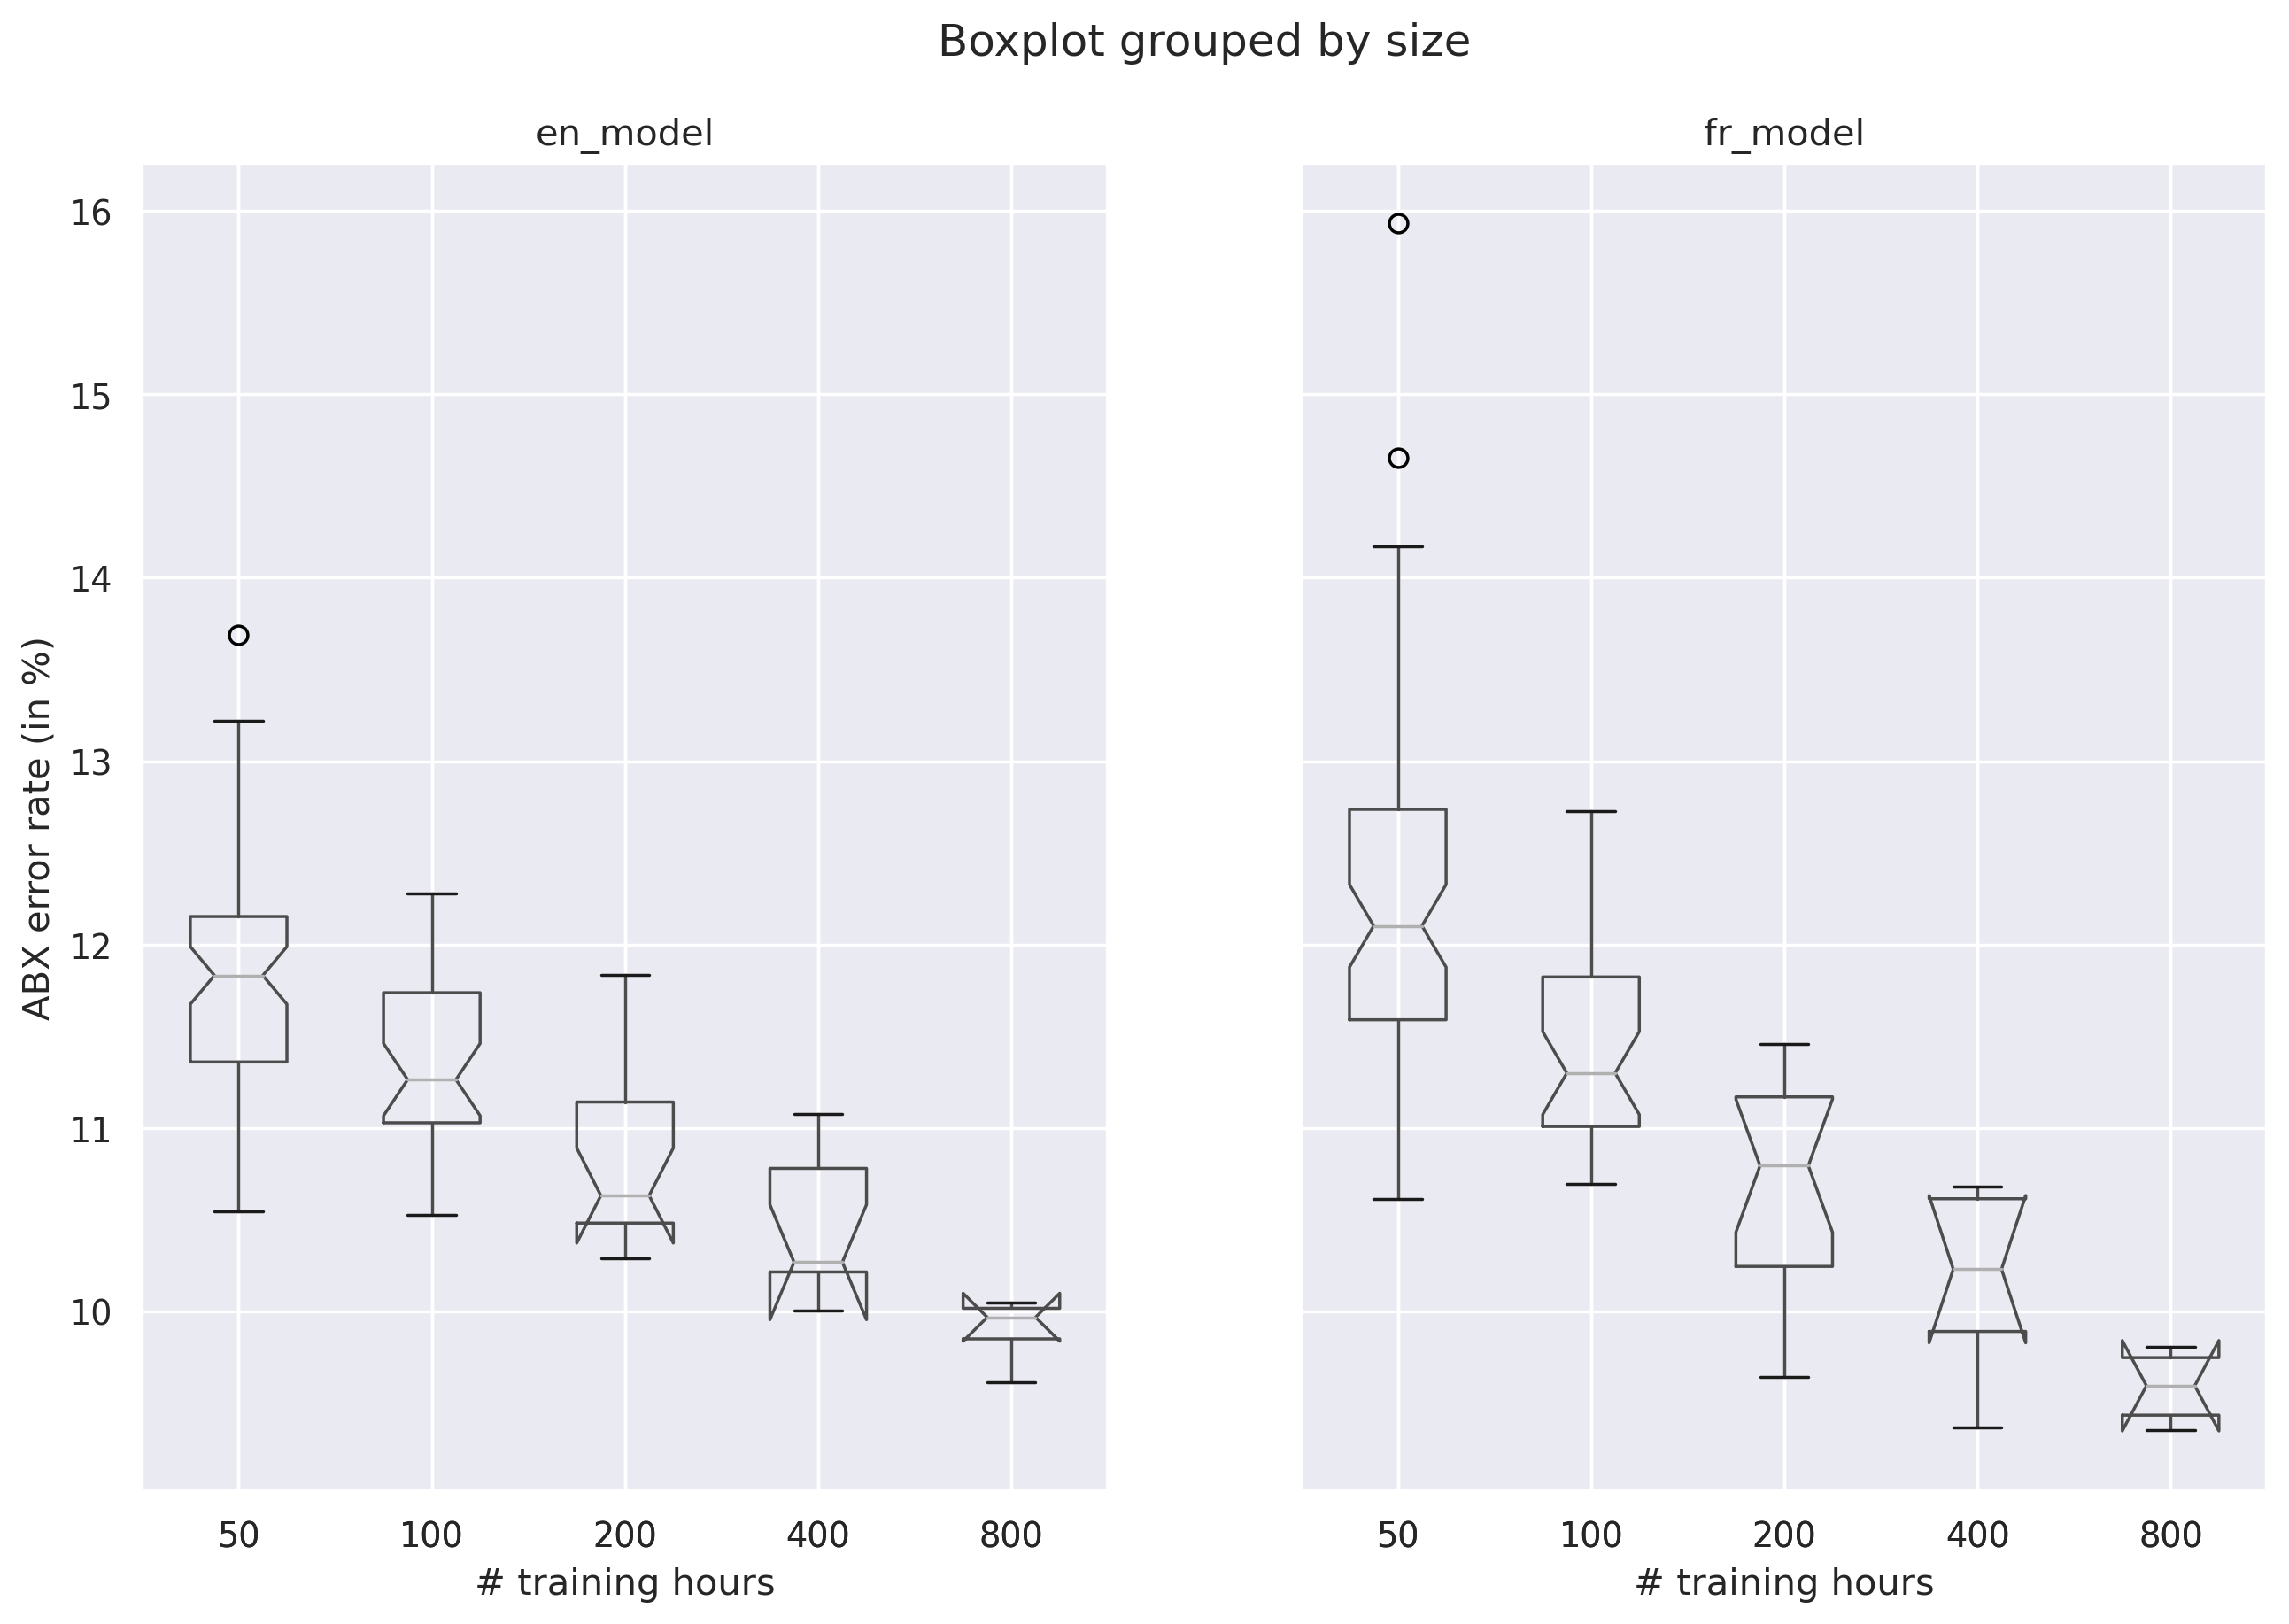

In [10]:
boxplot = df_ef_within[['size','en_model', 'fr_model',   'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
#boxplot = df_ef_within[['size','en_model', 'fr_model', 'bil_langsize',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX error rate (in %)')
    bp.set_xlabel('# training hours')


## B. Comparing ABX scores per model type depending on test set (original vs QuickFix)

This is done on the **French** evaluation set

### B1. Scores overall (abx within)


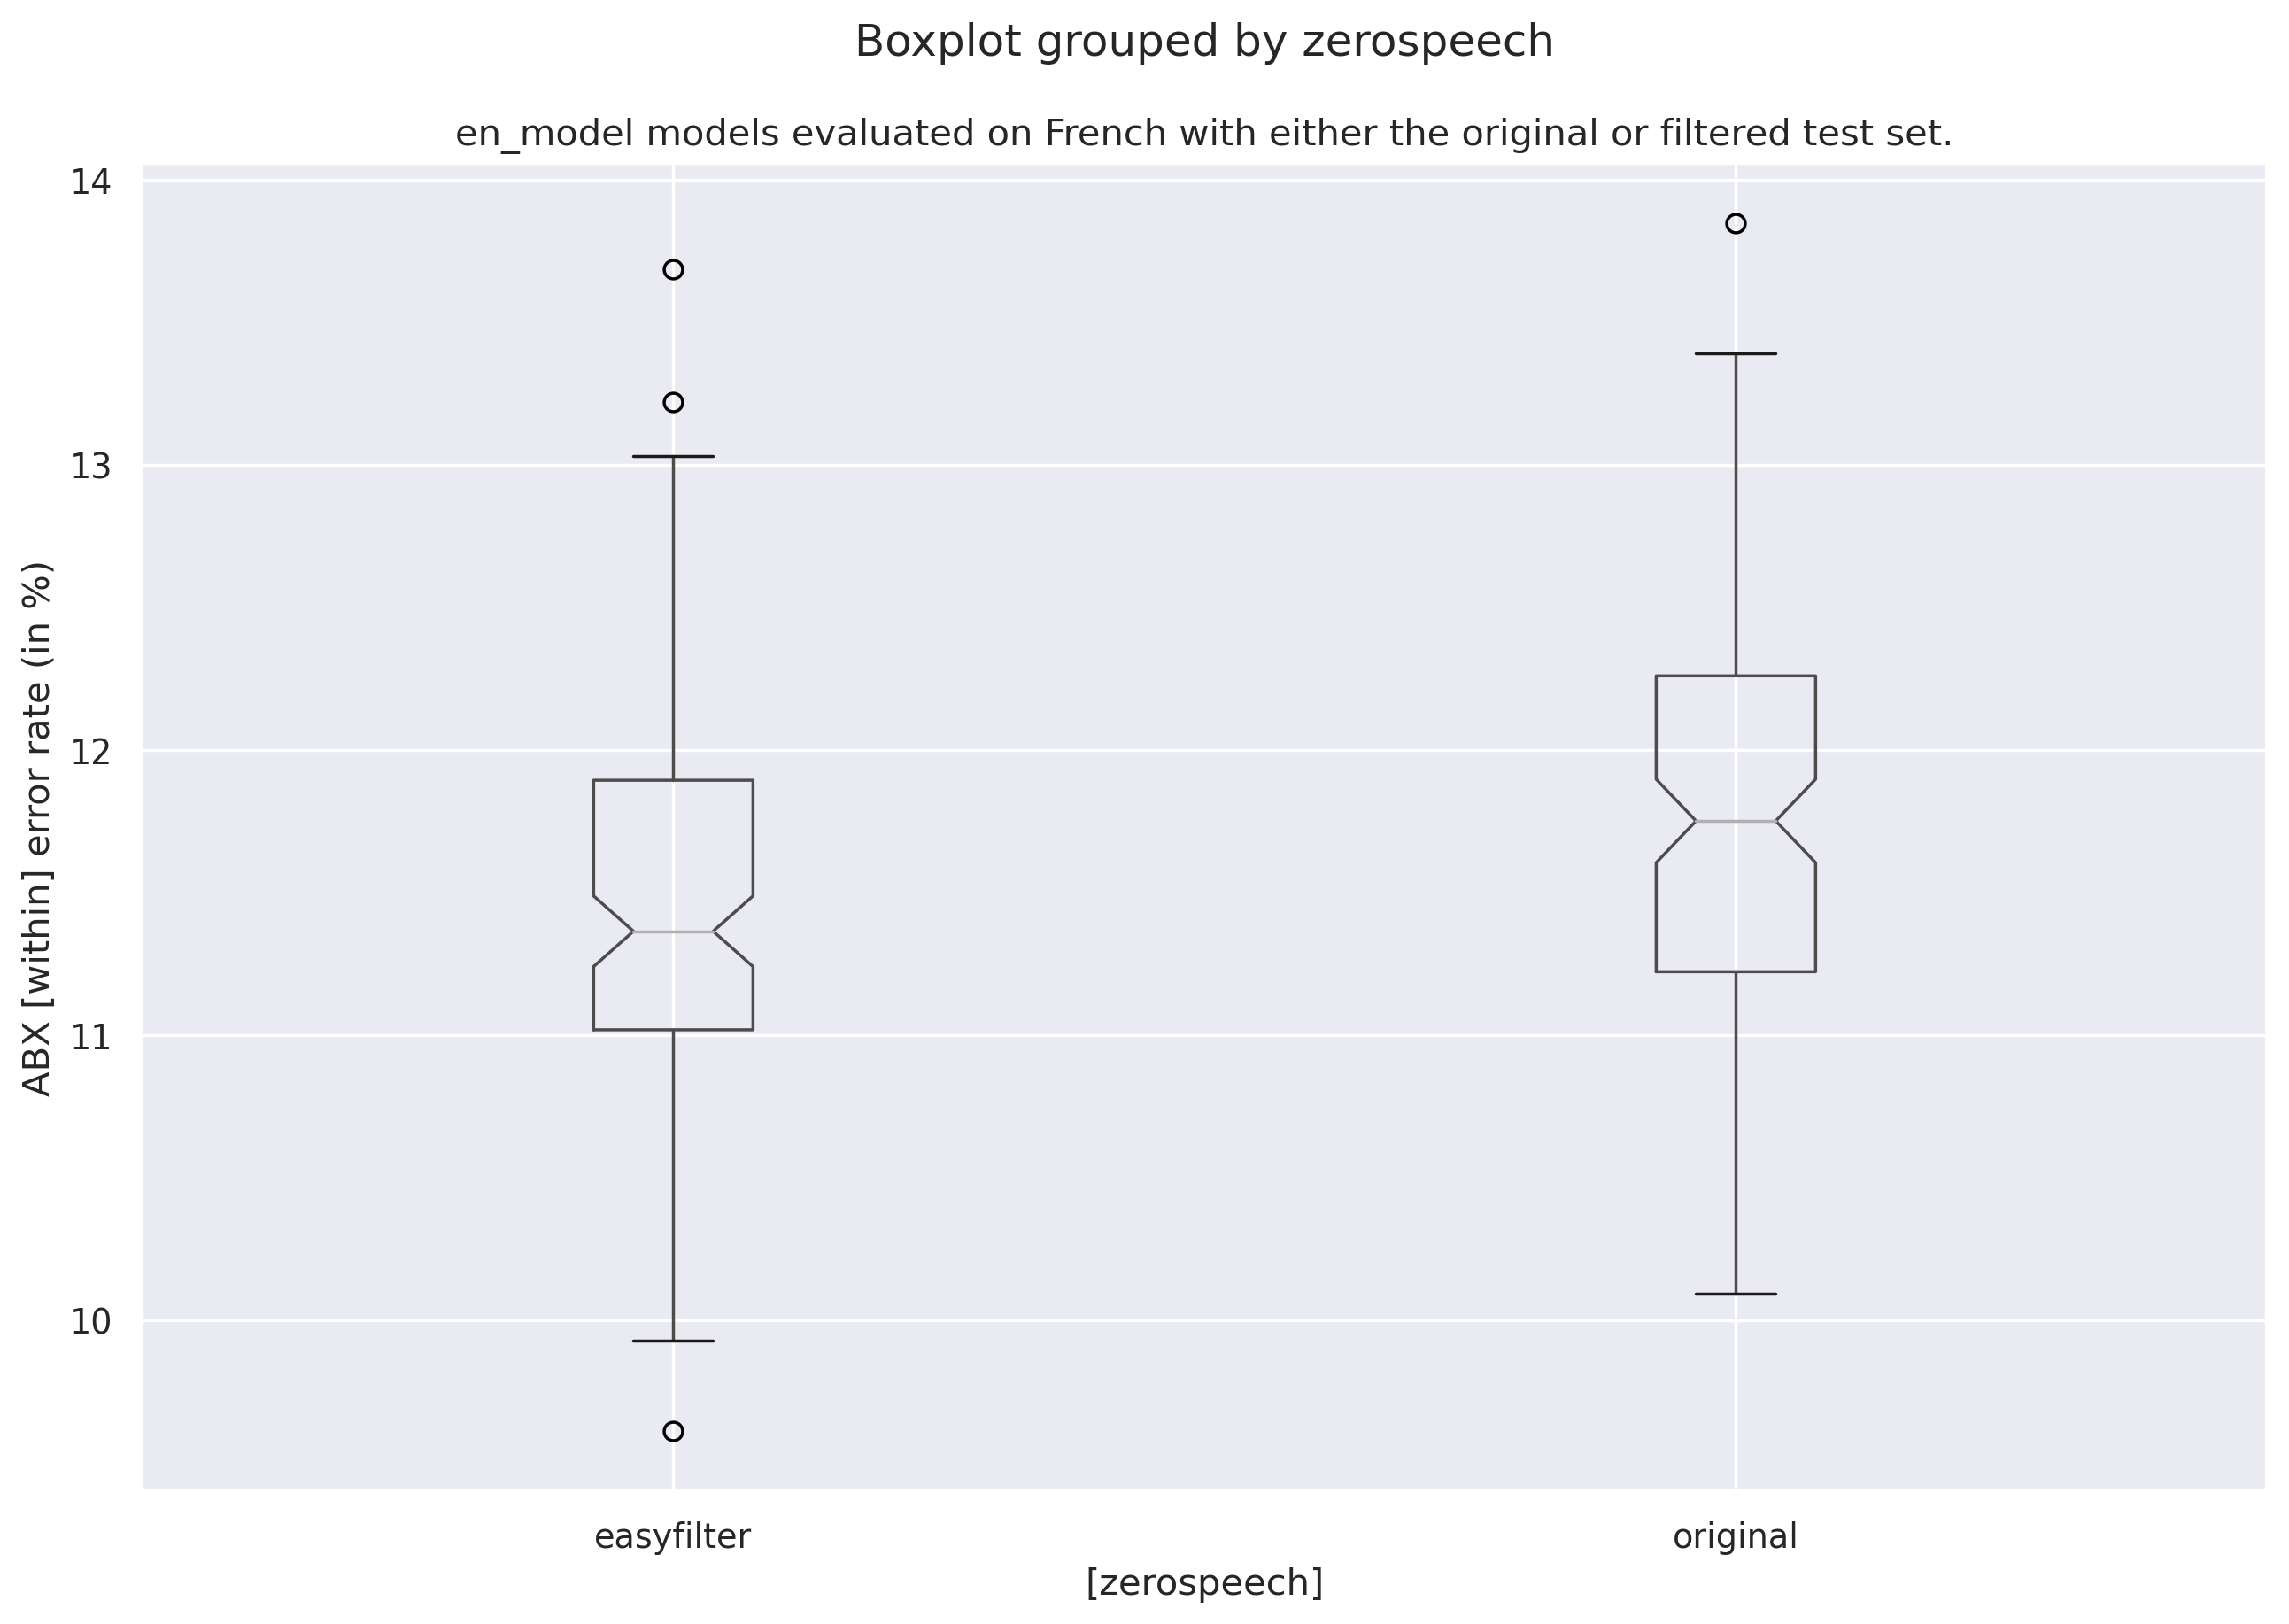

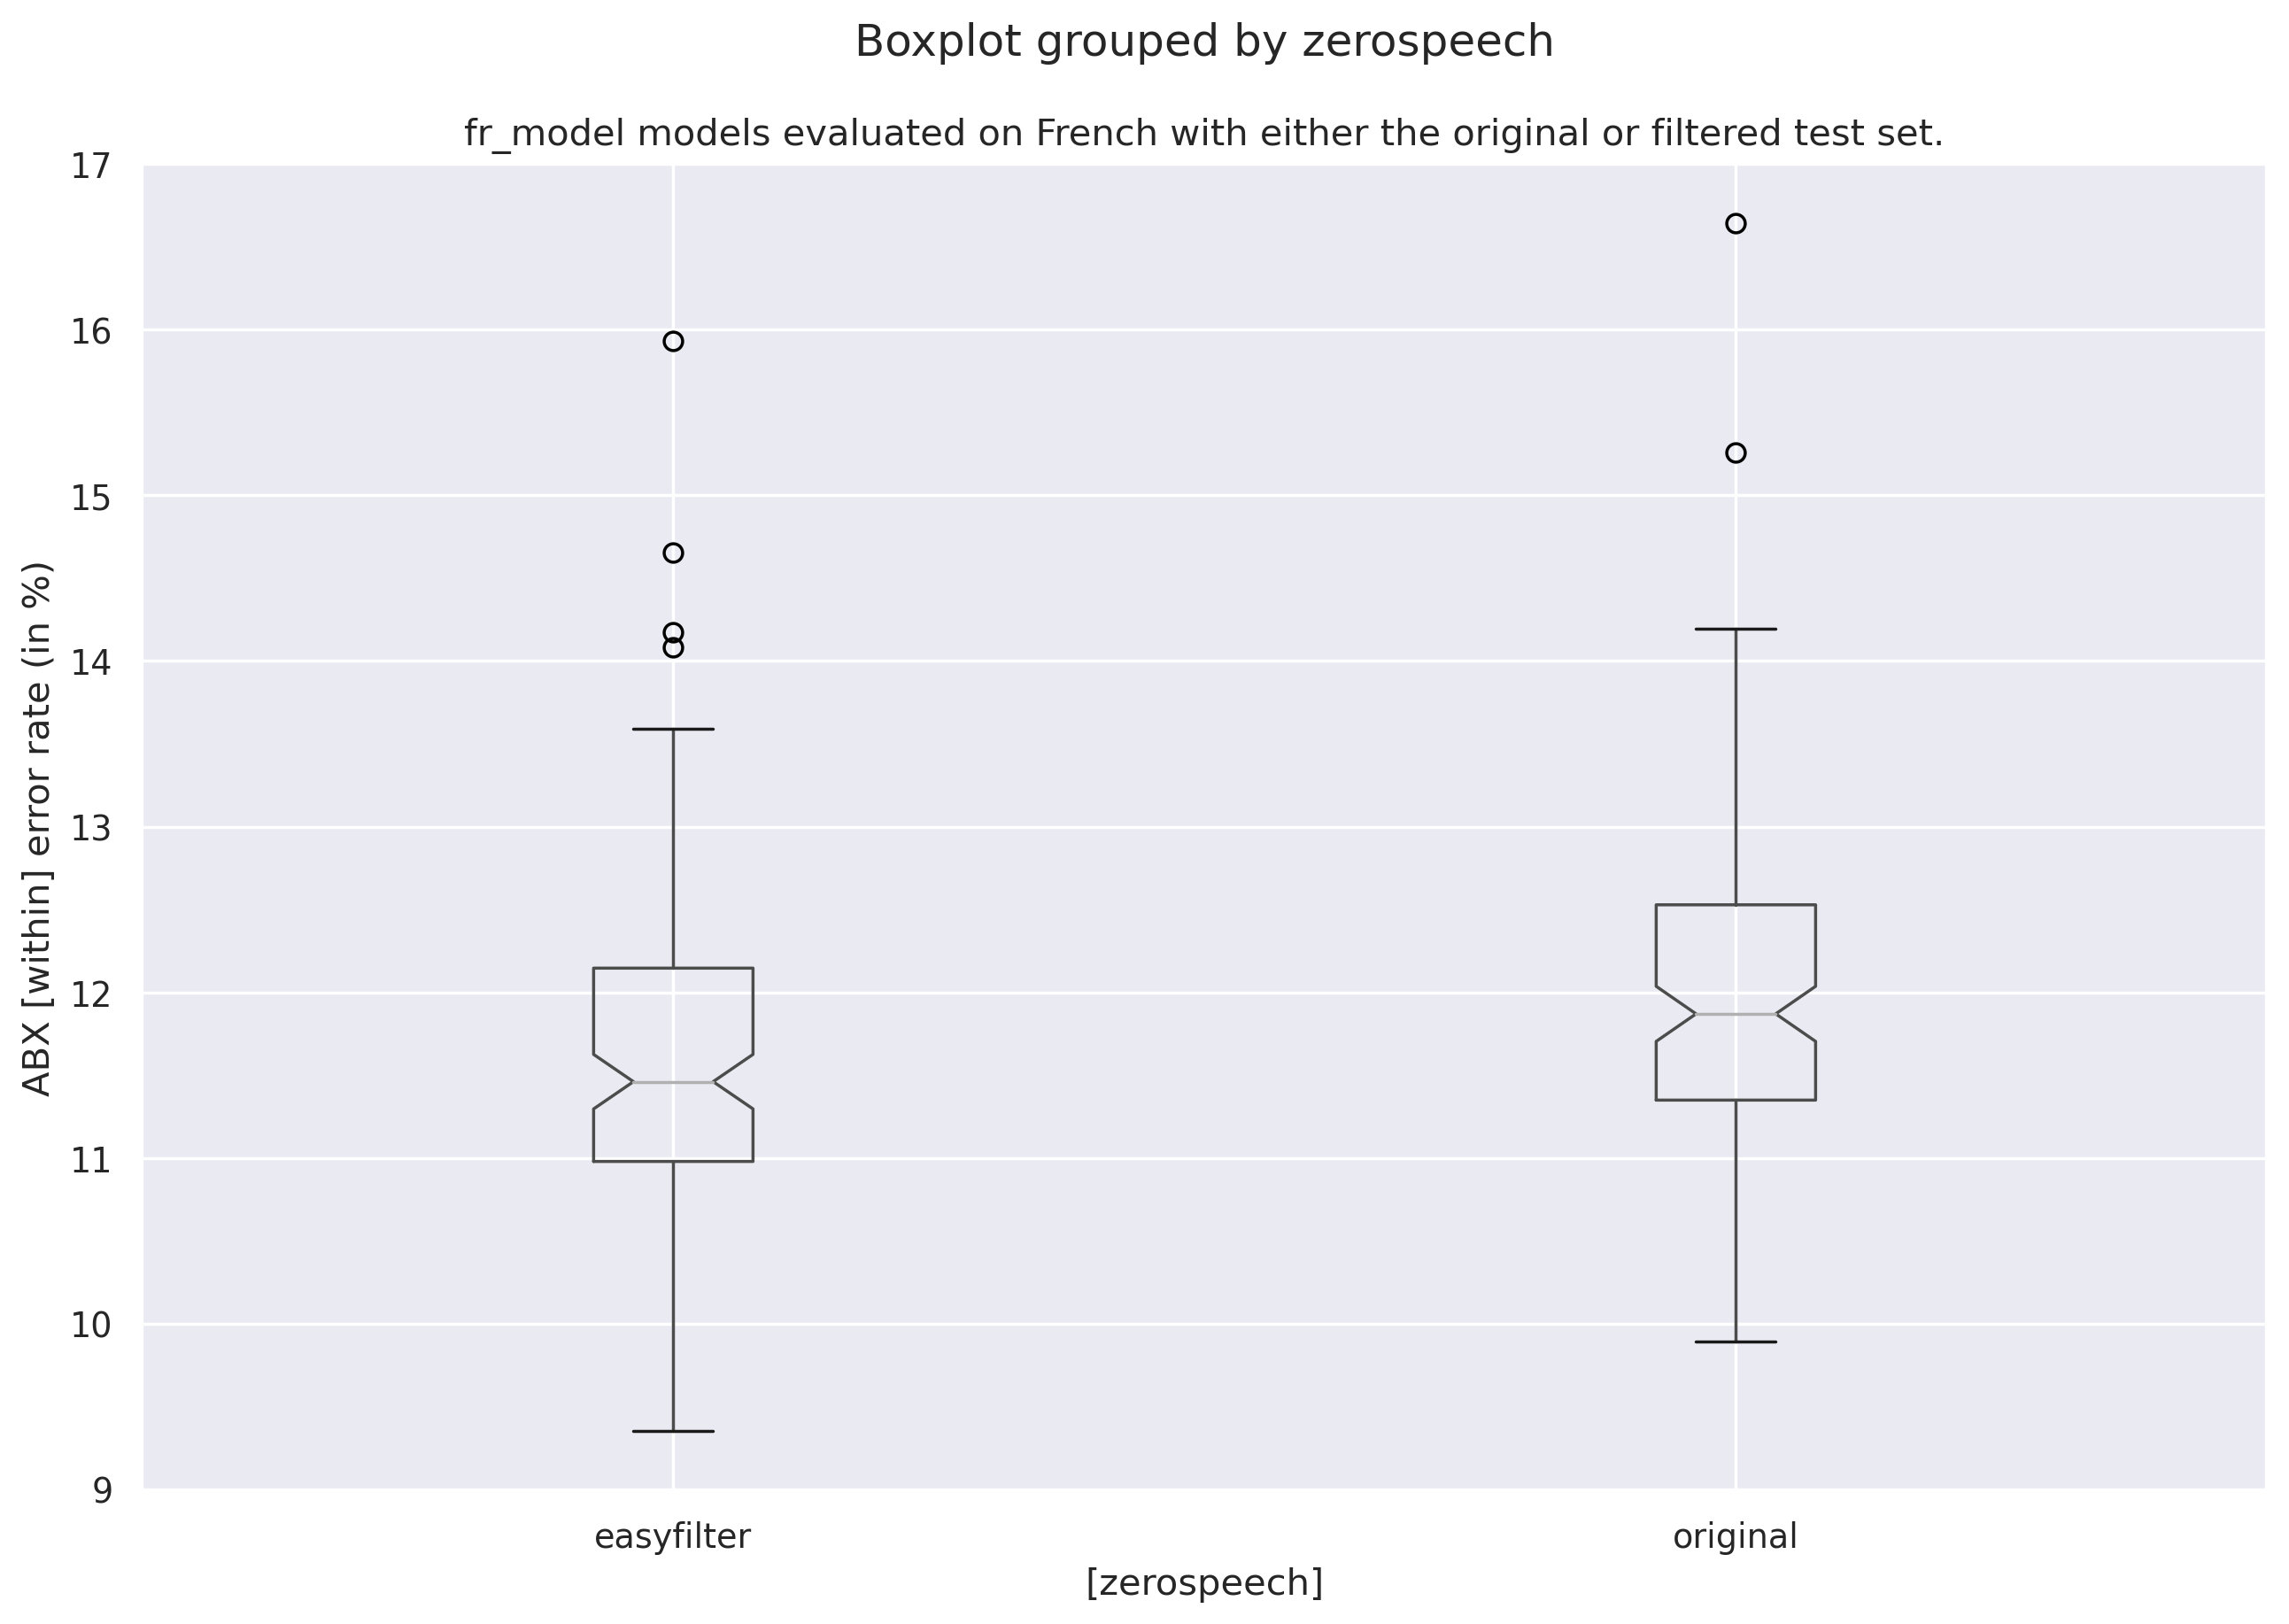

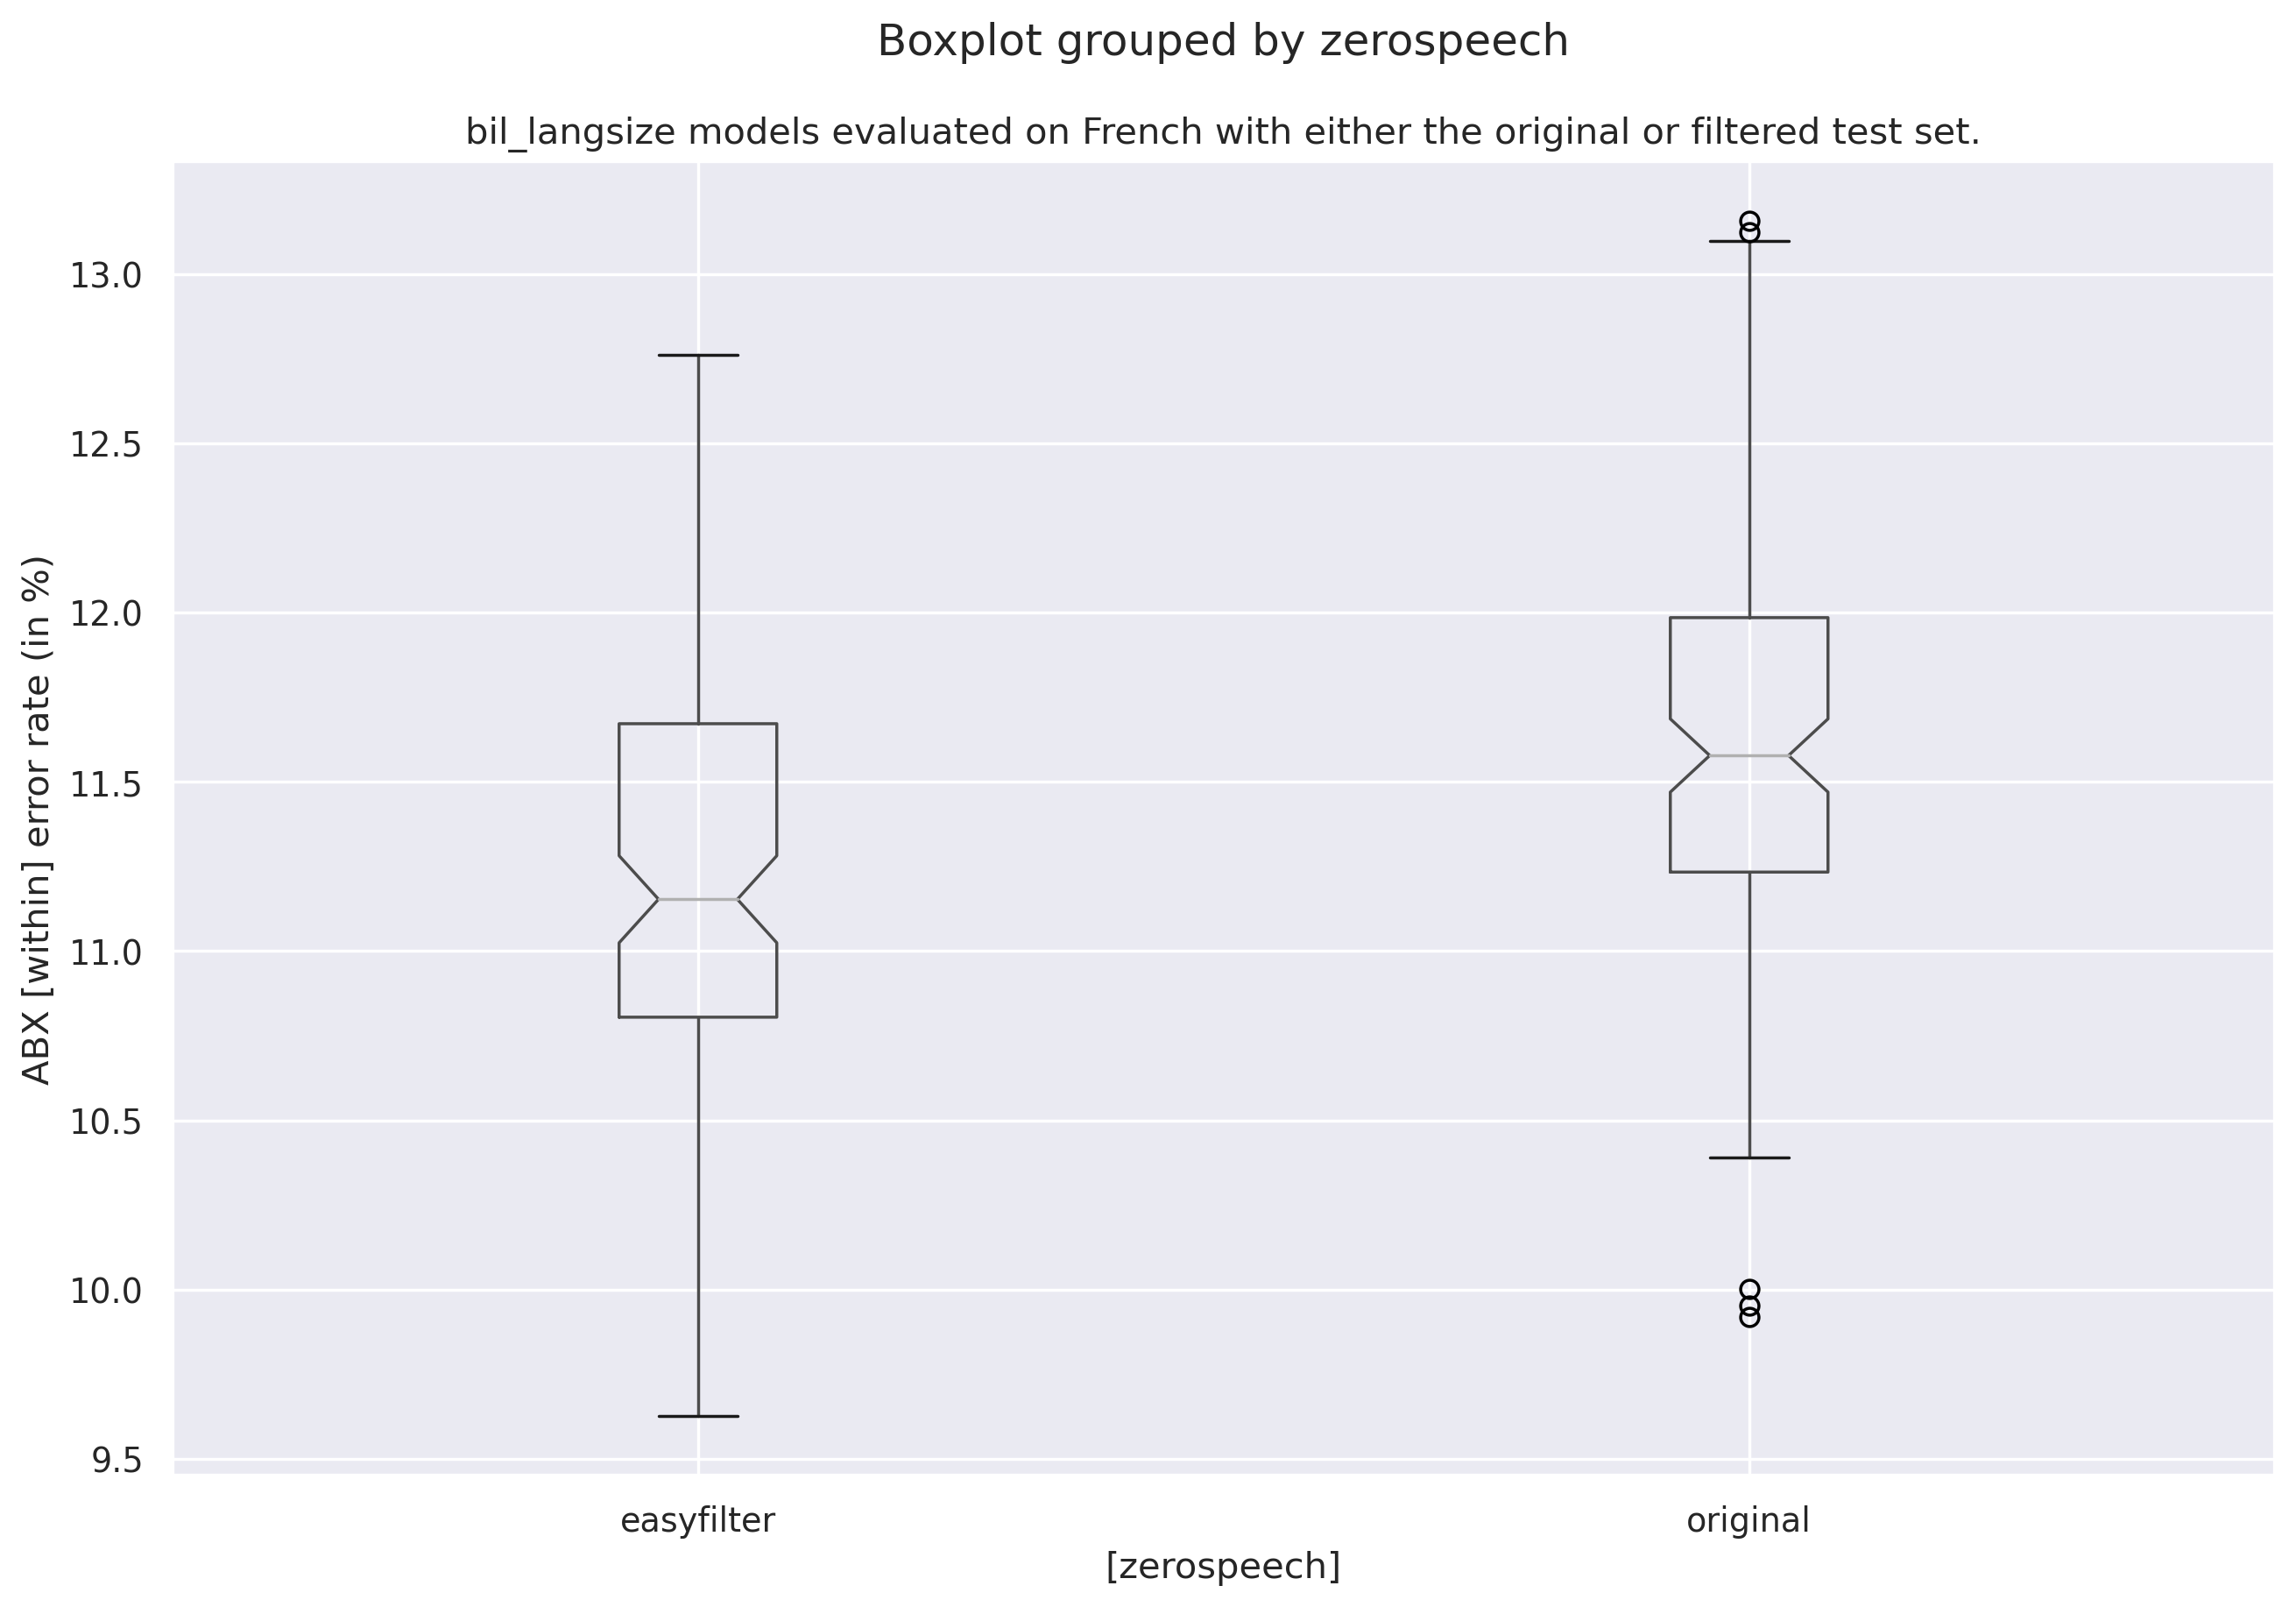

In [14]:

tmp_df = large_df_within[large_df_within['eval_lang'] == "french"]


for mtype in 'en_model', 'fr_model', 'bil_langsize':
    boxplot = tmp_df[['size','en_model', 'fr_model', 'bil_langsize',  'eval_lang', 'zerospeech']].boxplot(notch=True,column=mtype, by=[  'zerospeech'], return_type='axes')
    plt.title("{} models evaluated on French with either the original or filtered test set.".format(mtype))
    plt.ylabel('ABX [within] error rate (in %)')
#for bp in boxplot: 
#    bp.set_ylabel('ABX error rate (in %)')
#    bp.set_xlabel('# training hours')


### B2. Scores overall (abx across)


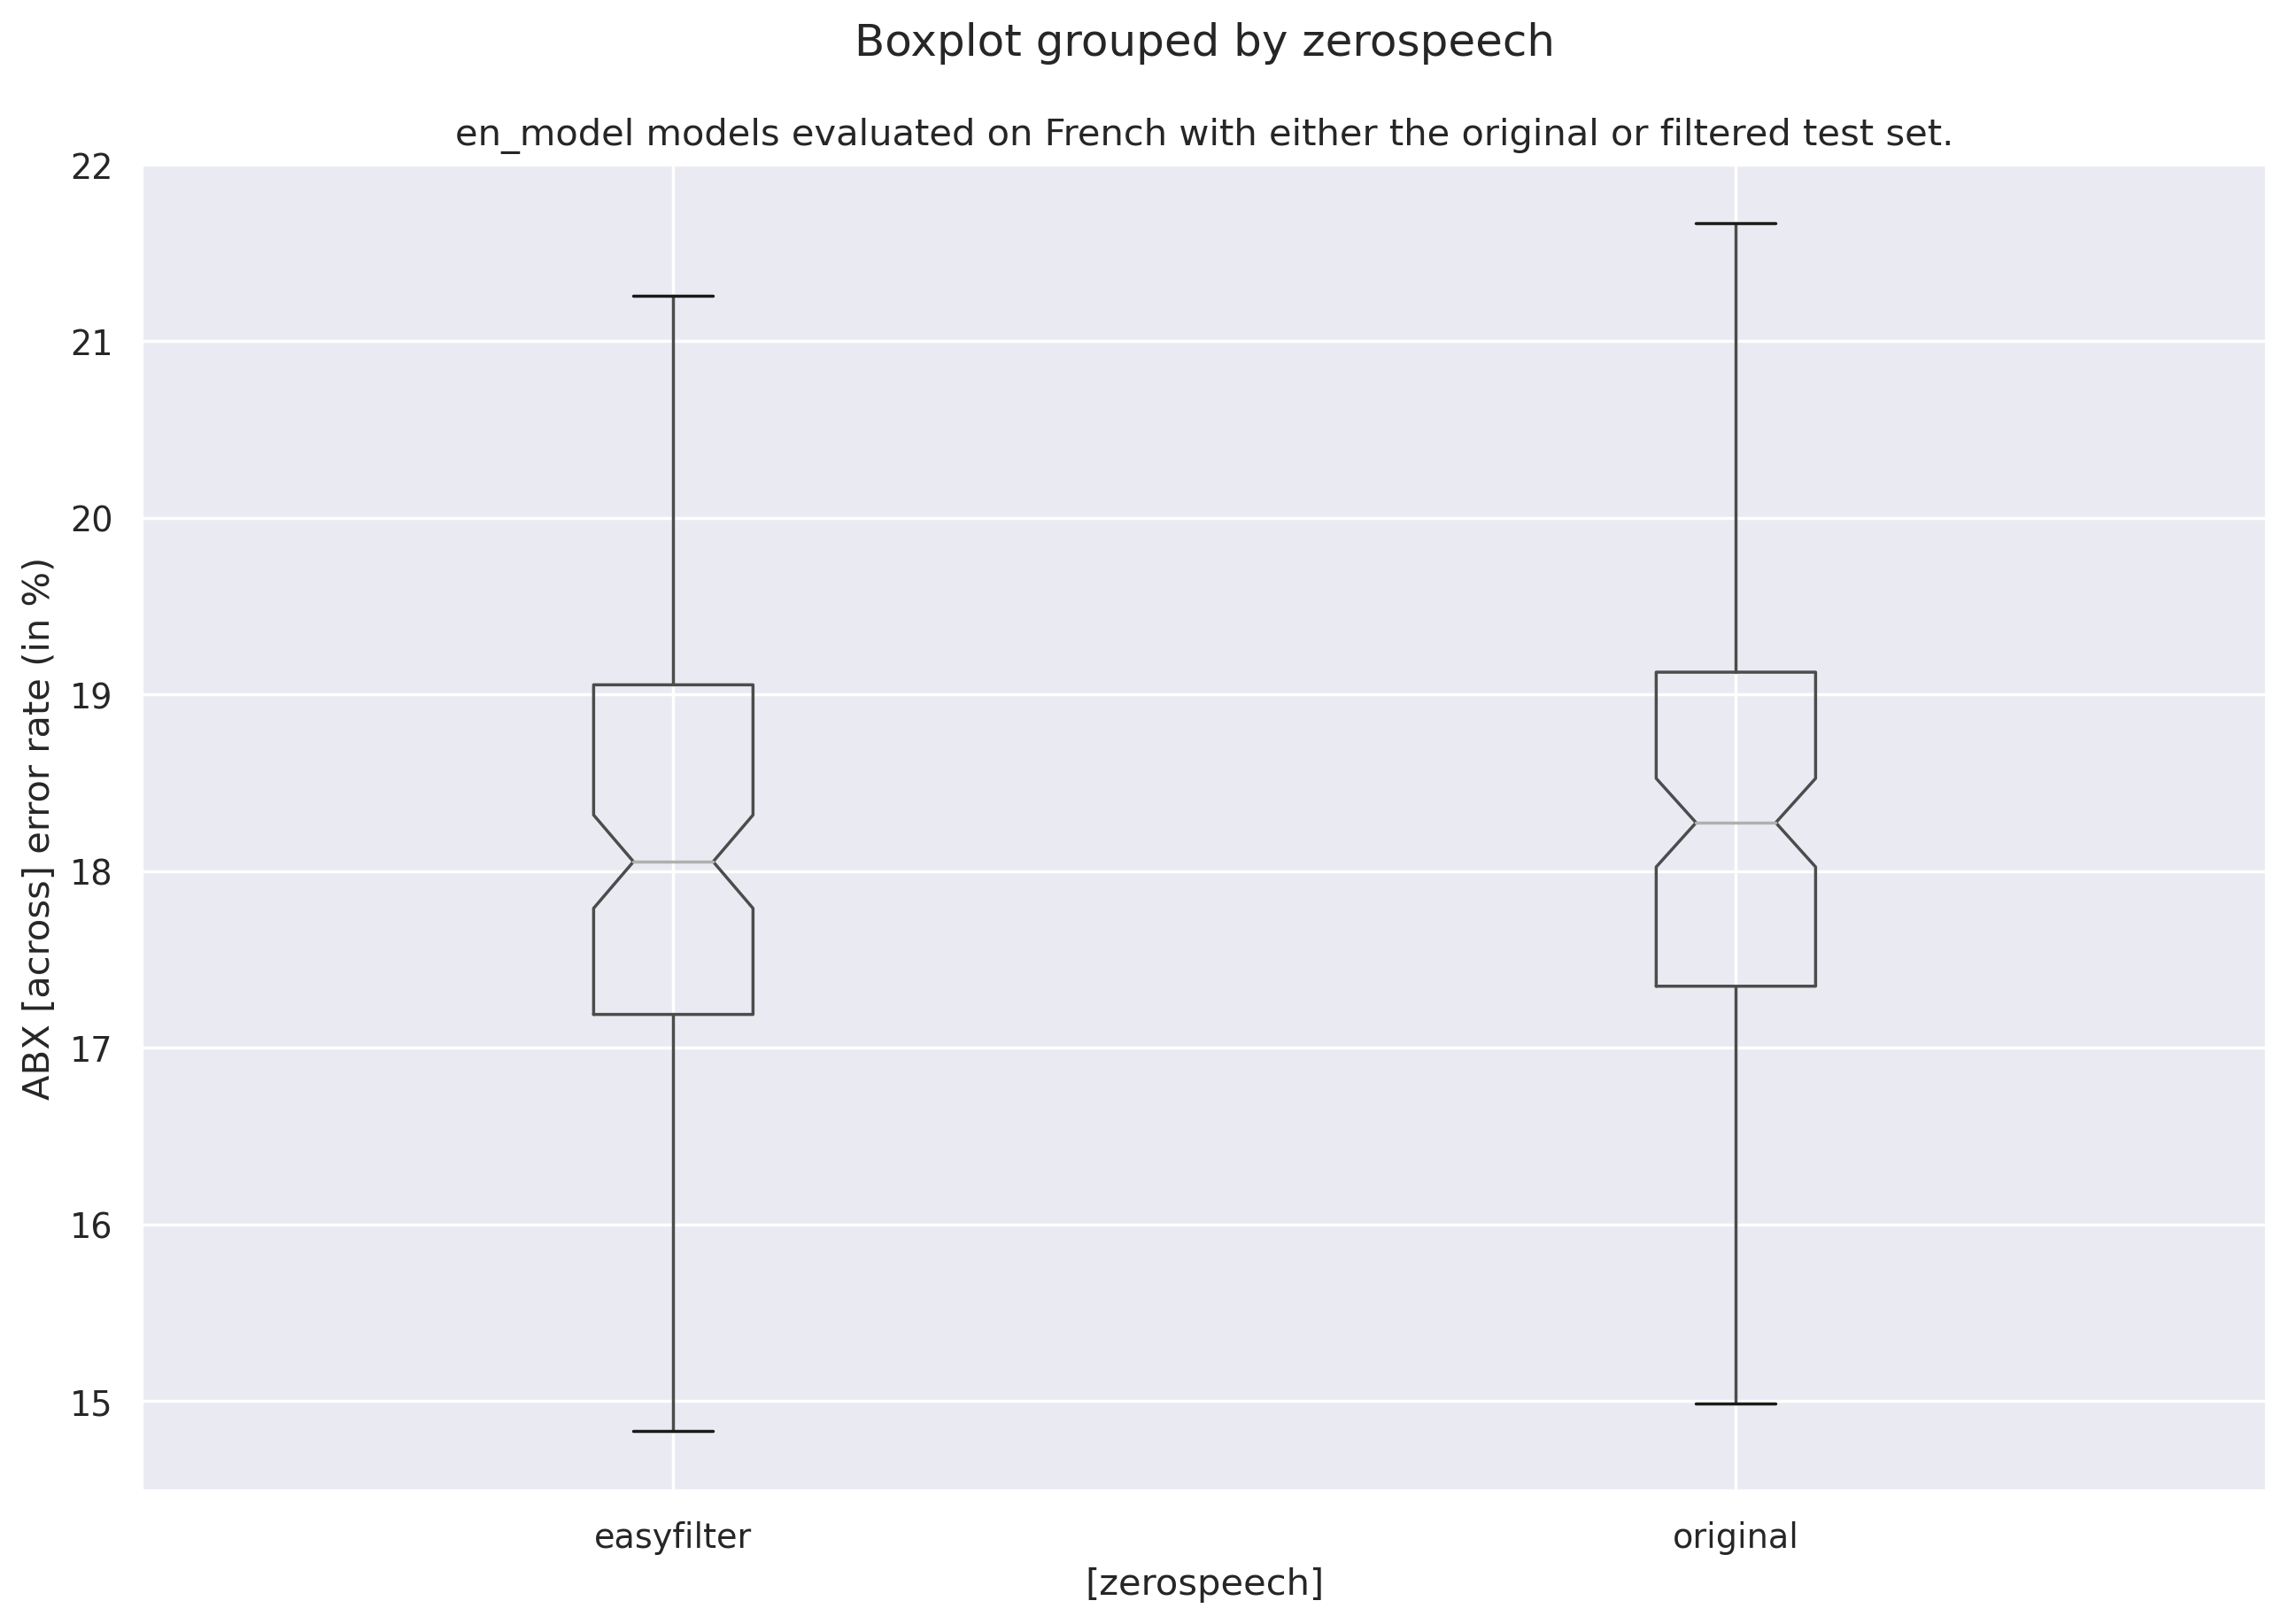

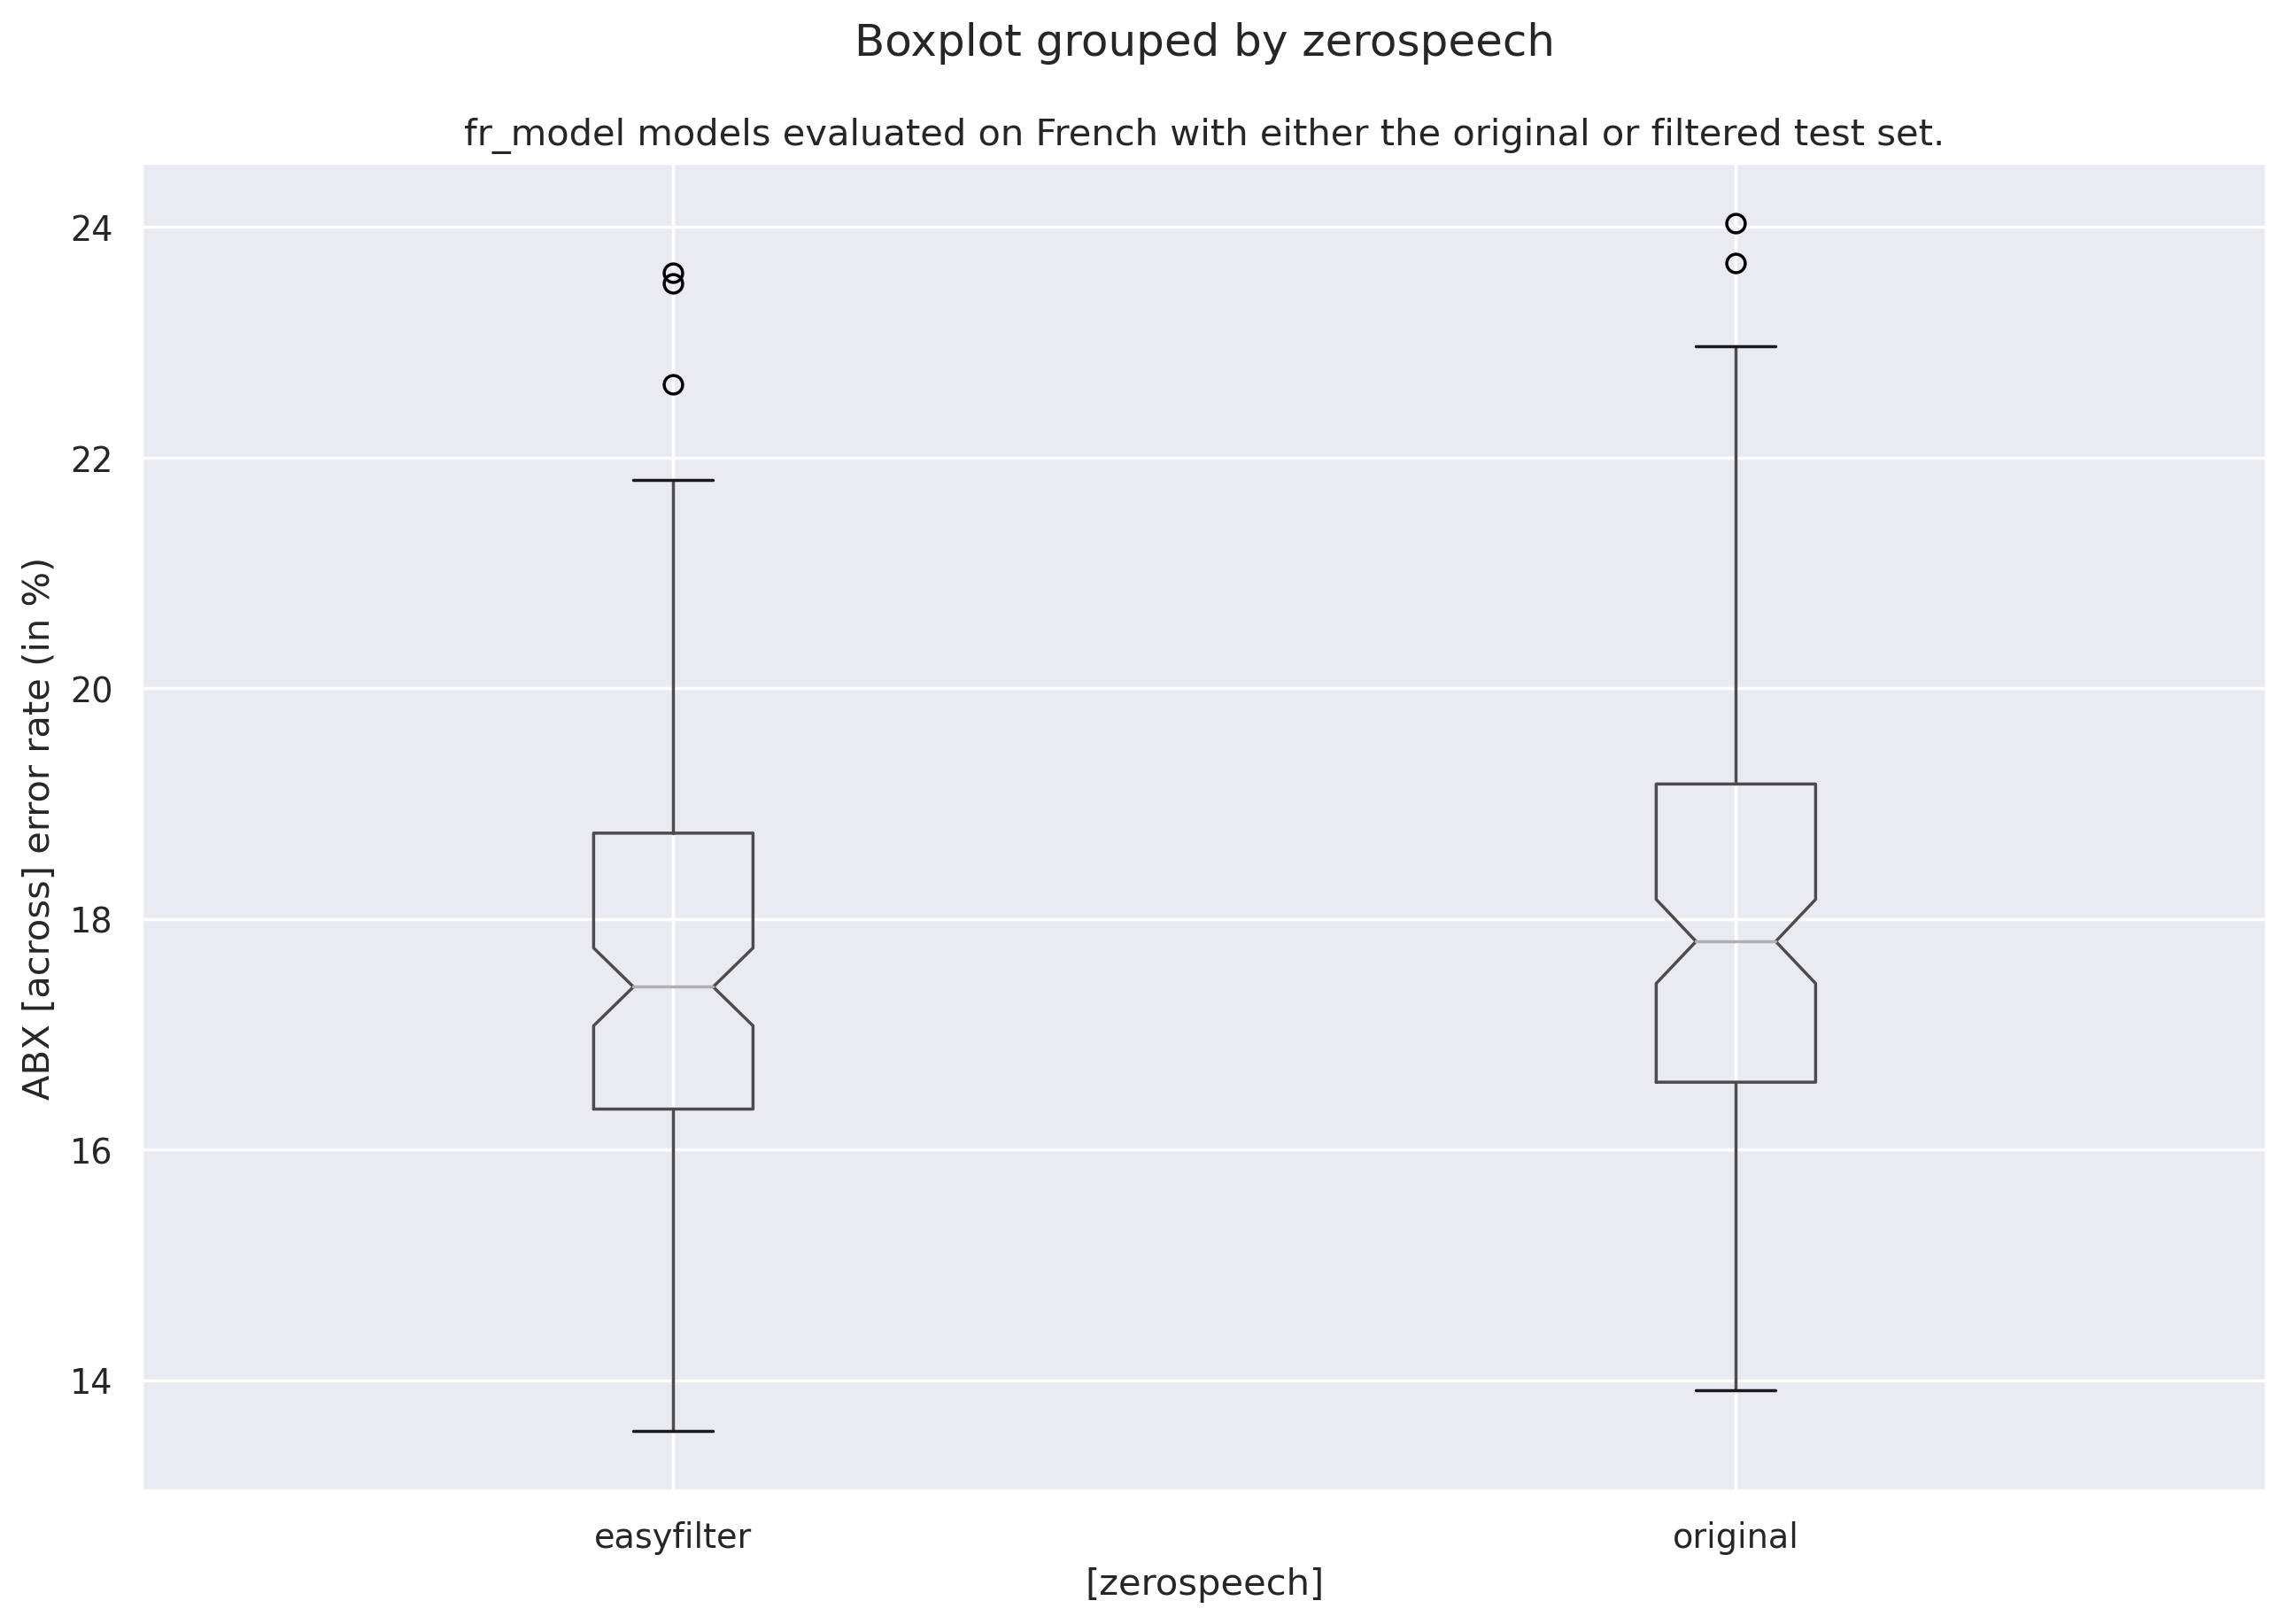

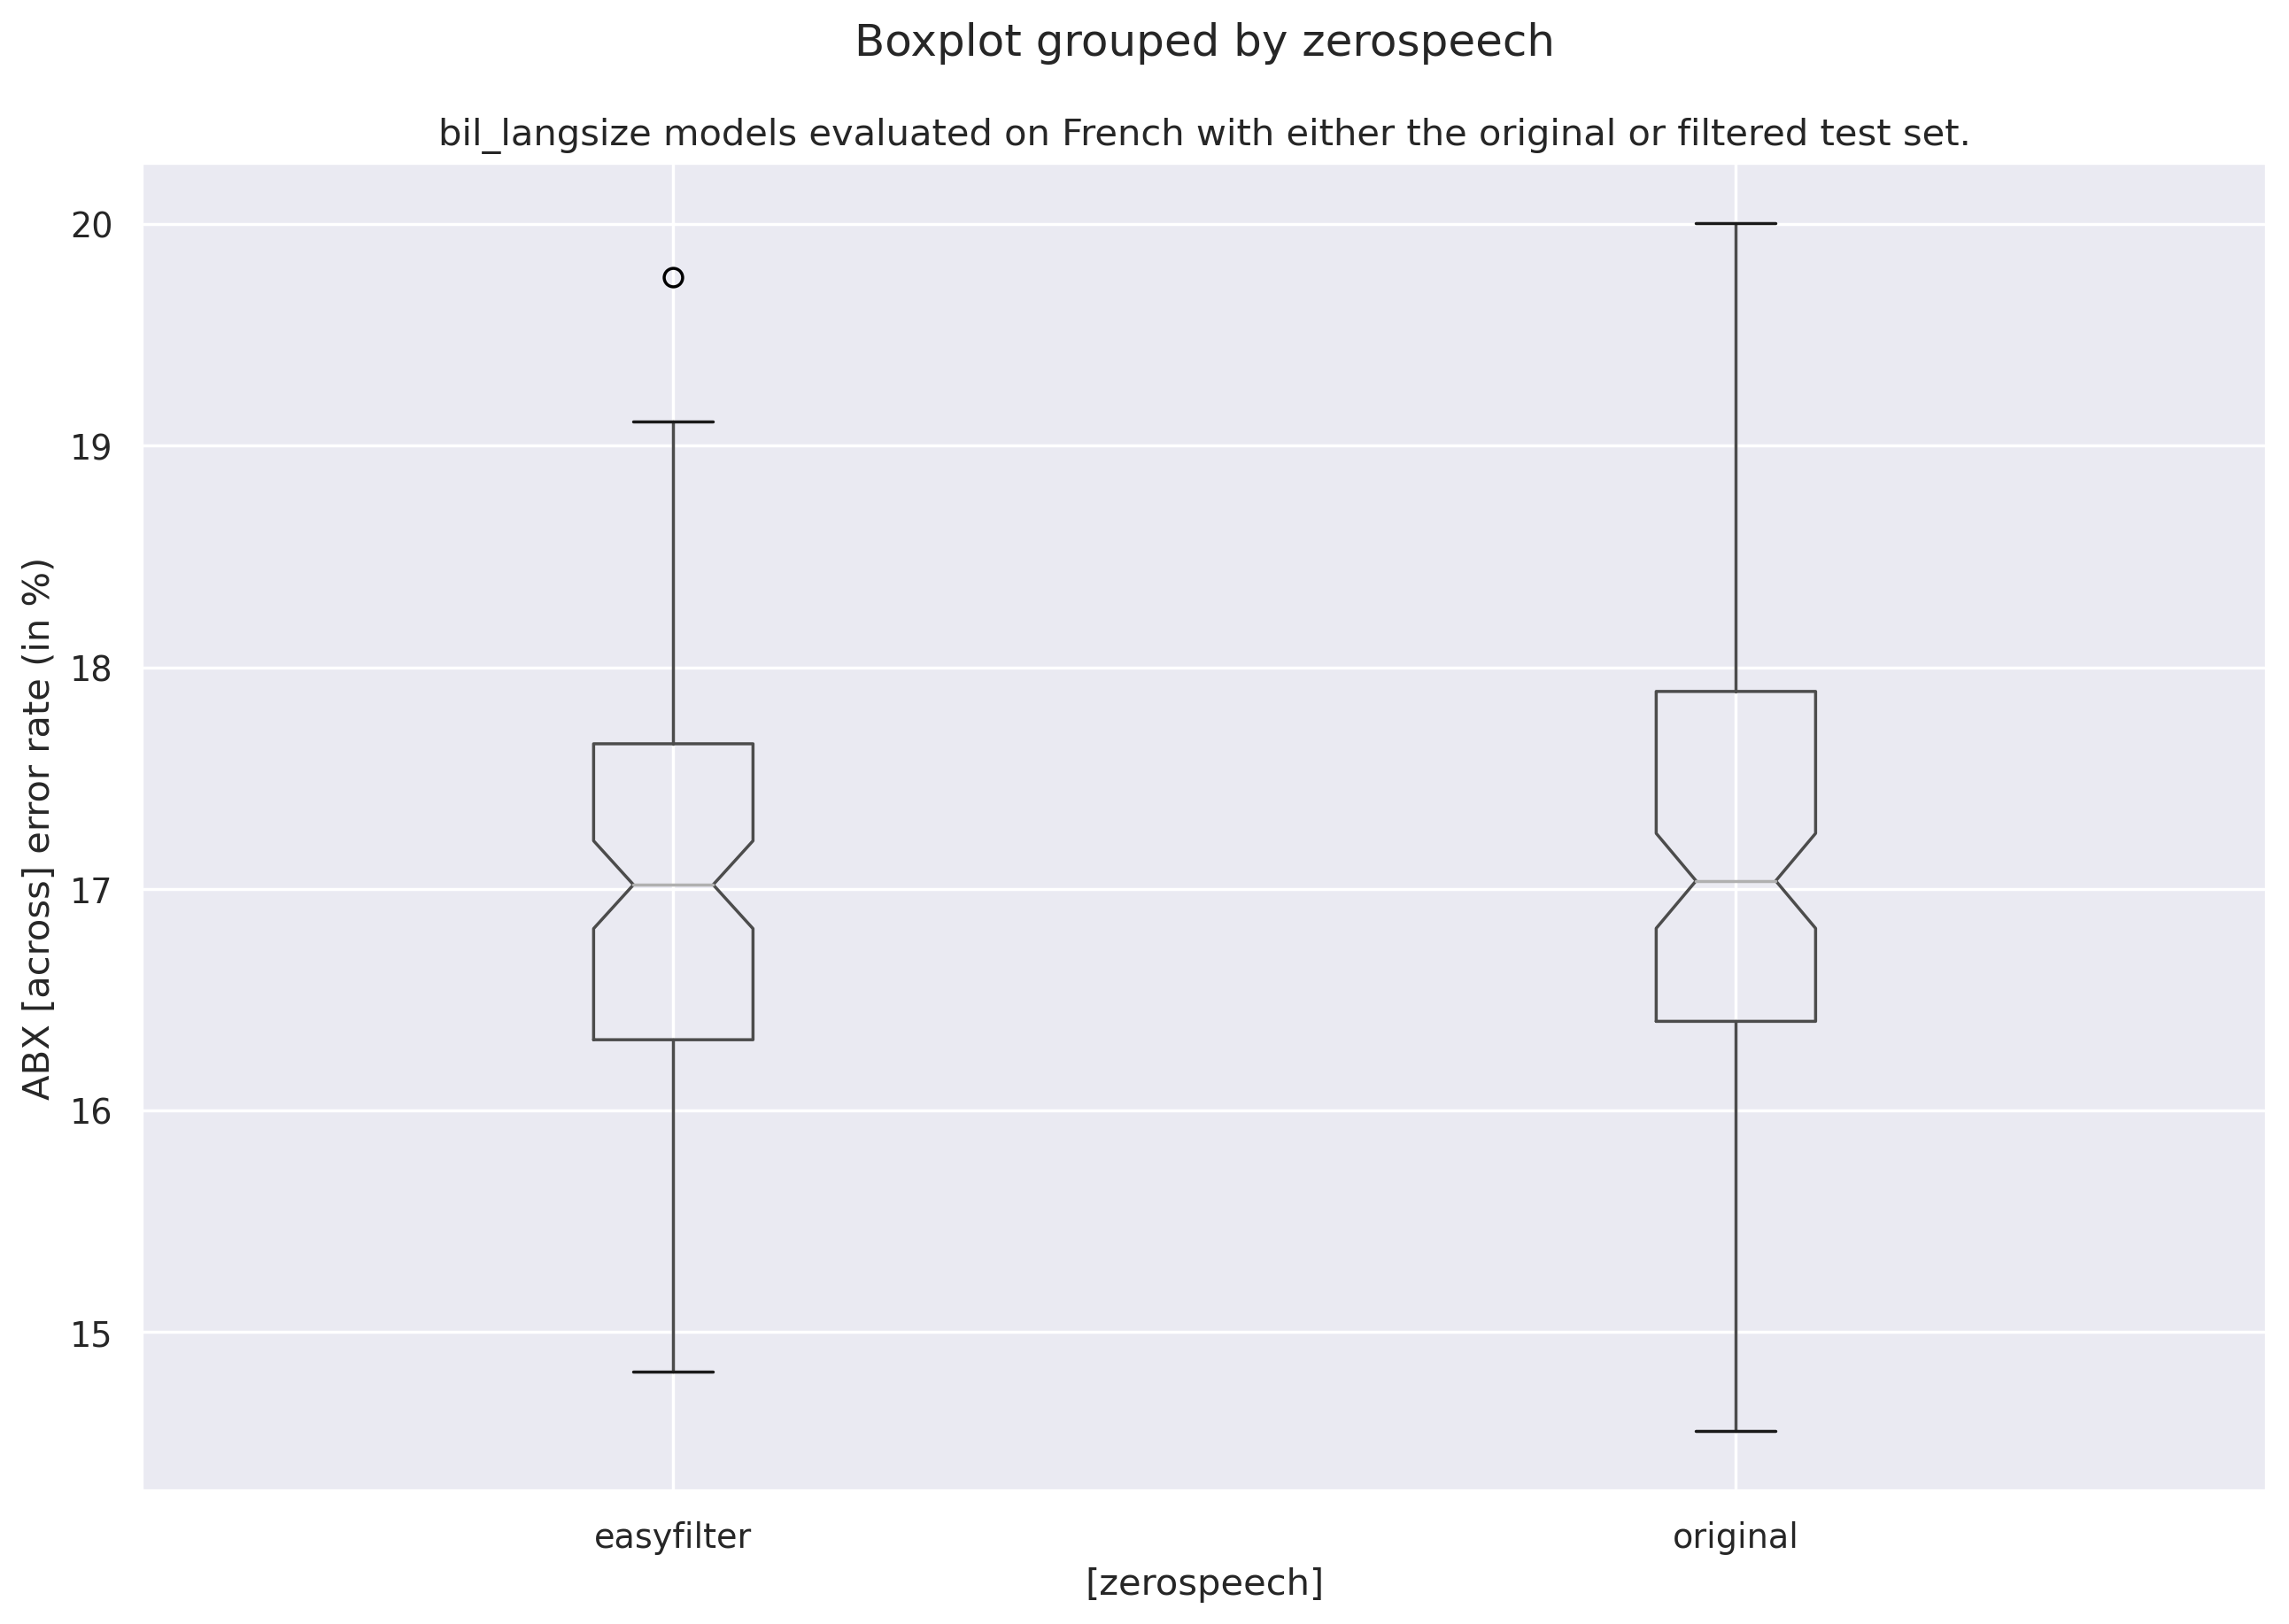

In [19]:

tmp_df = large_df_across[large_df_across['eval_lang'] == "french"]


for mtype in 'en_model', 'fr_model', 'bil_langsize':
    boxplot = tmp_df[['size','en_model', 'fr_model', 'bil_langsize',  'eval_lang', 'zerospeech']].boxplot(notch=True,column=mtype, by=[  'zerospeech'], return_type='axes')
    plt.title("{} models evaluated on French with either the original or filtered test set.".format(mtype))
    plt.ylabel('ABX [across] error rate (in %)')
#for bp in boxplot: 
#    bp.set_ylabel('ABX error rate (in %)')
#    bp.set_xlabel('# training hours')


### B3 Scores detailed per training size (abx within)

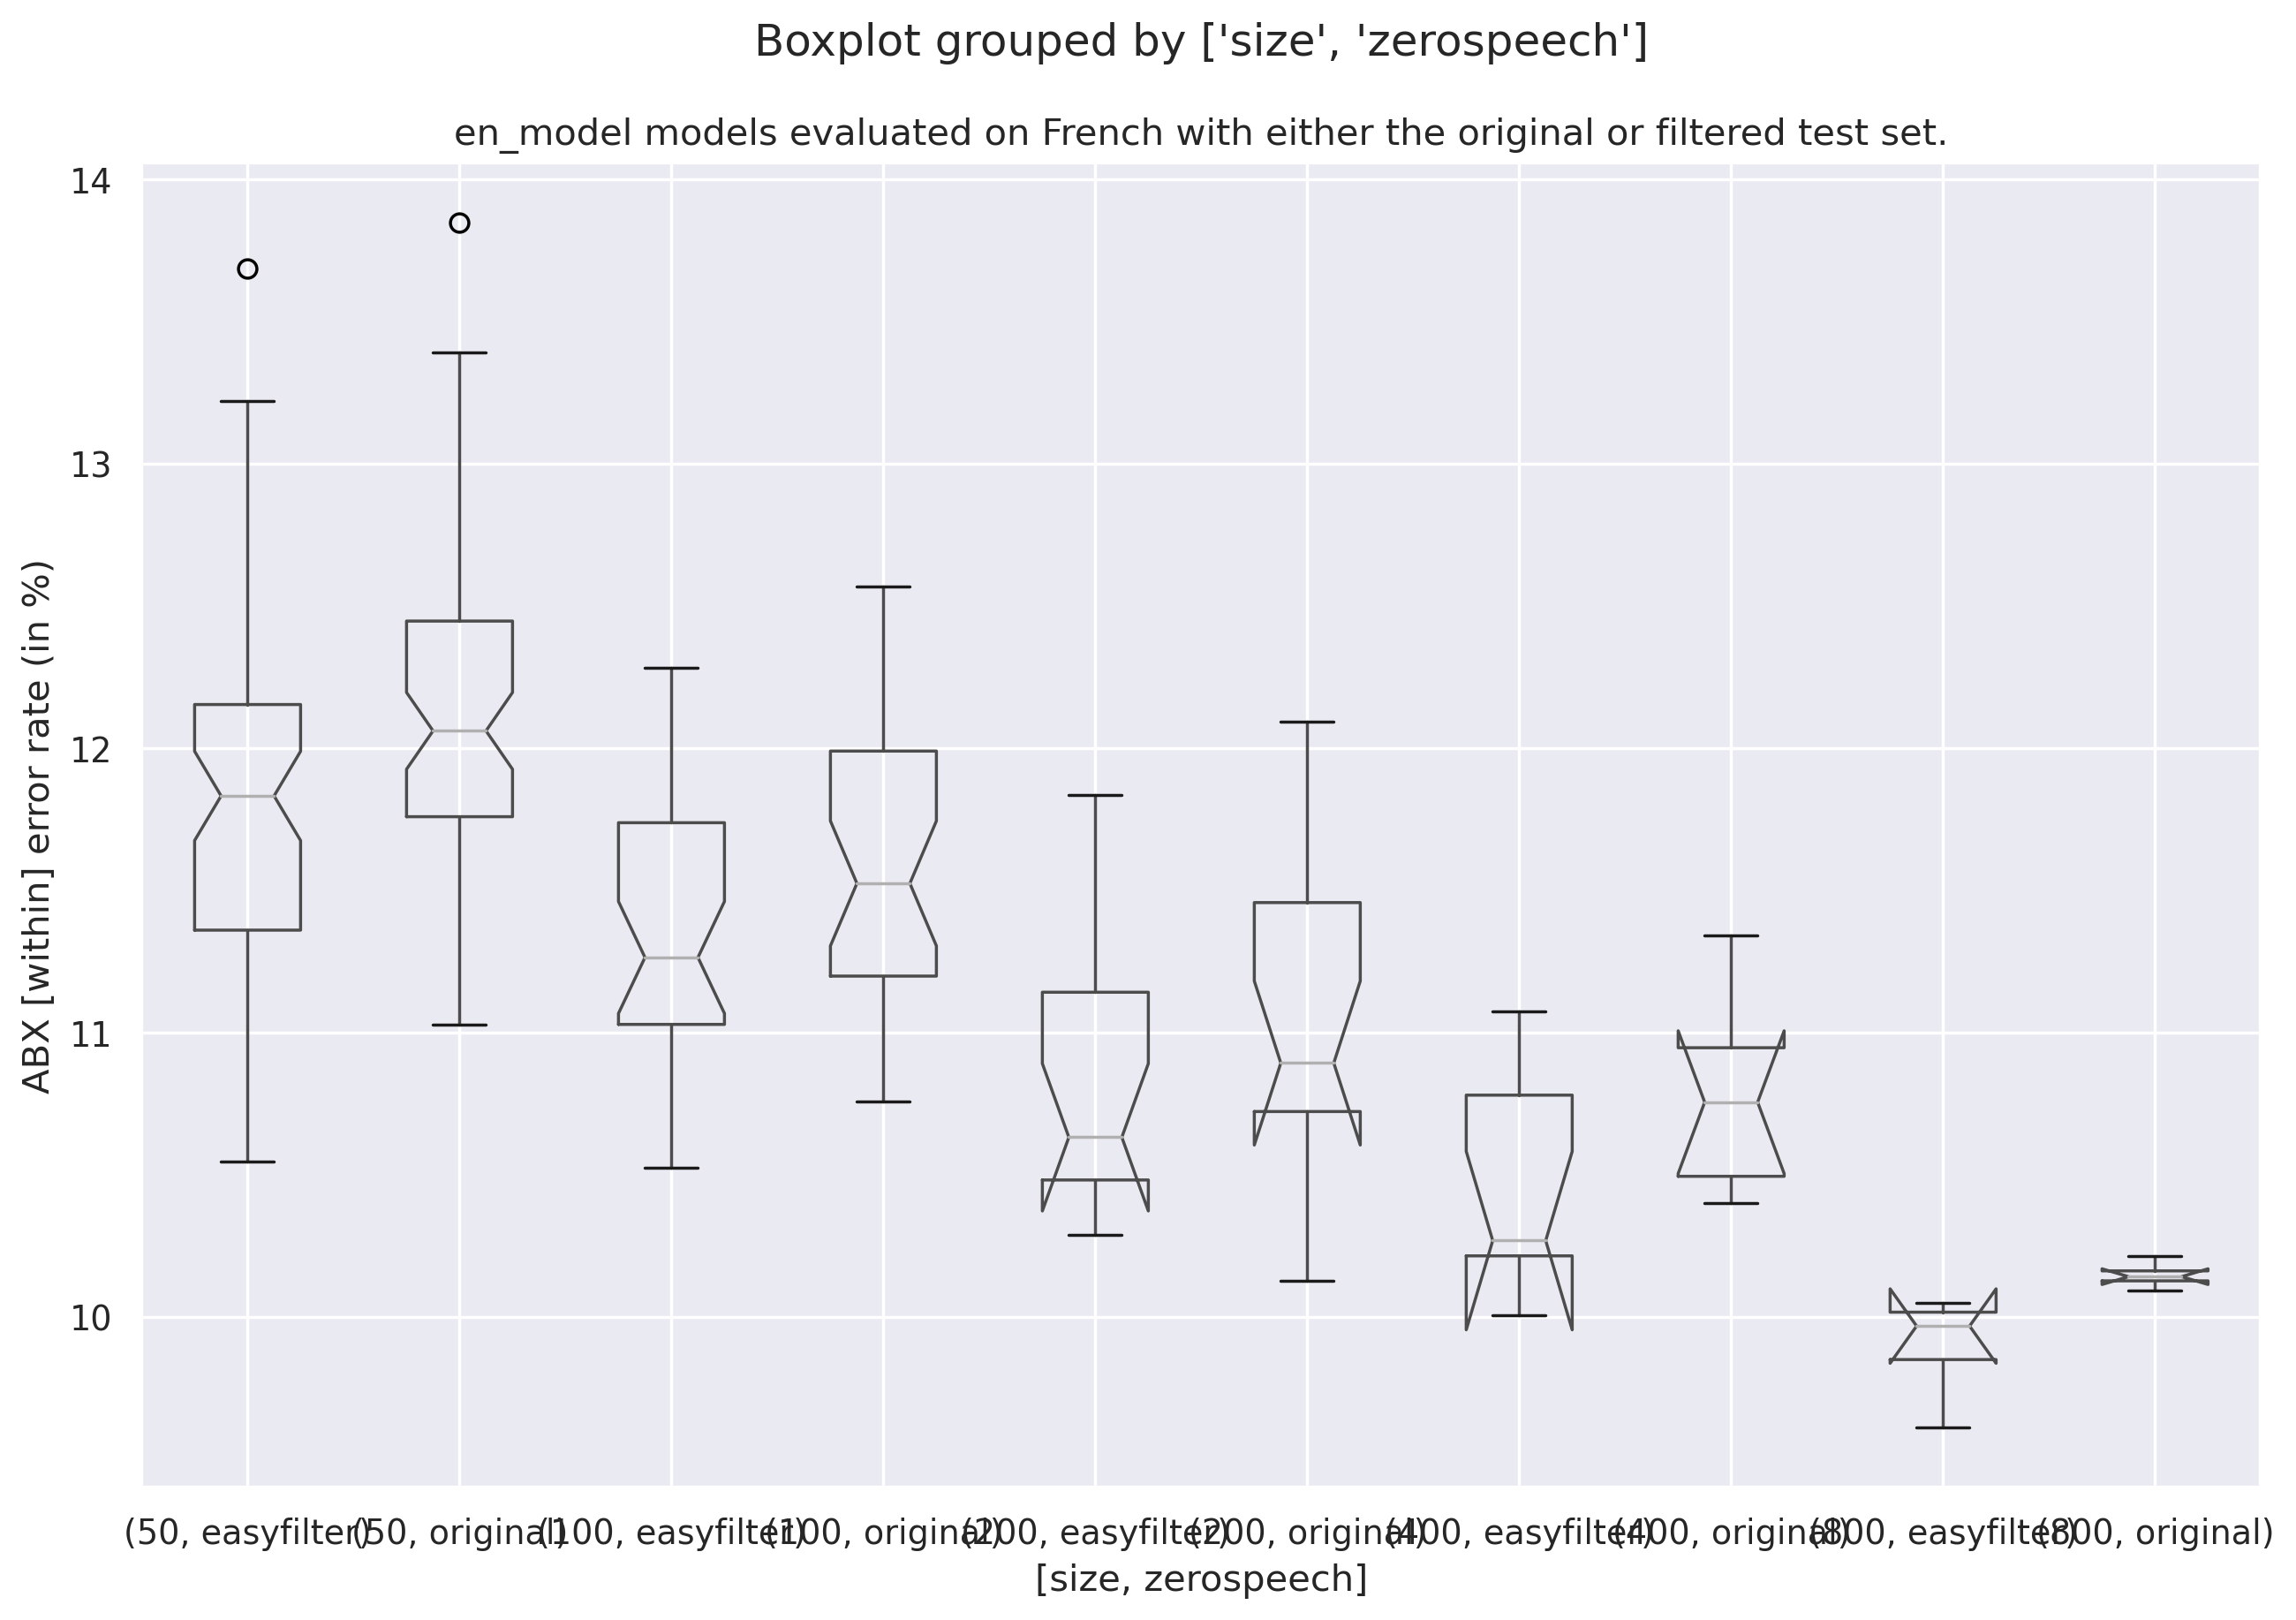

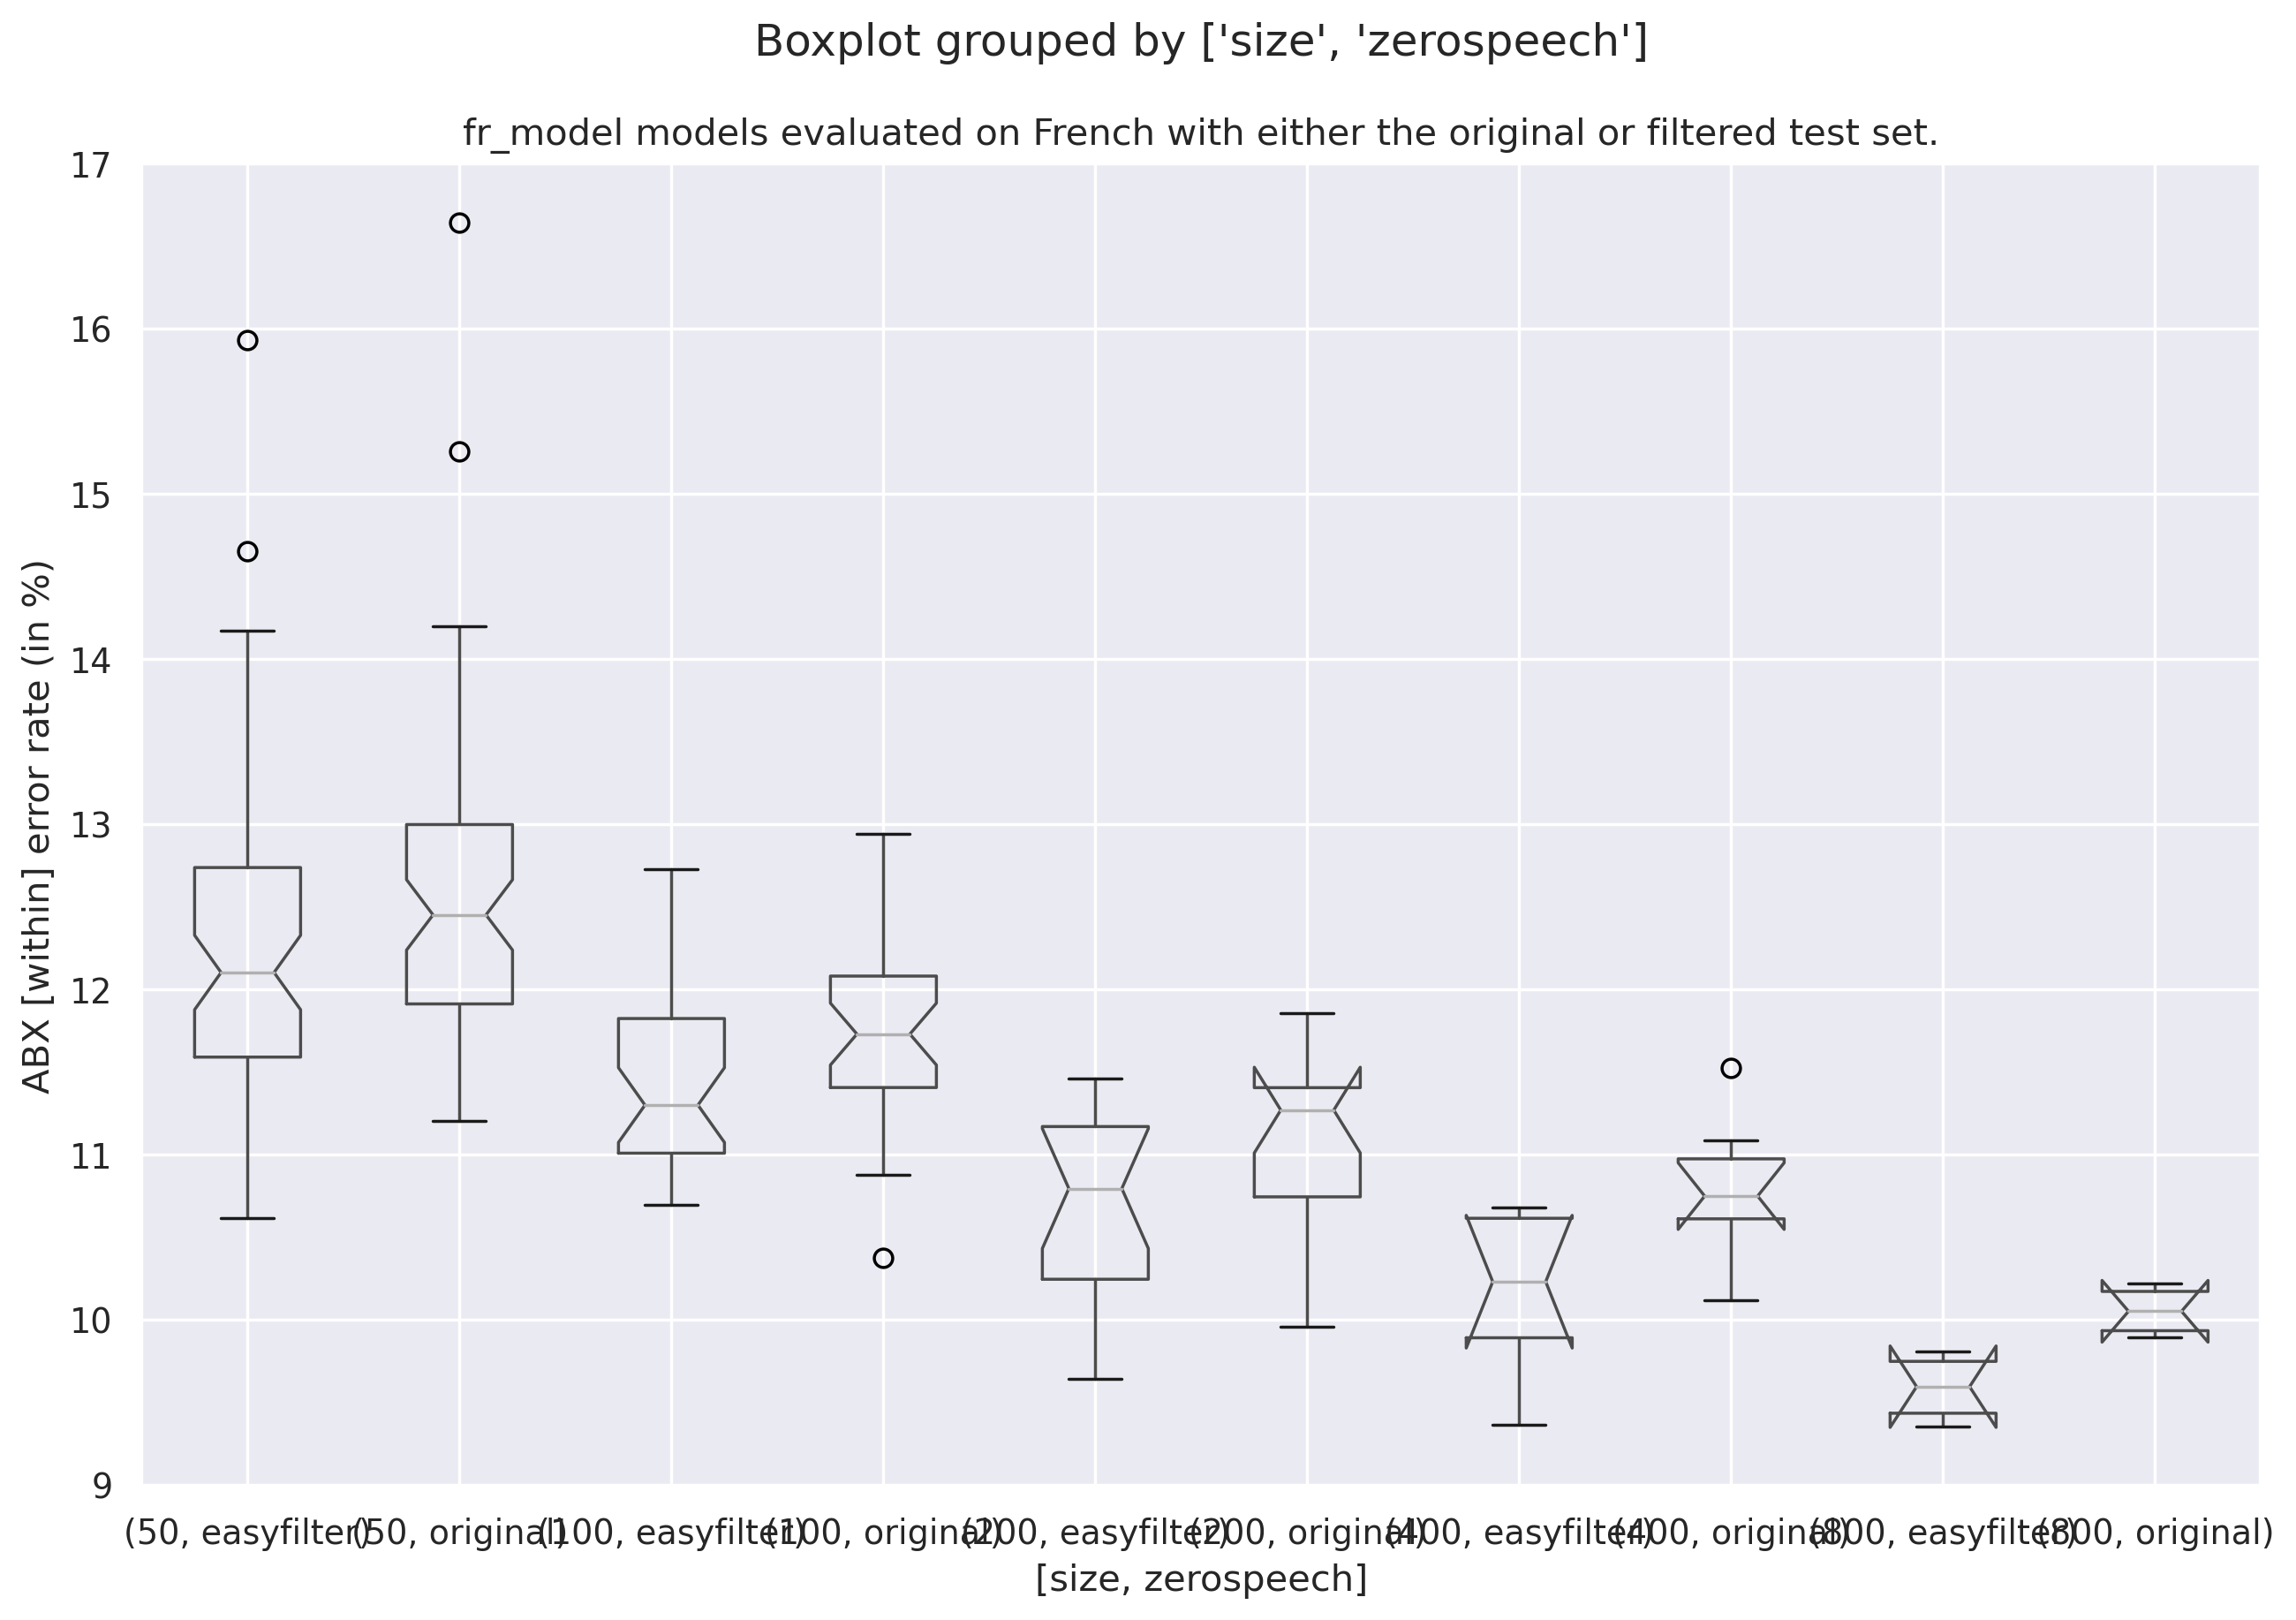

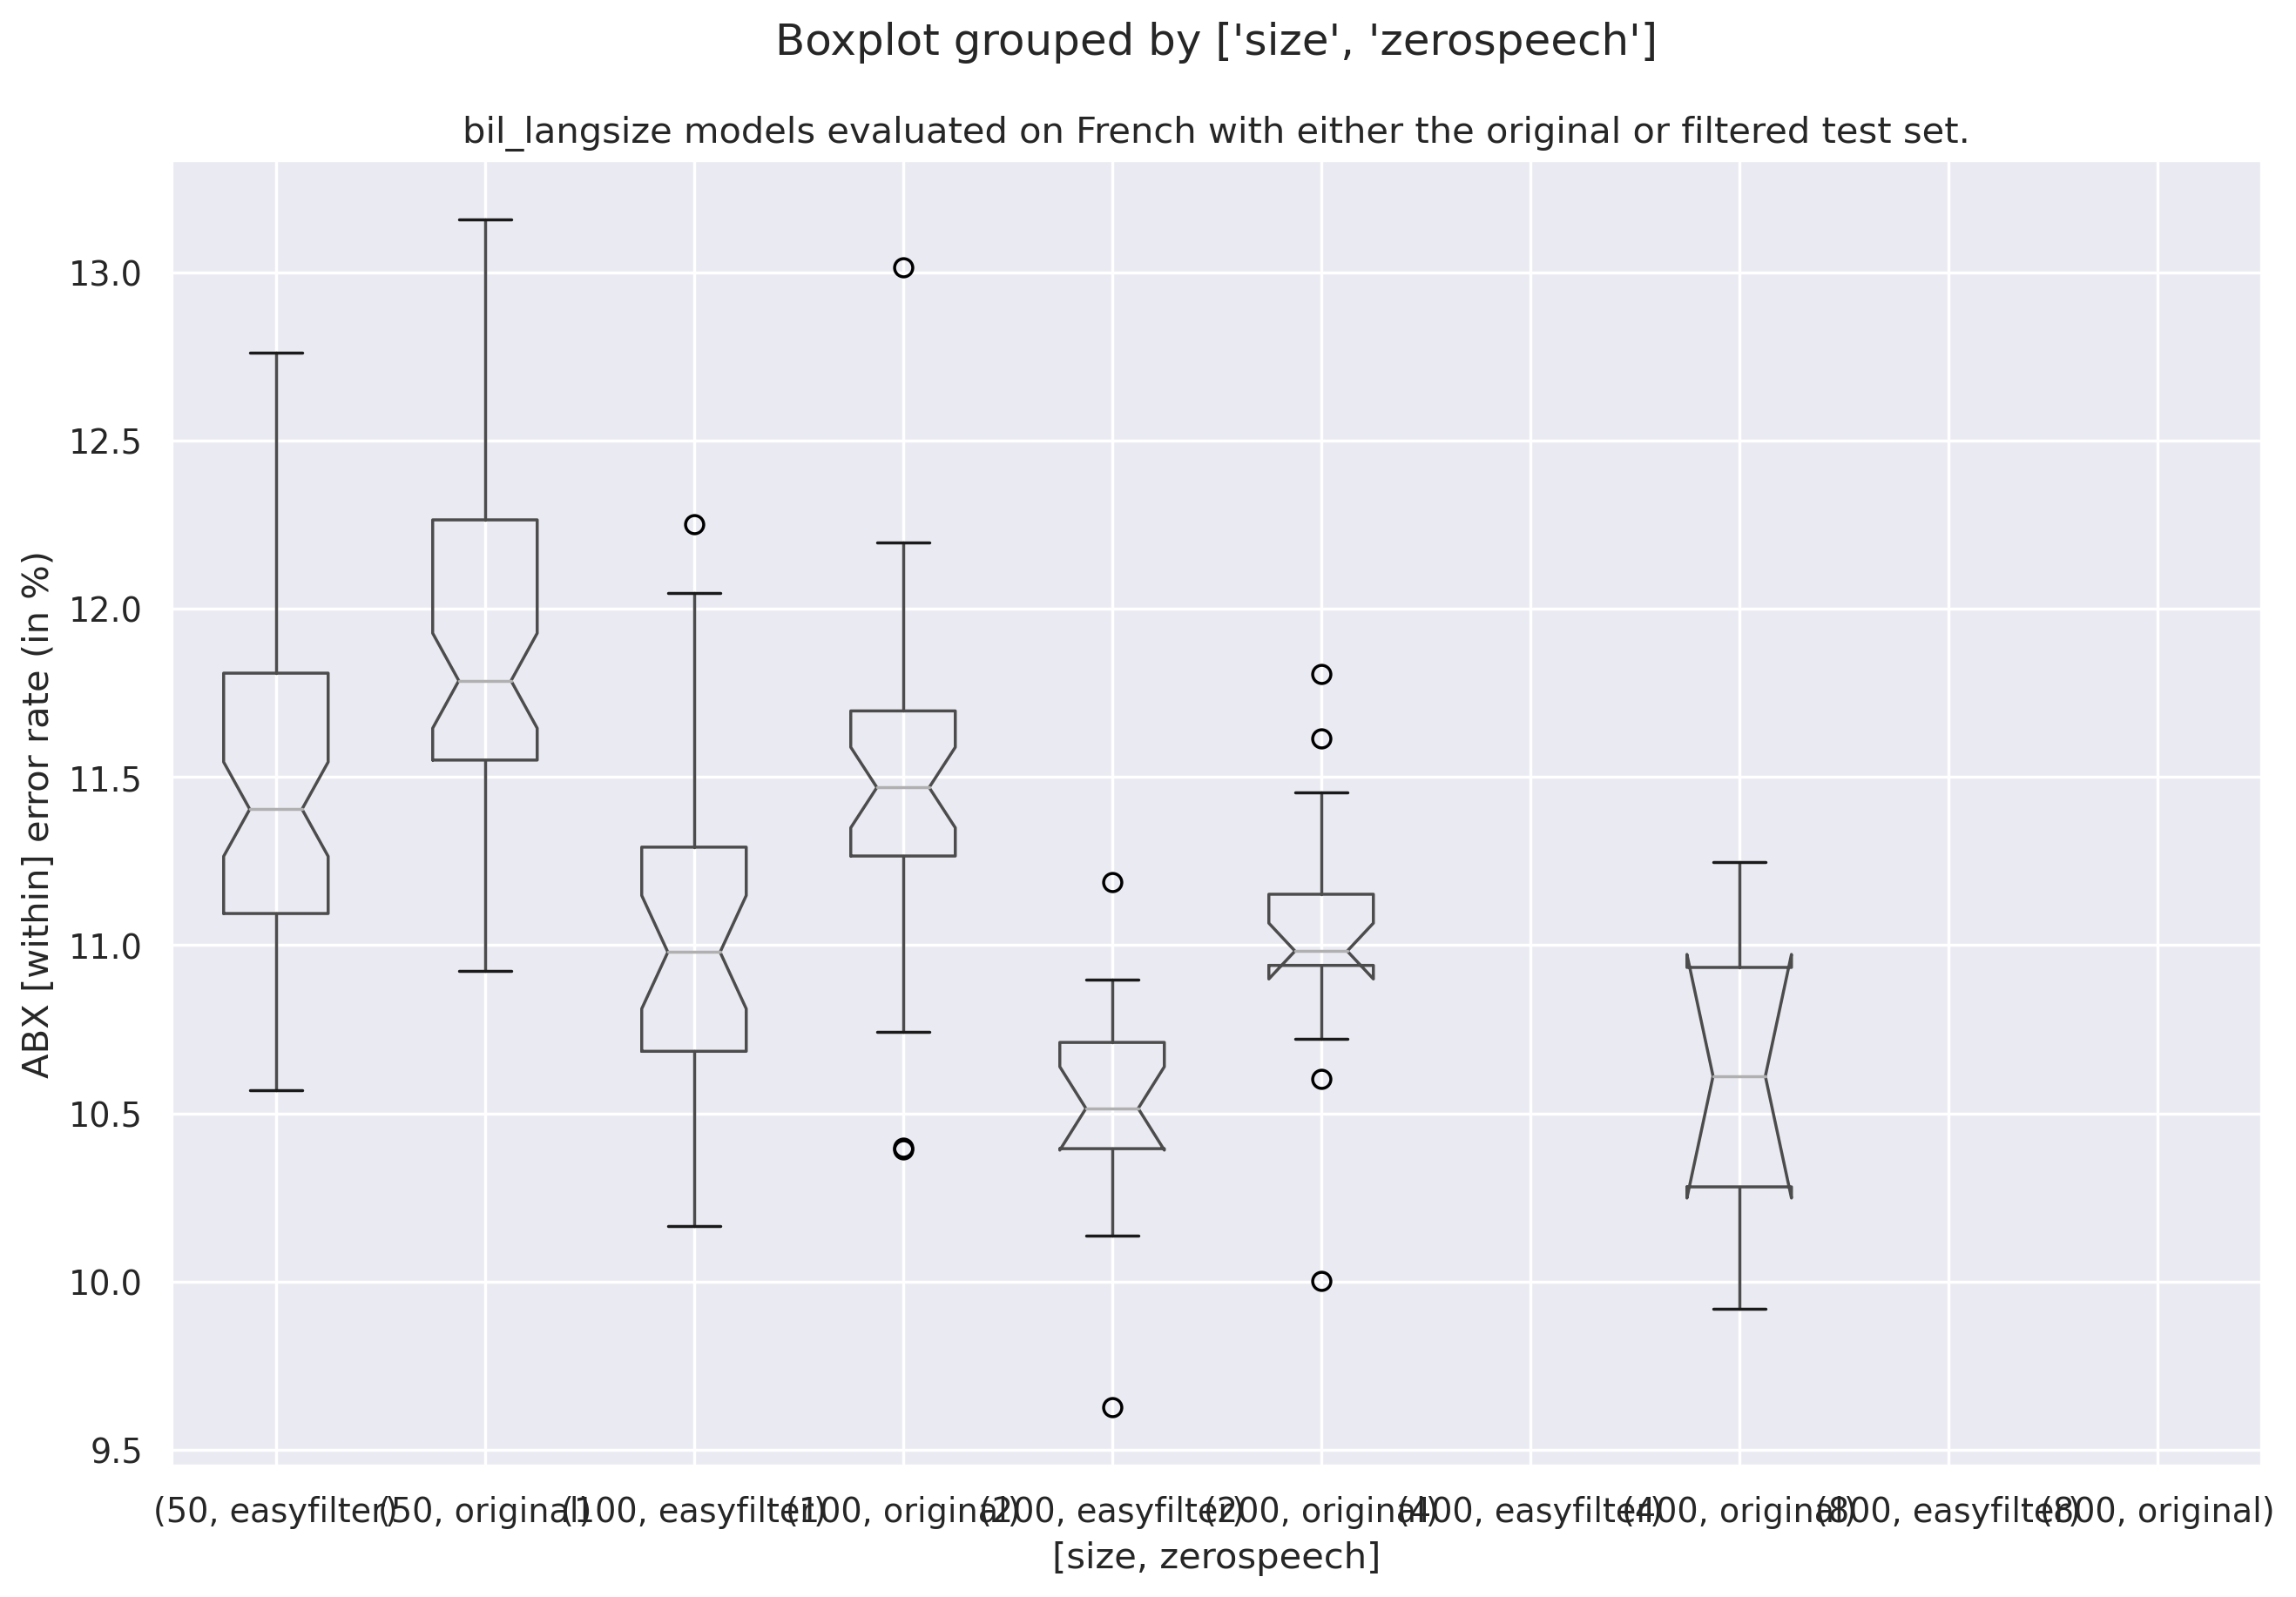

In [15]:

tmp_df = large_df_within[large_df_within['eval_lang'] == "french"]


for mtype in 'en_model', 'fr_model', 'bil_langsize':
    boxplot = tmp_df[['size','en_model', 'fr_model', 'bil_langsize',  'eval_lang', 'zerospeech']].boxplot(notch=True,column=mtype, by=[ 'size', 'zerospeech'], return_type='axes')
    plt.title("{} models evaluated on French with either the original or filtered test set.".format(mtype))
    plt.ylabel('ABX [within] error rate (in %)')
#for bp in boxplot: 
#    bp.set_ylabel('ABX error rate (in %)')
#    bp.set_xlabel('# training hours')


### B4. Scores detailed per training size (abx across)

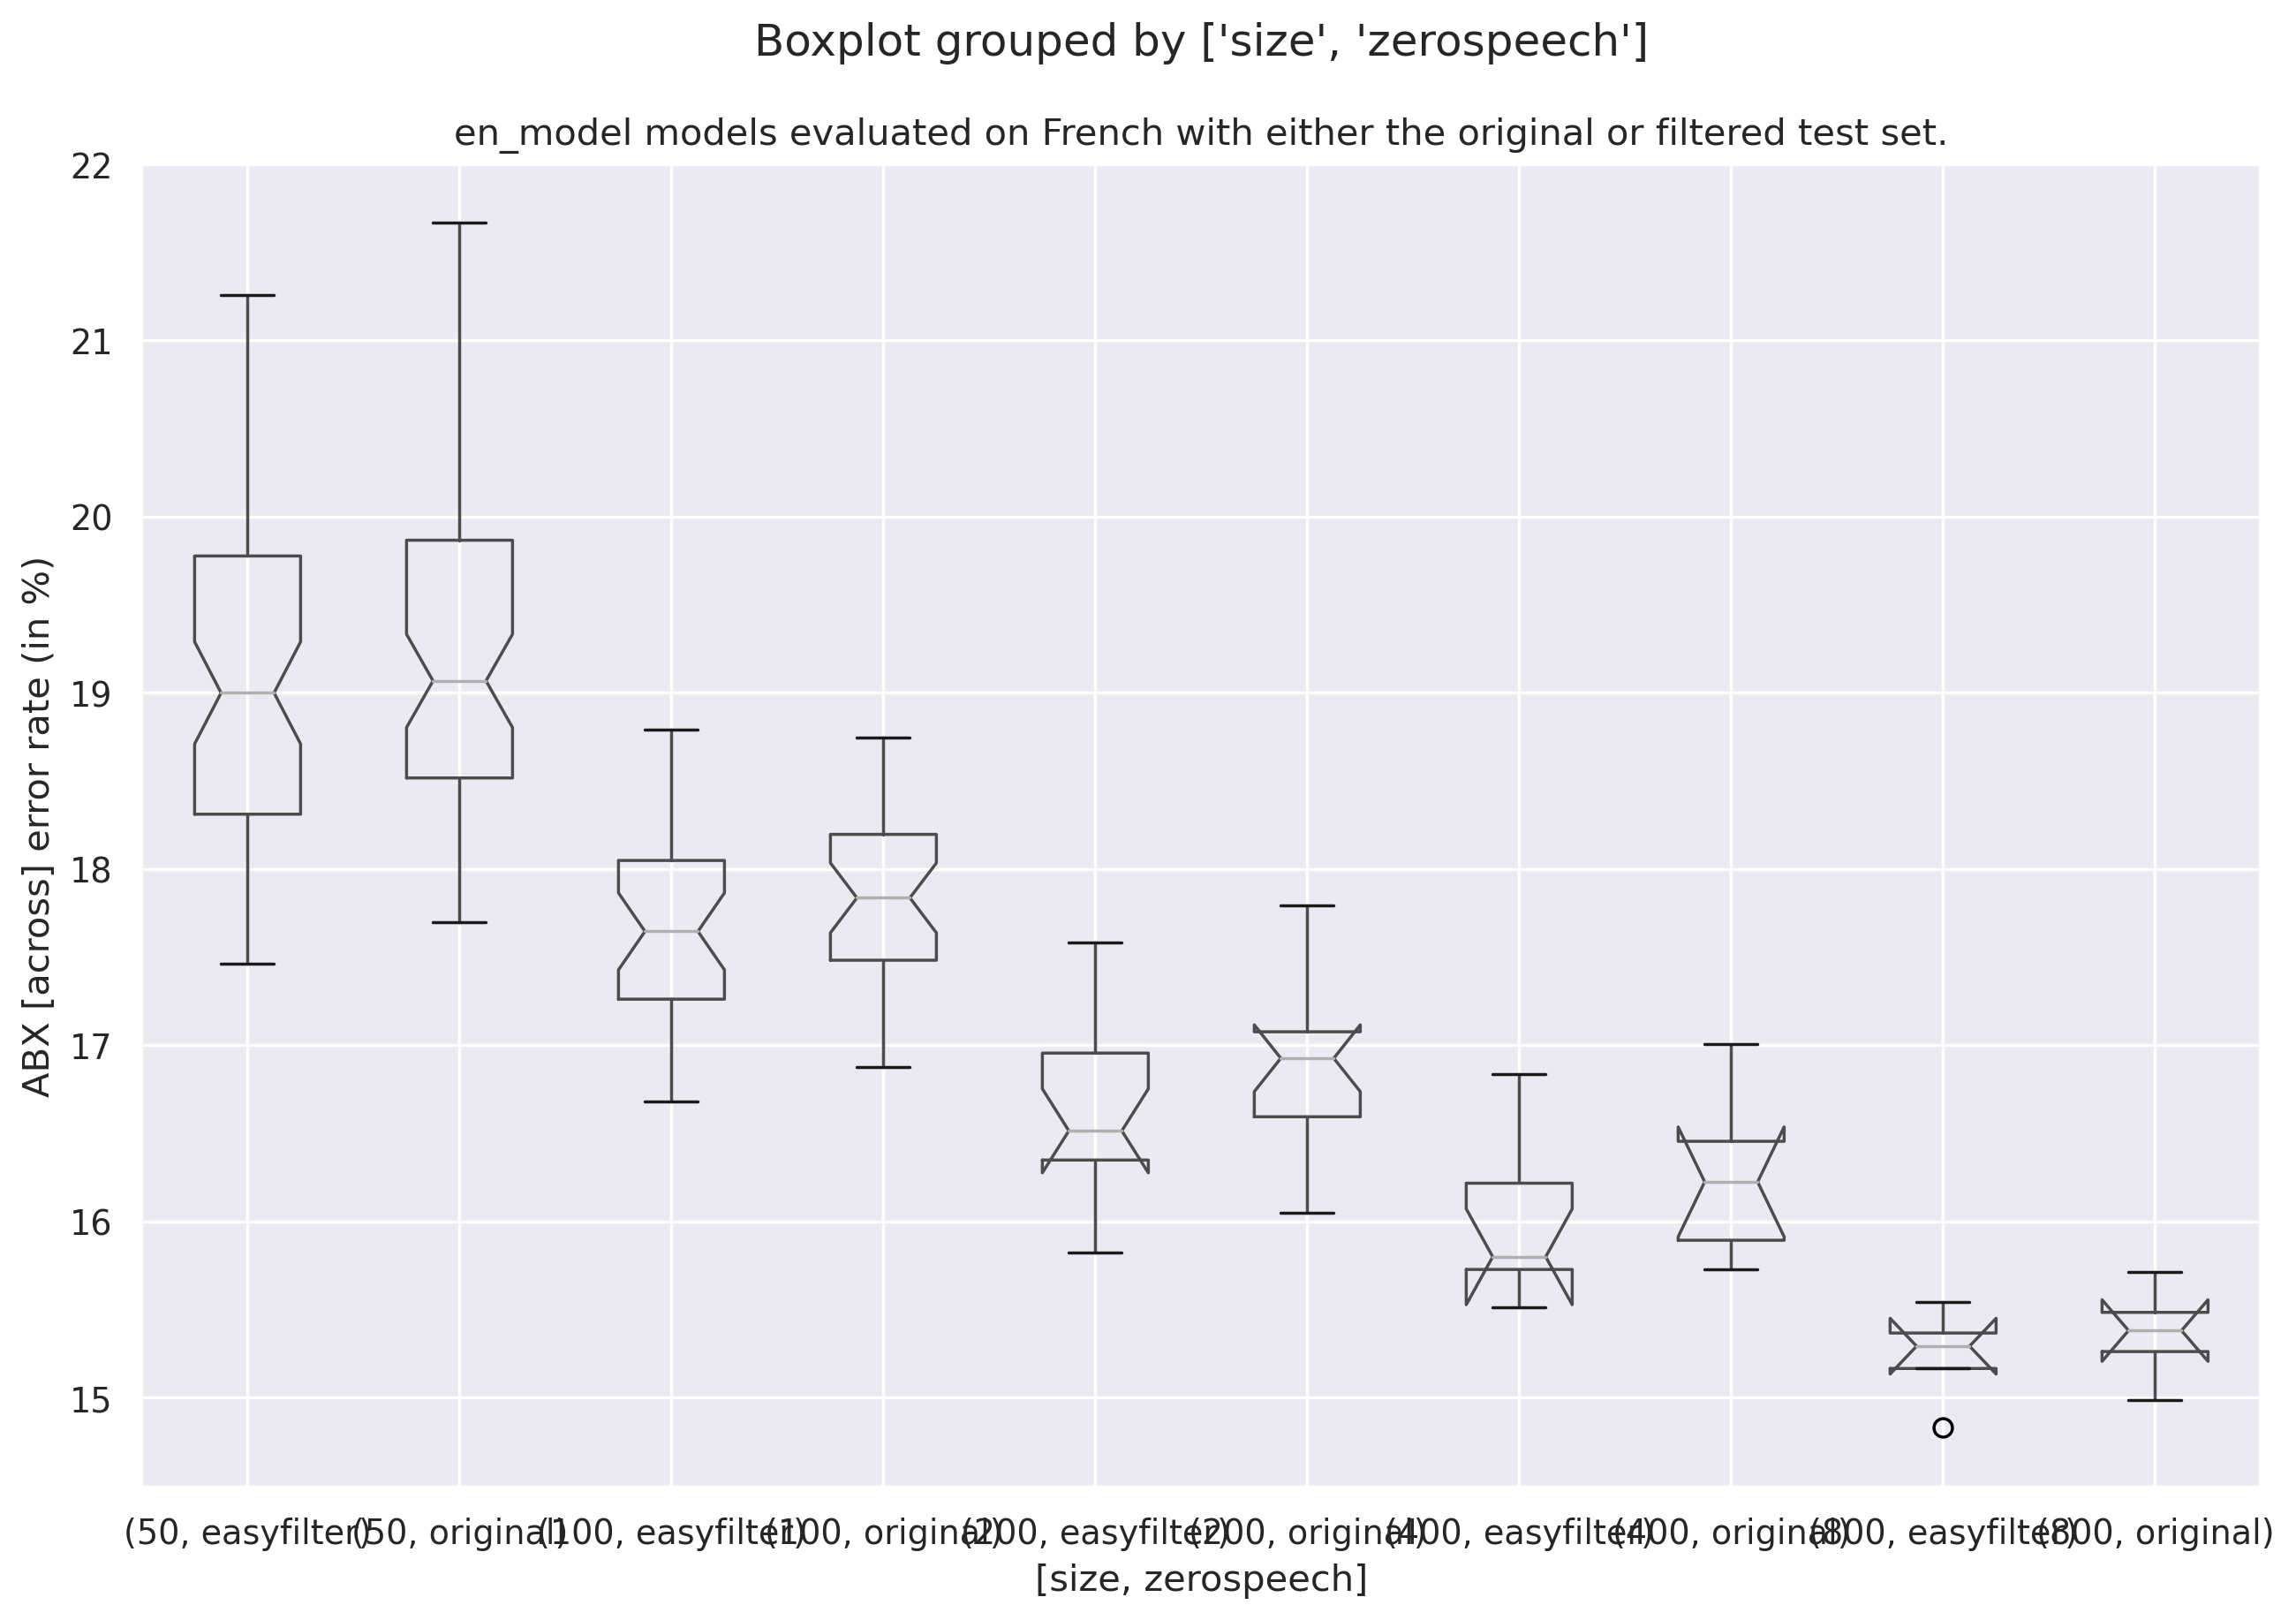

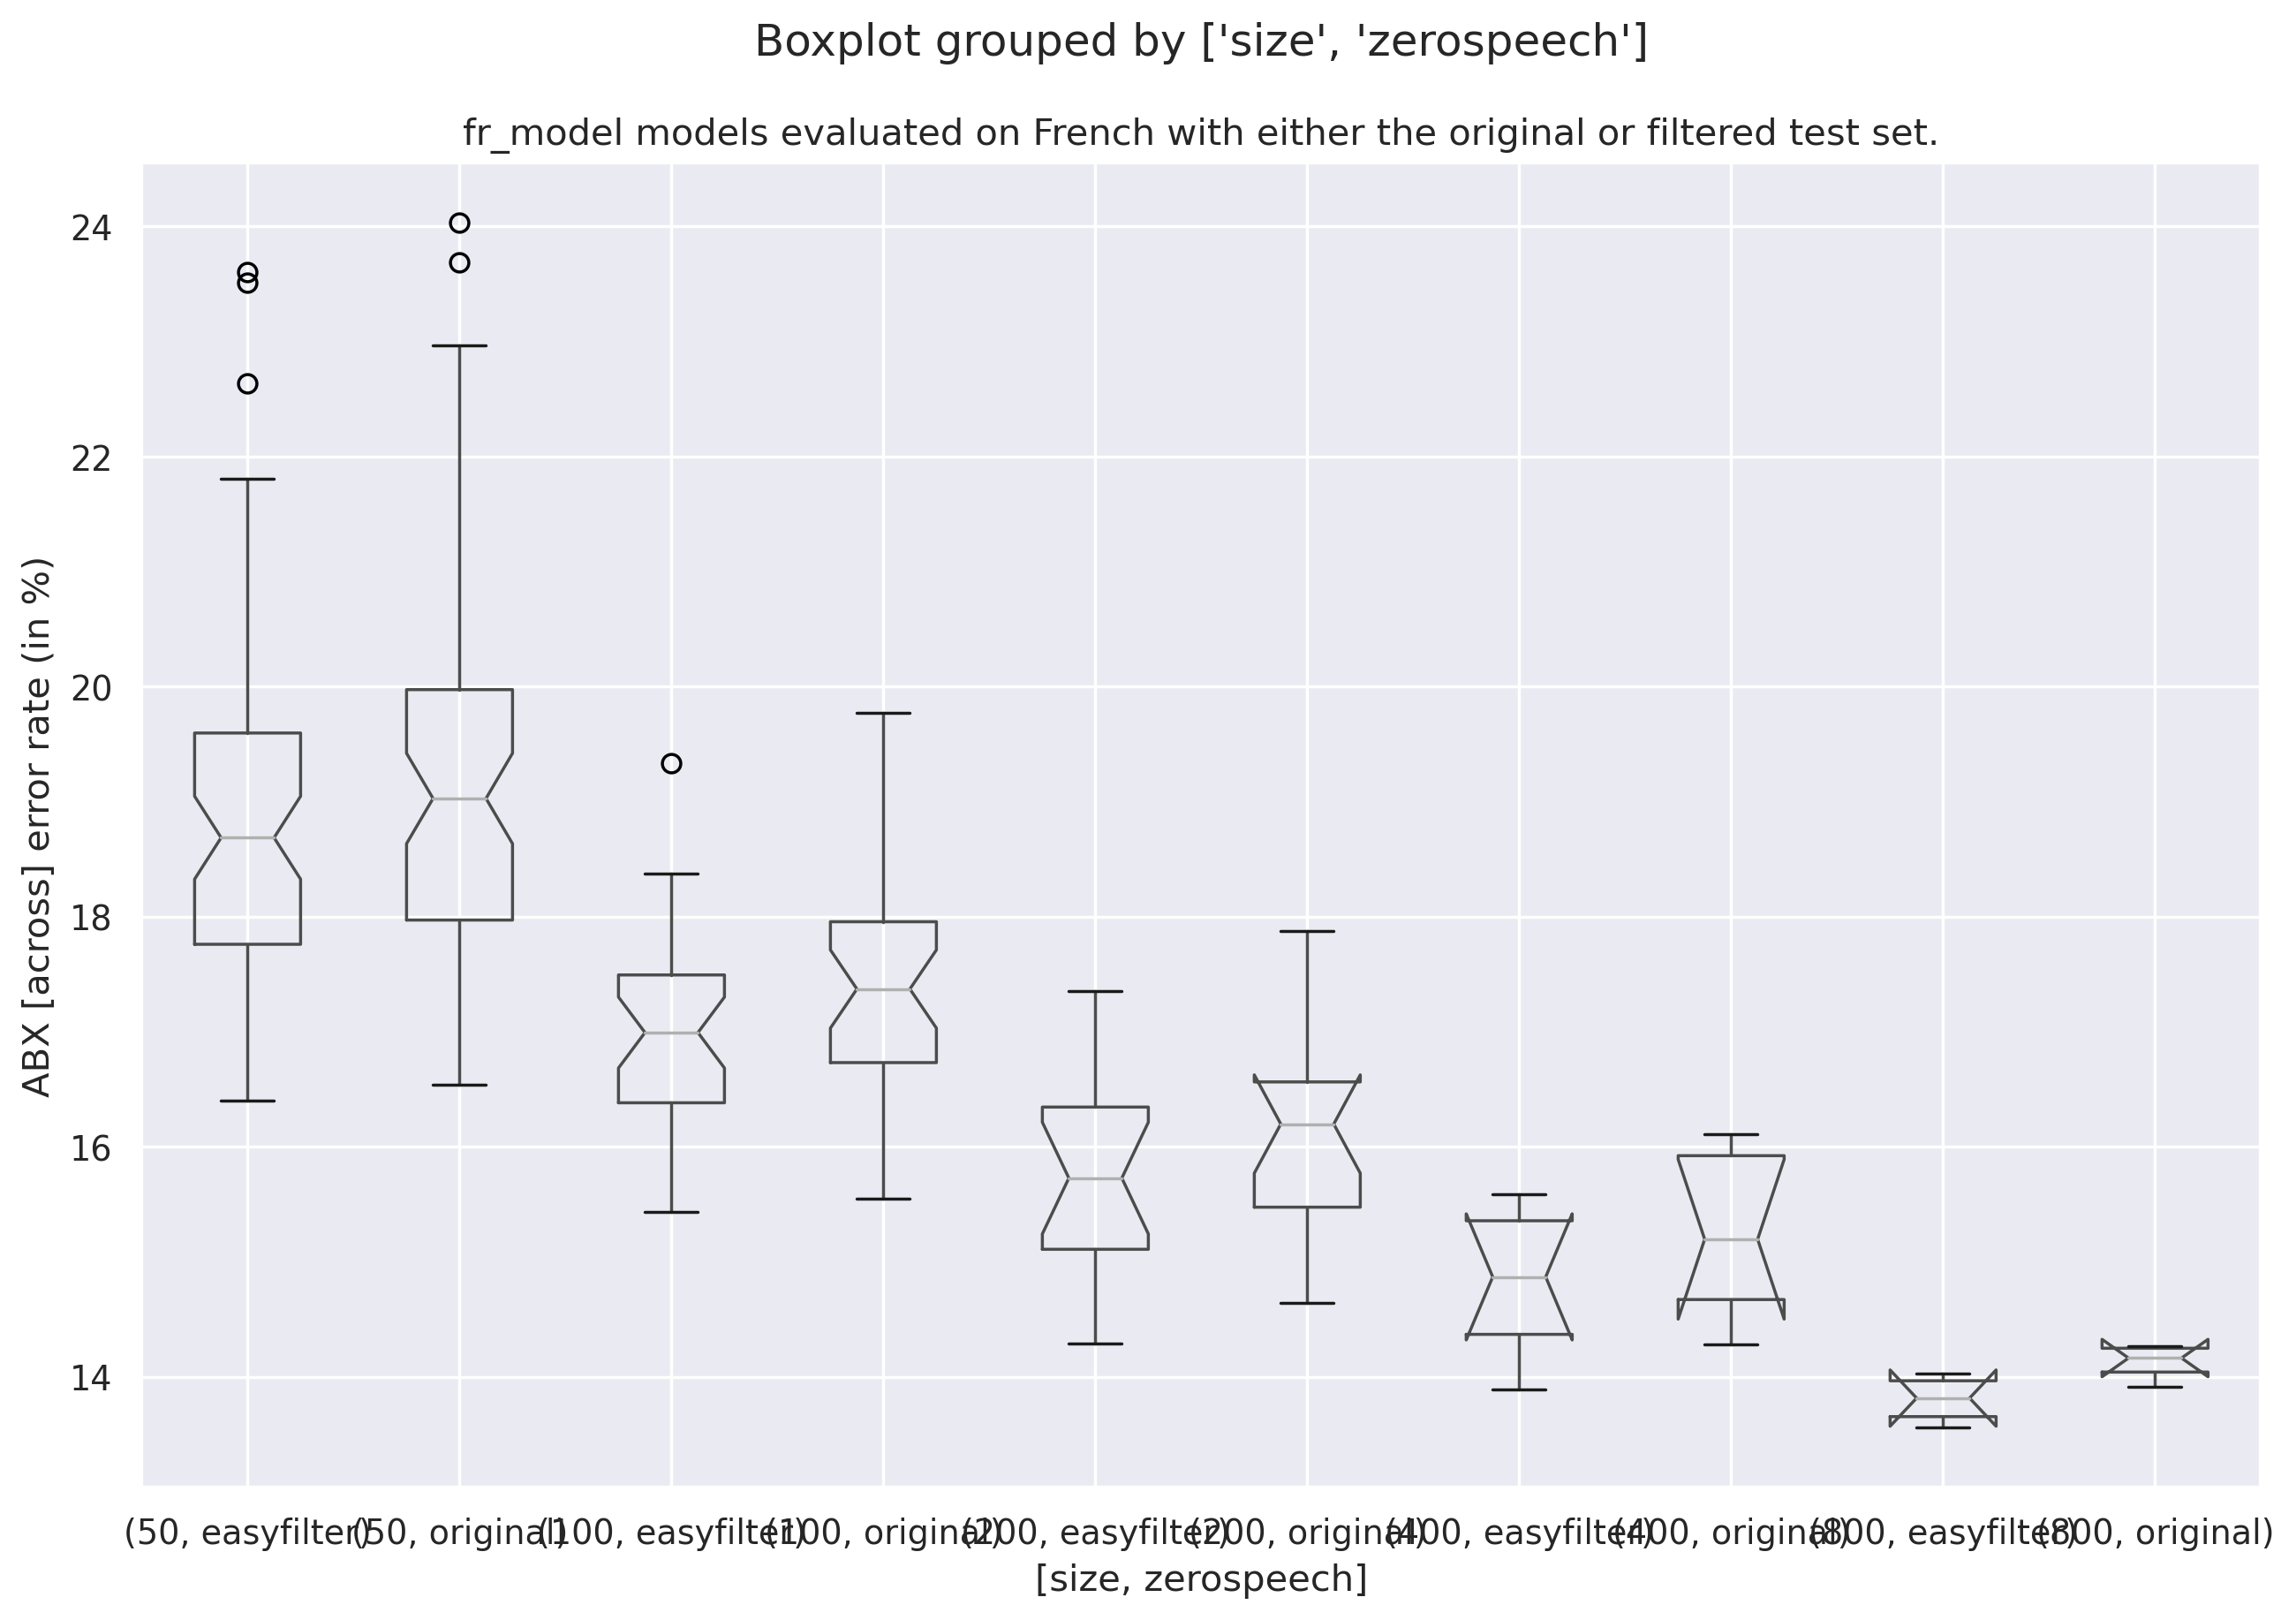

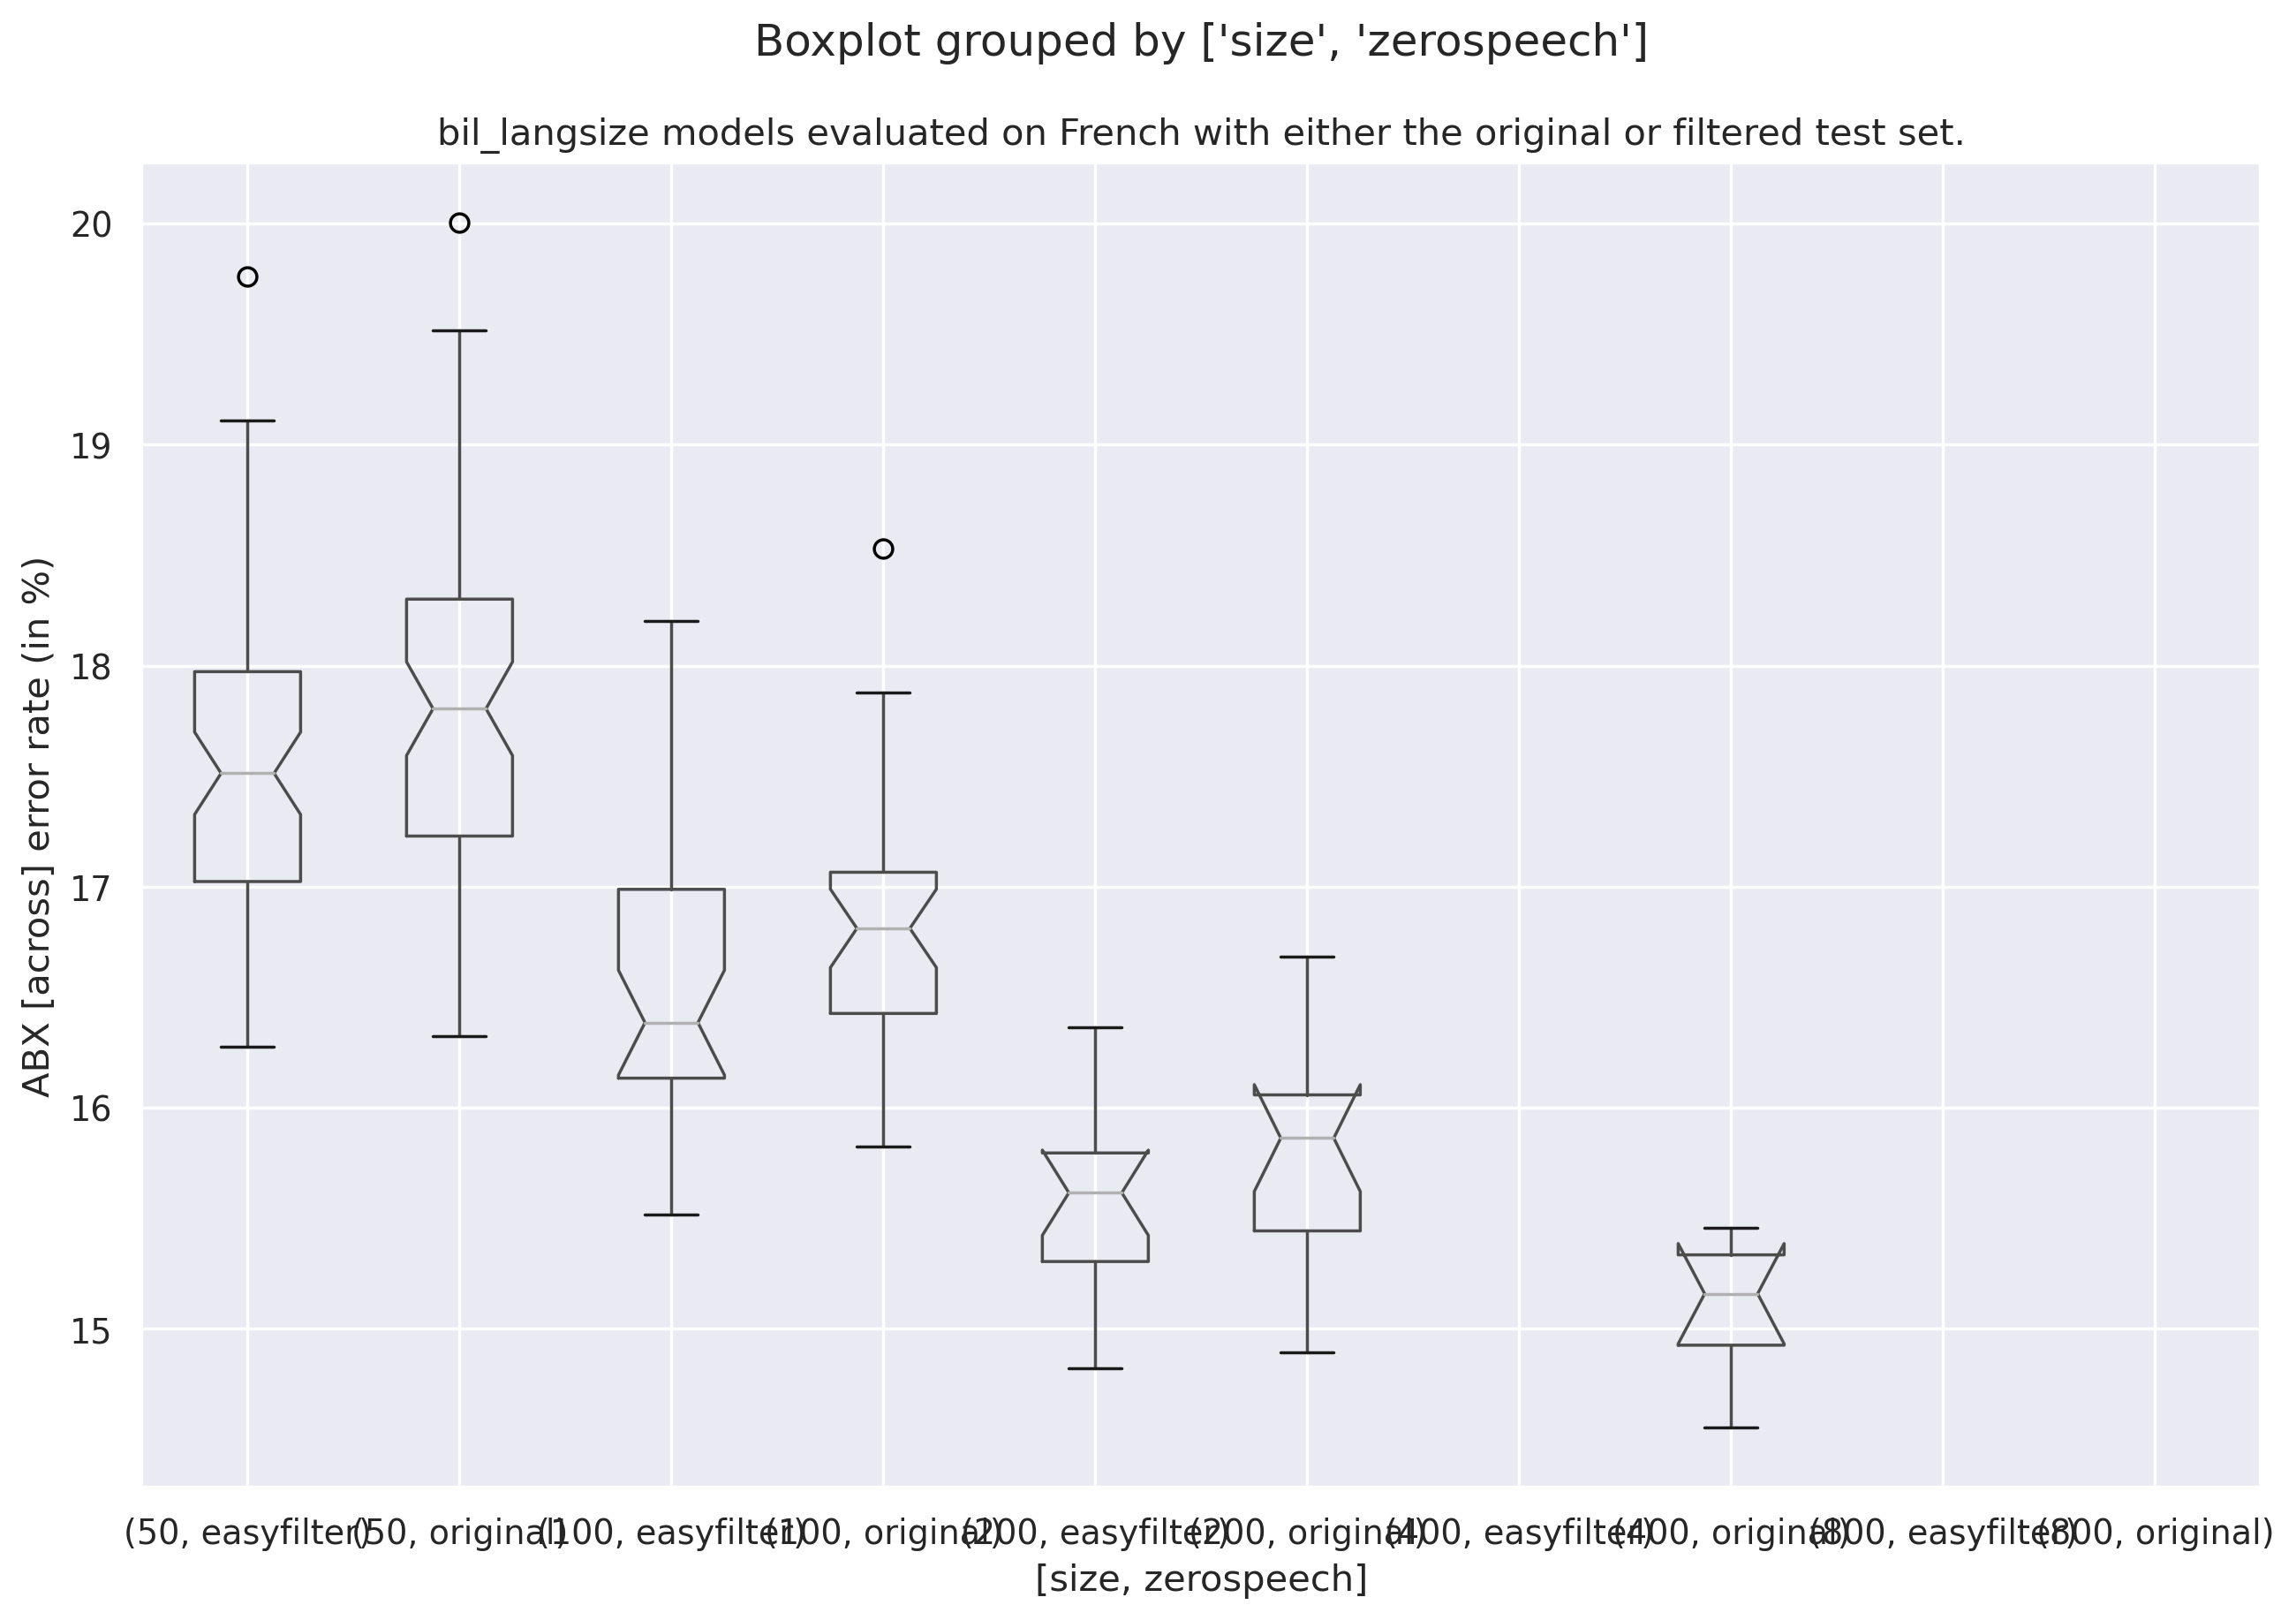

In [20]:

tmp_df = large_df_across[large_df_across['eval_lang'] == "french"]


for mtype in 'en_model', 'fr_model', 'bil_langsize':
    boxplot = tmp_df[['size','en_model', 'fr_model', 'bil_langsize',  'eval_lang', 'zerospeech']].boxplot(notch=True,column=mtype, by=[ 'size', 'zerospeech'], return_type='axes')
    plt.title("{} models evaluated on French with either the original or filtered test set.".format(mtype))
    plt.ylabel('ABX [across] error rate (in %)')
#for bp in boxplot: 
#    bp.set_ylabel('ABX error rate (in %)')
#    bp.set_xlabel('# training hours')


## C. Comparing Monolingual vs Bilingual ABX scores 



### C1. French vs English vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')

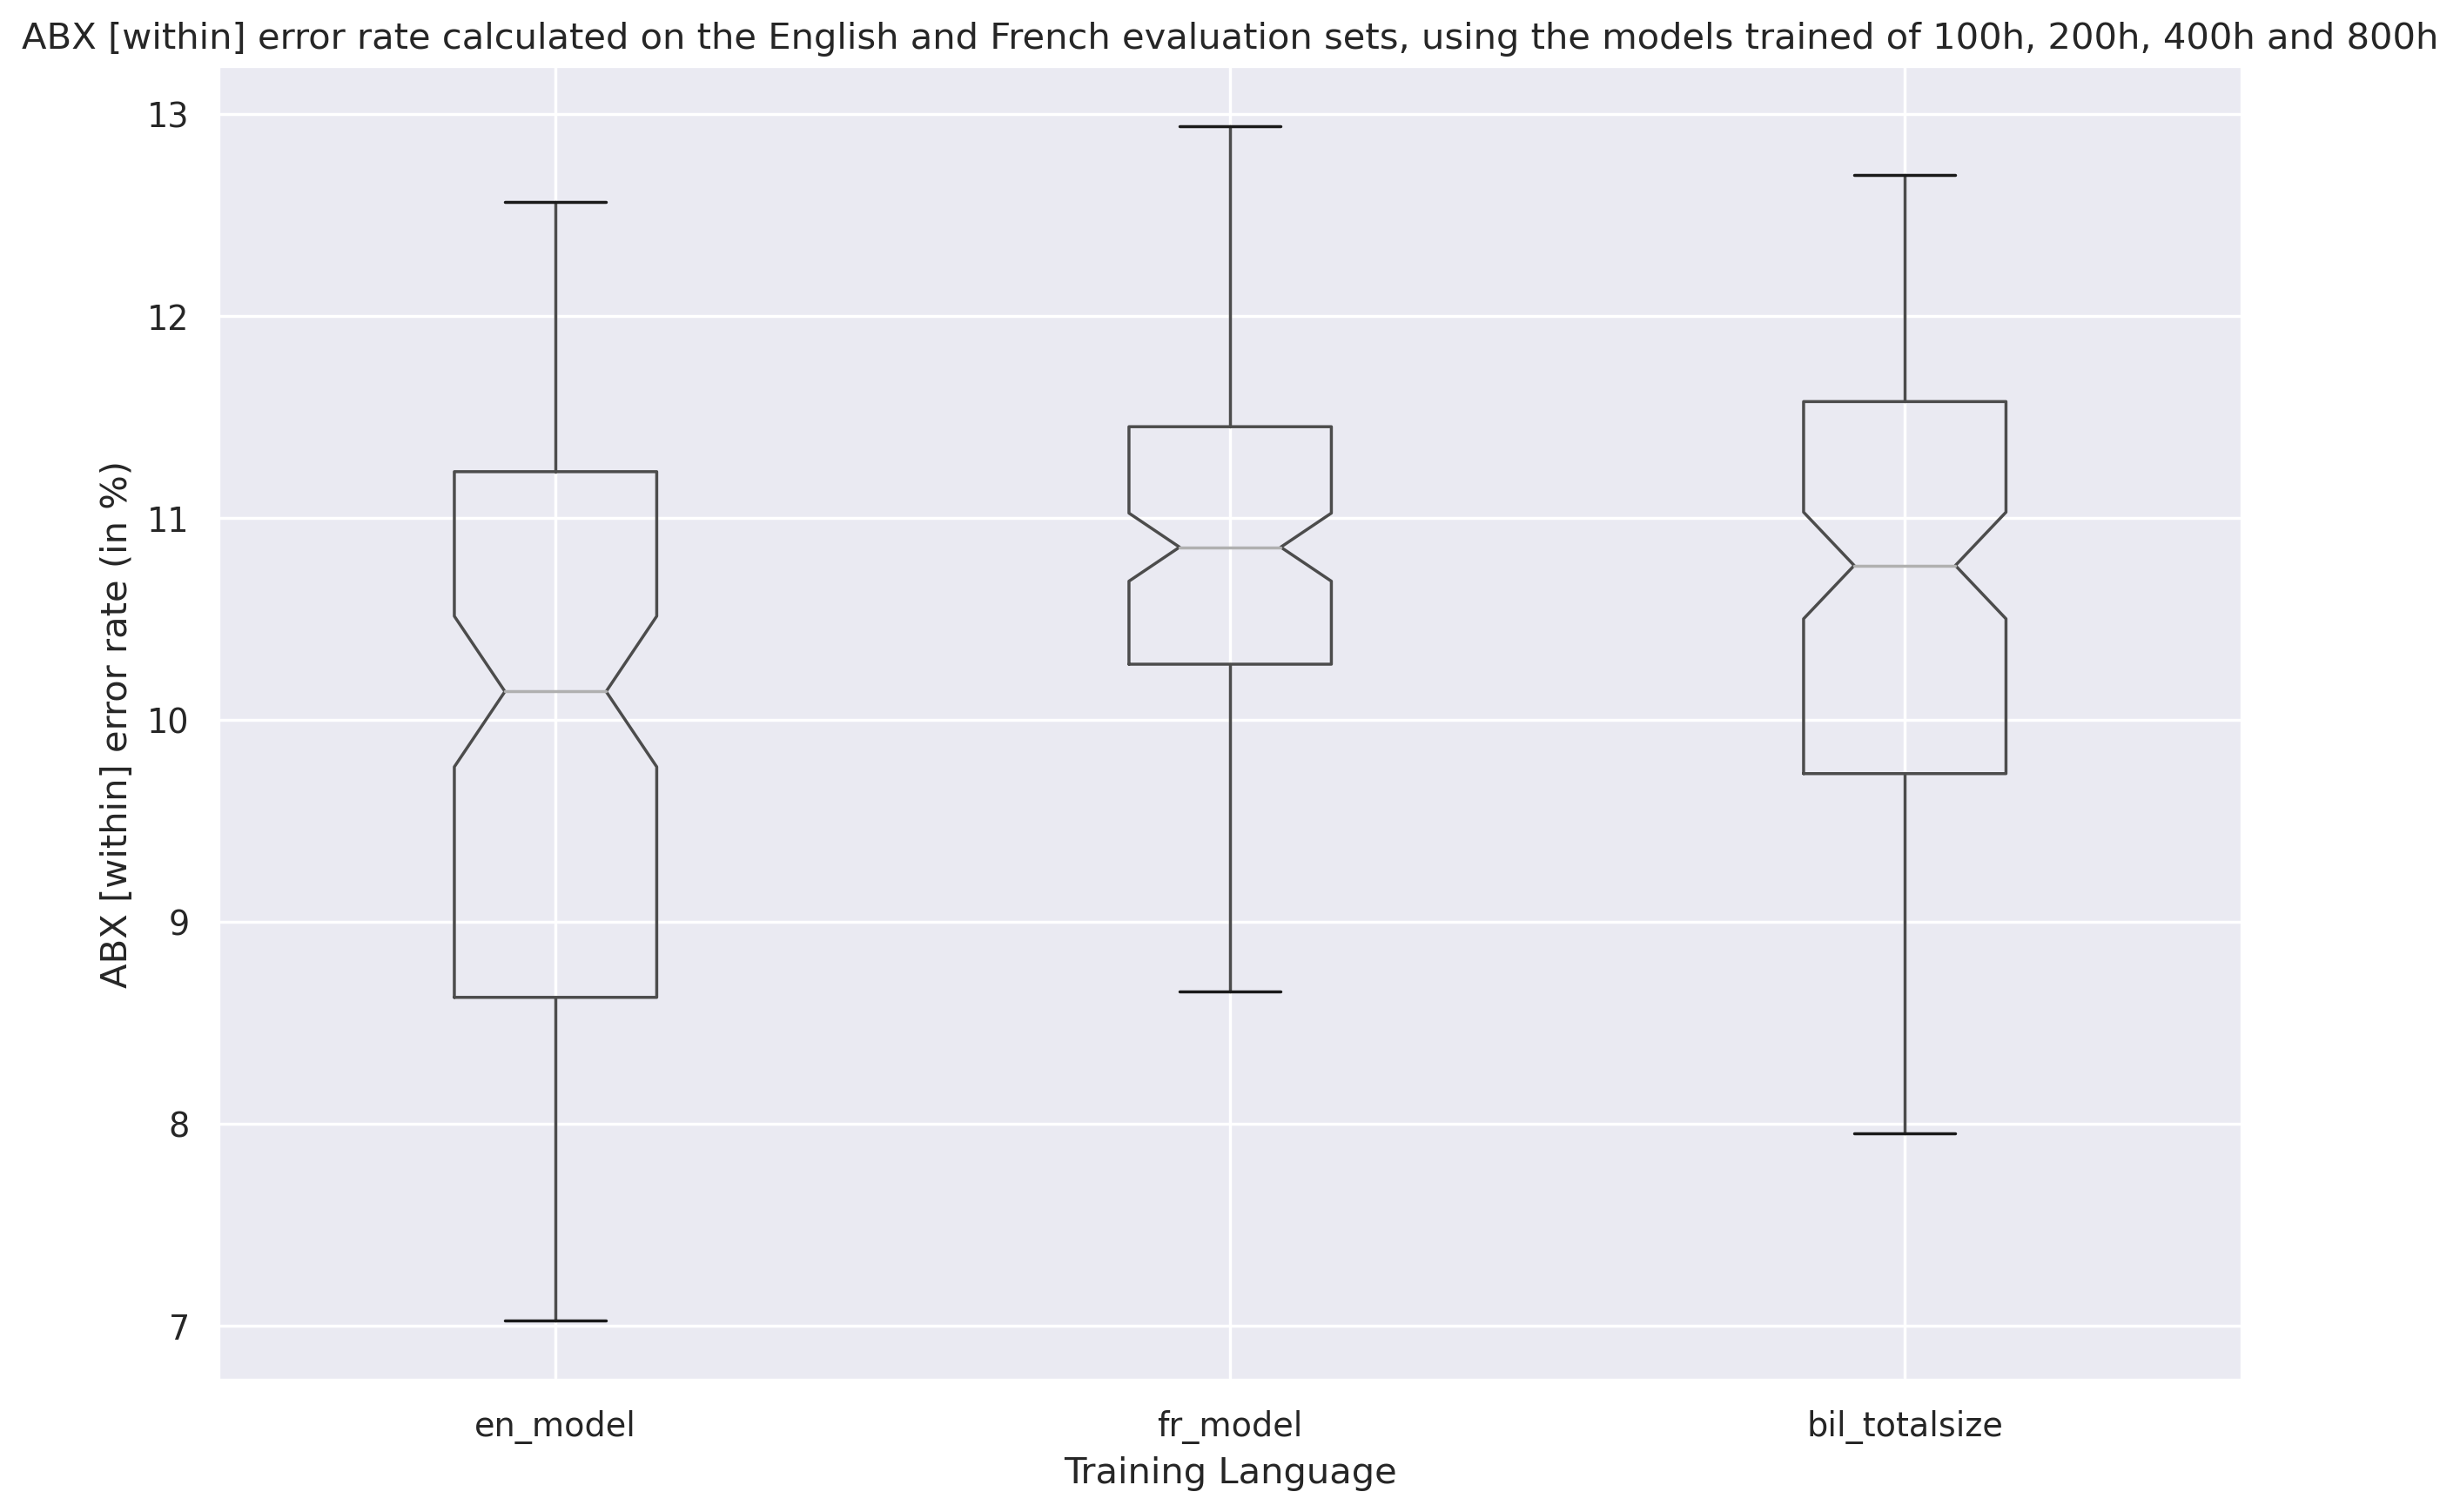

In [29]:
boxplot = df_within[['en_model', 'fr_model', 'bil_totalsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')



### C2. Monolingual vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')

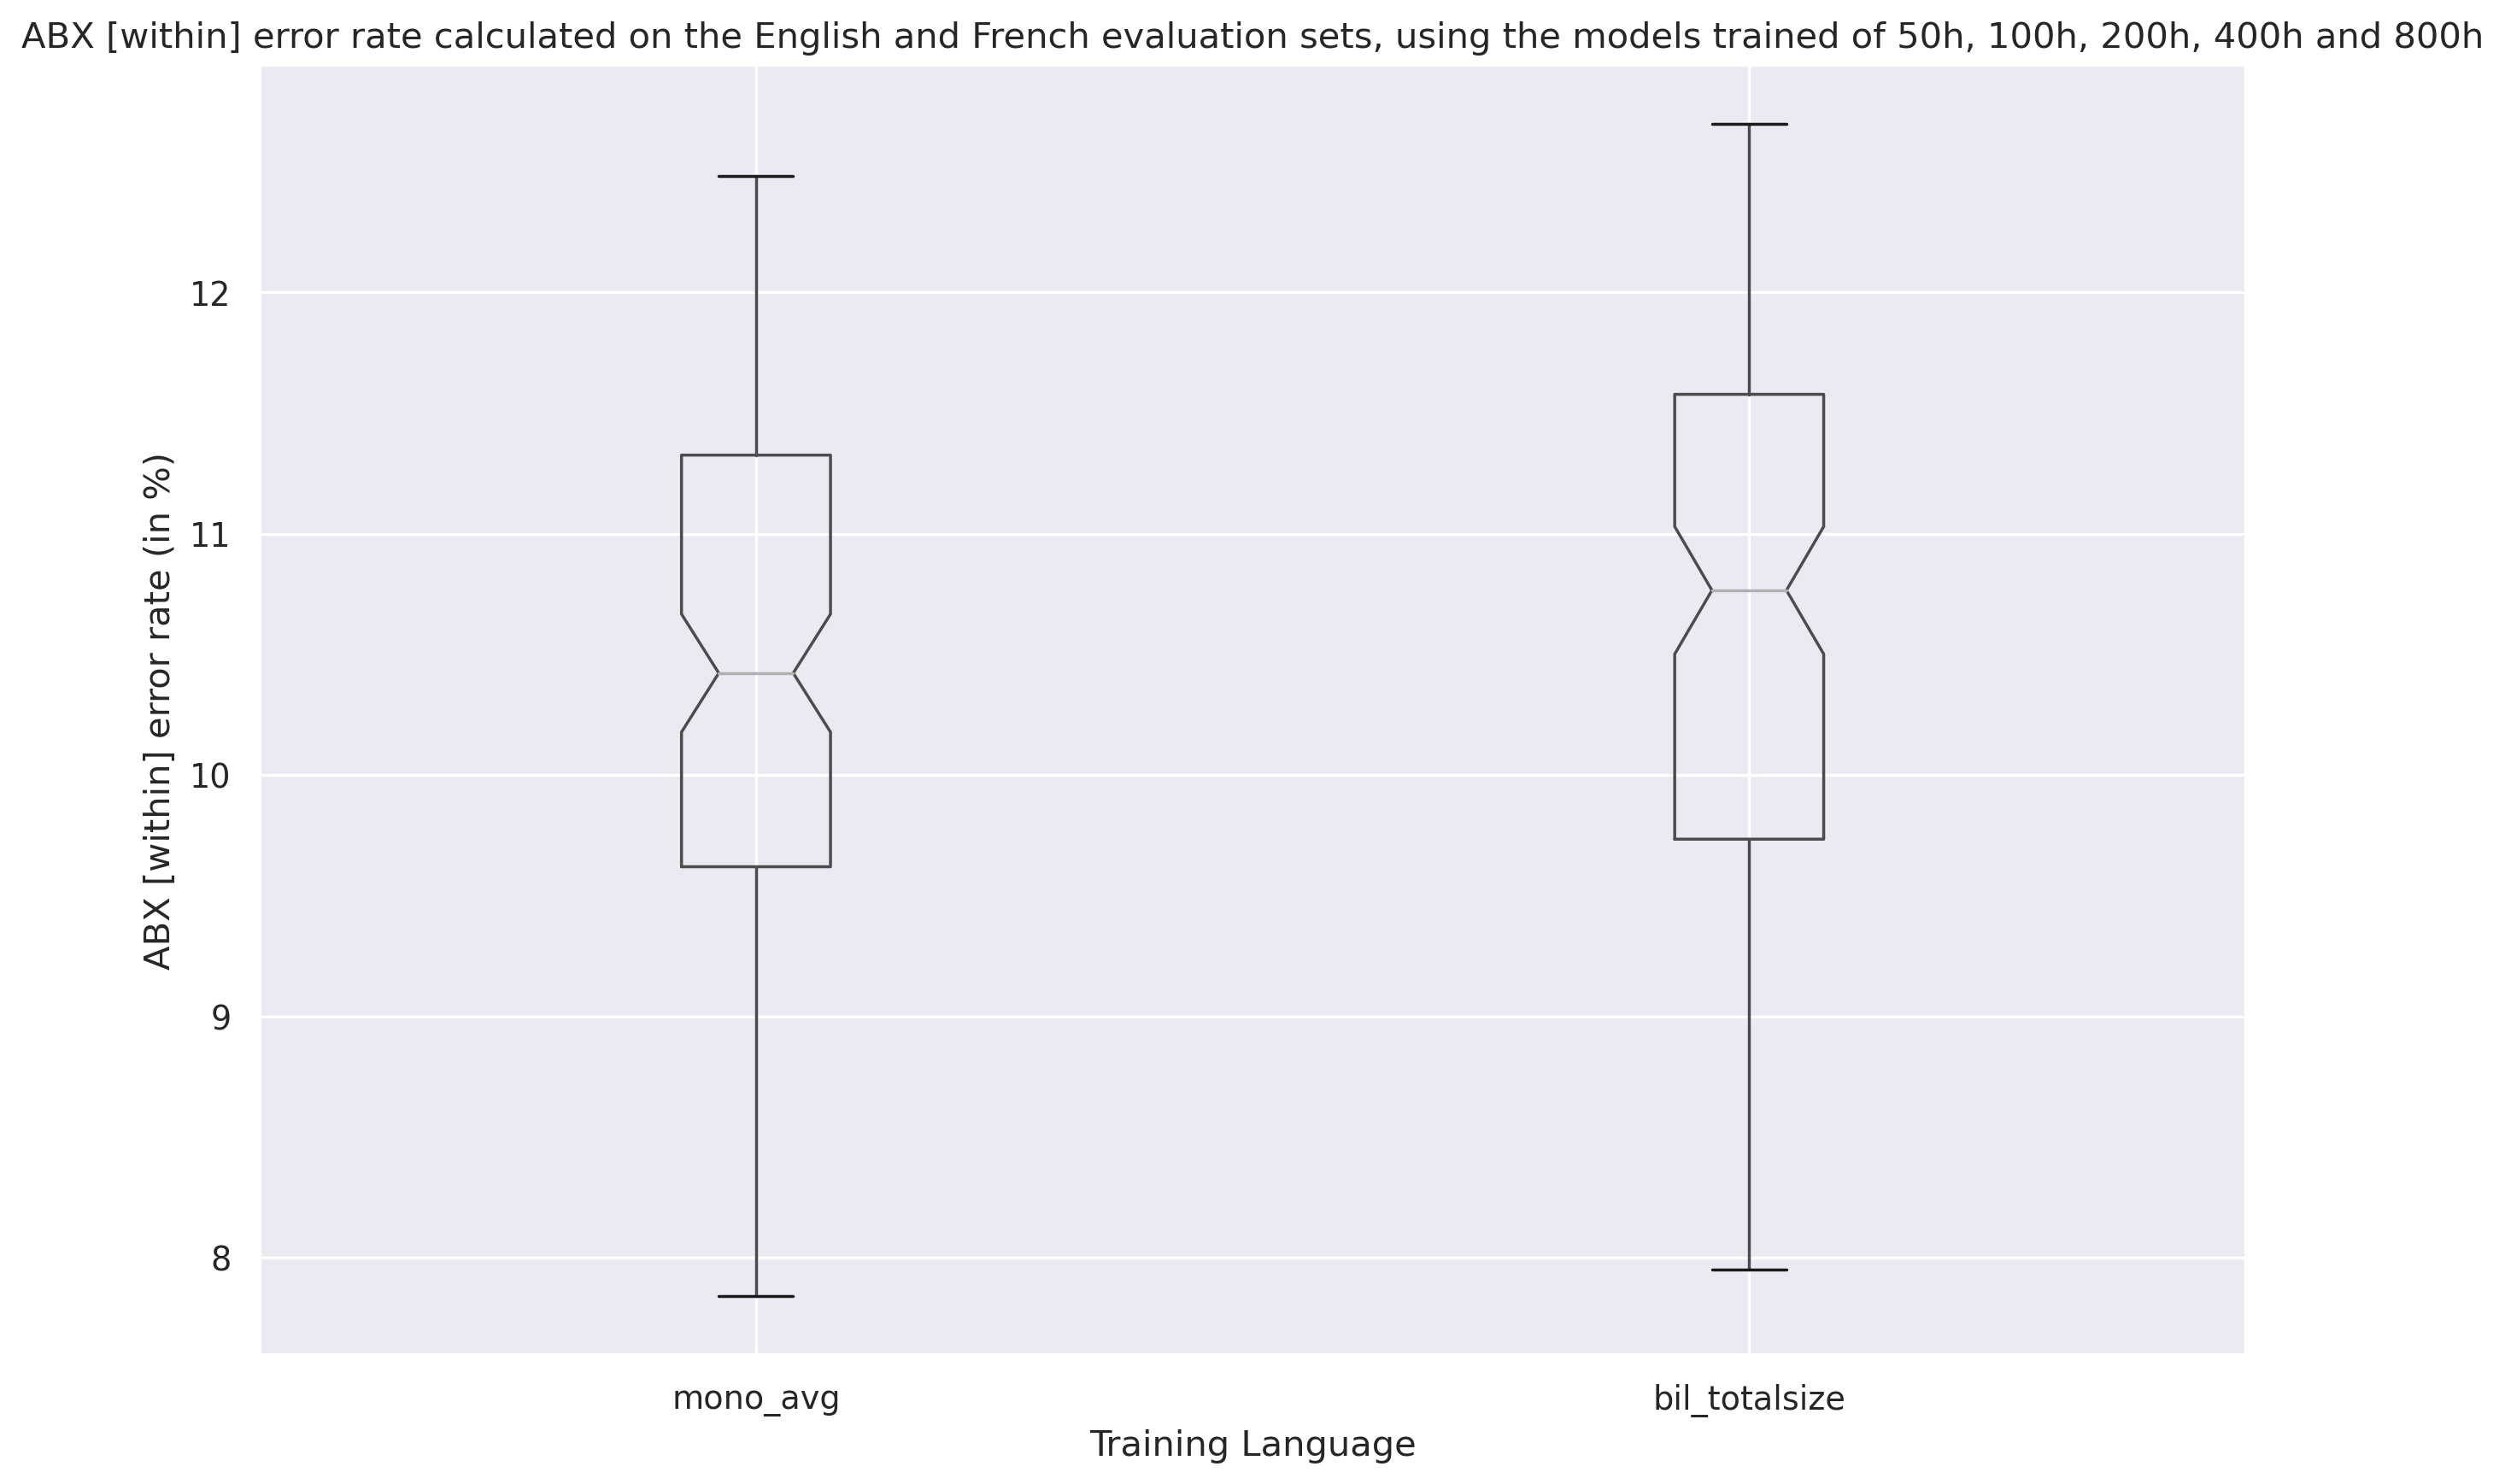

In [36]:
boxplot = df_within[['mono_avg', 'bil_totalsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')



### C3. Monolingual vs Bilingual LangSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the largest dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')

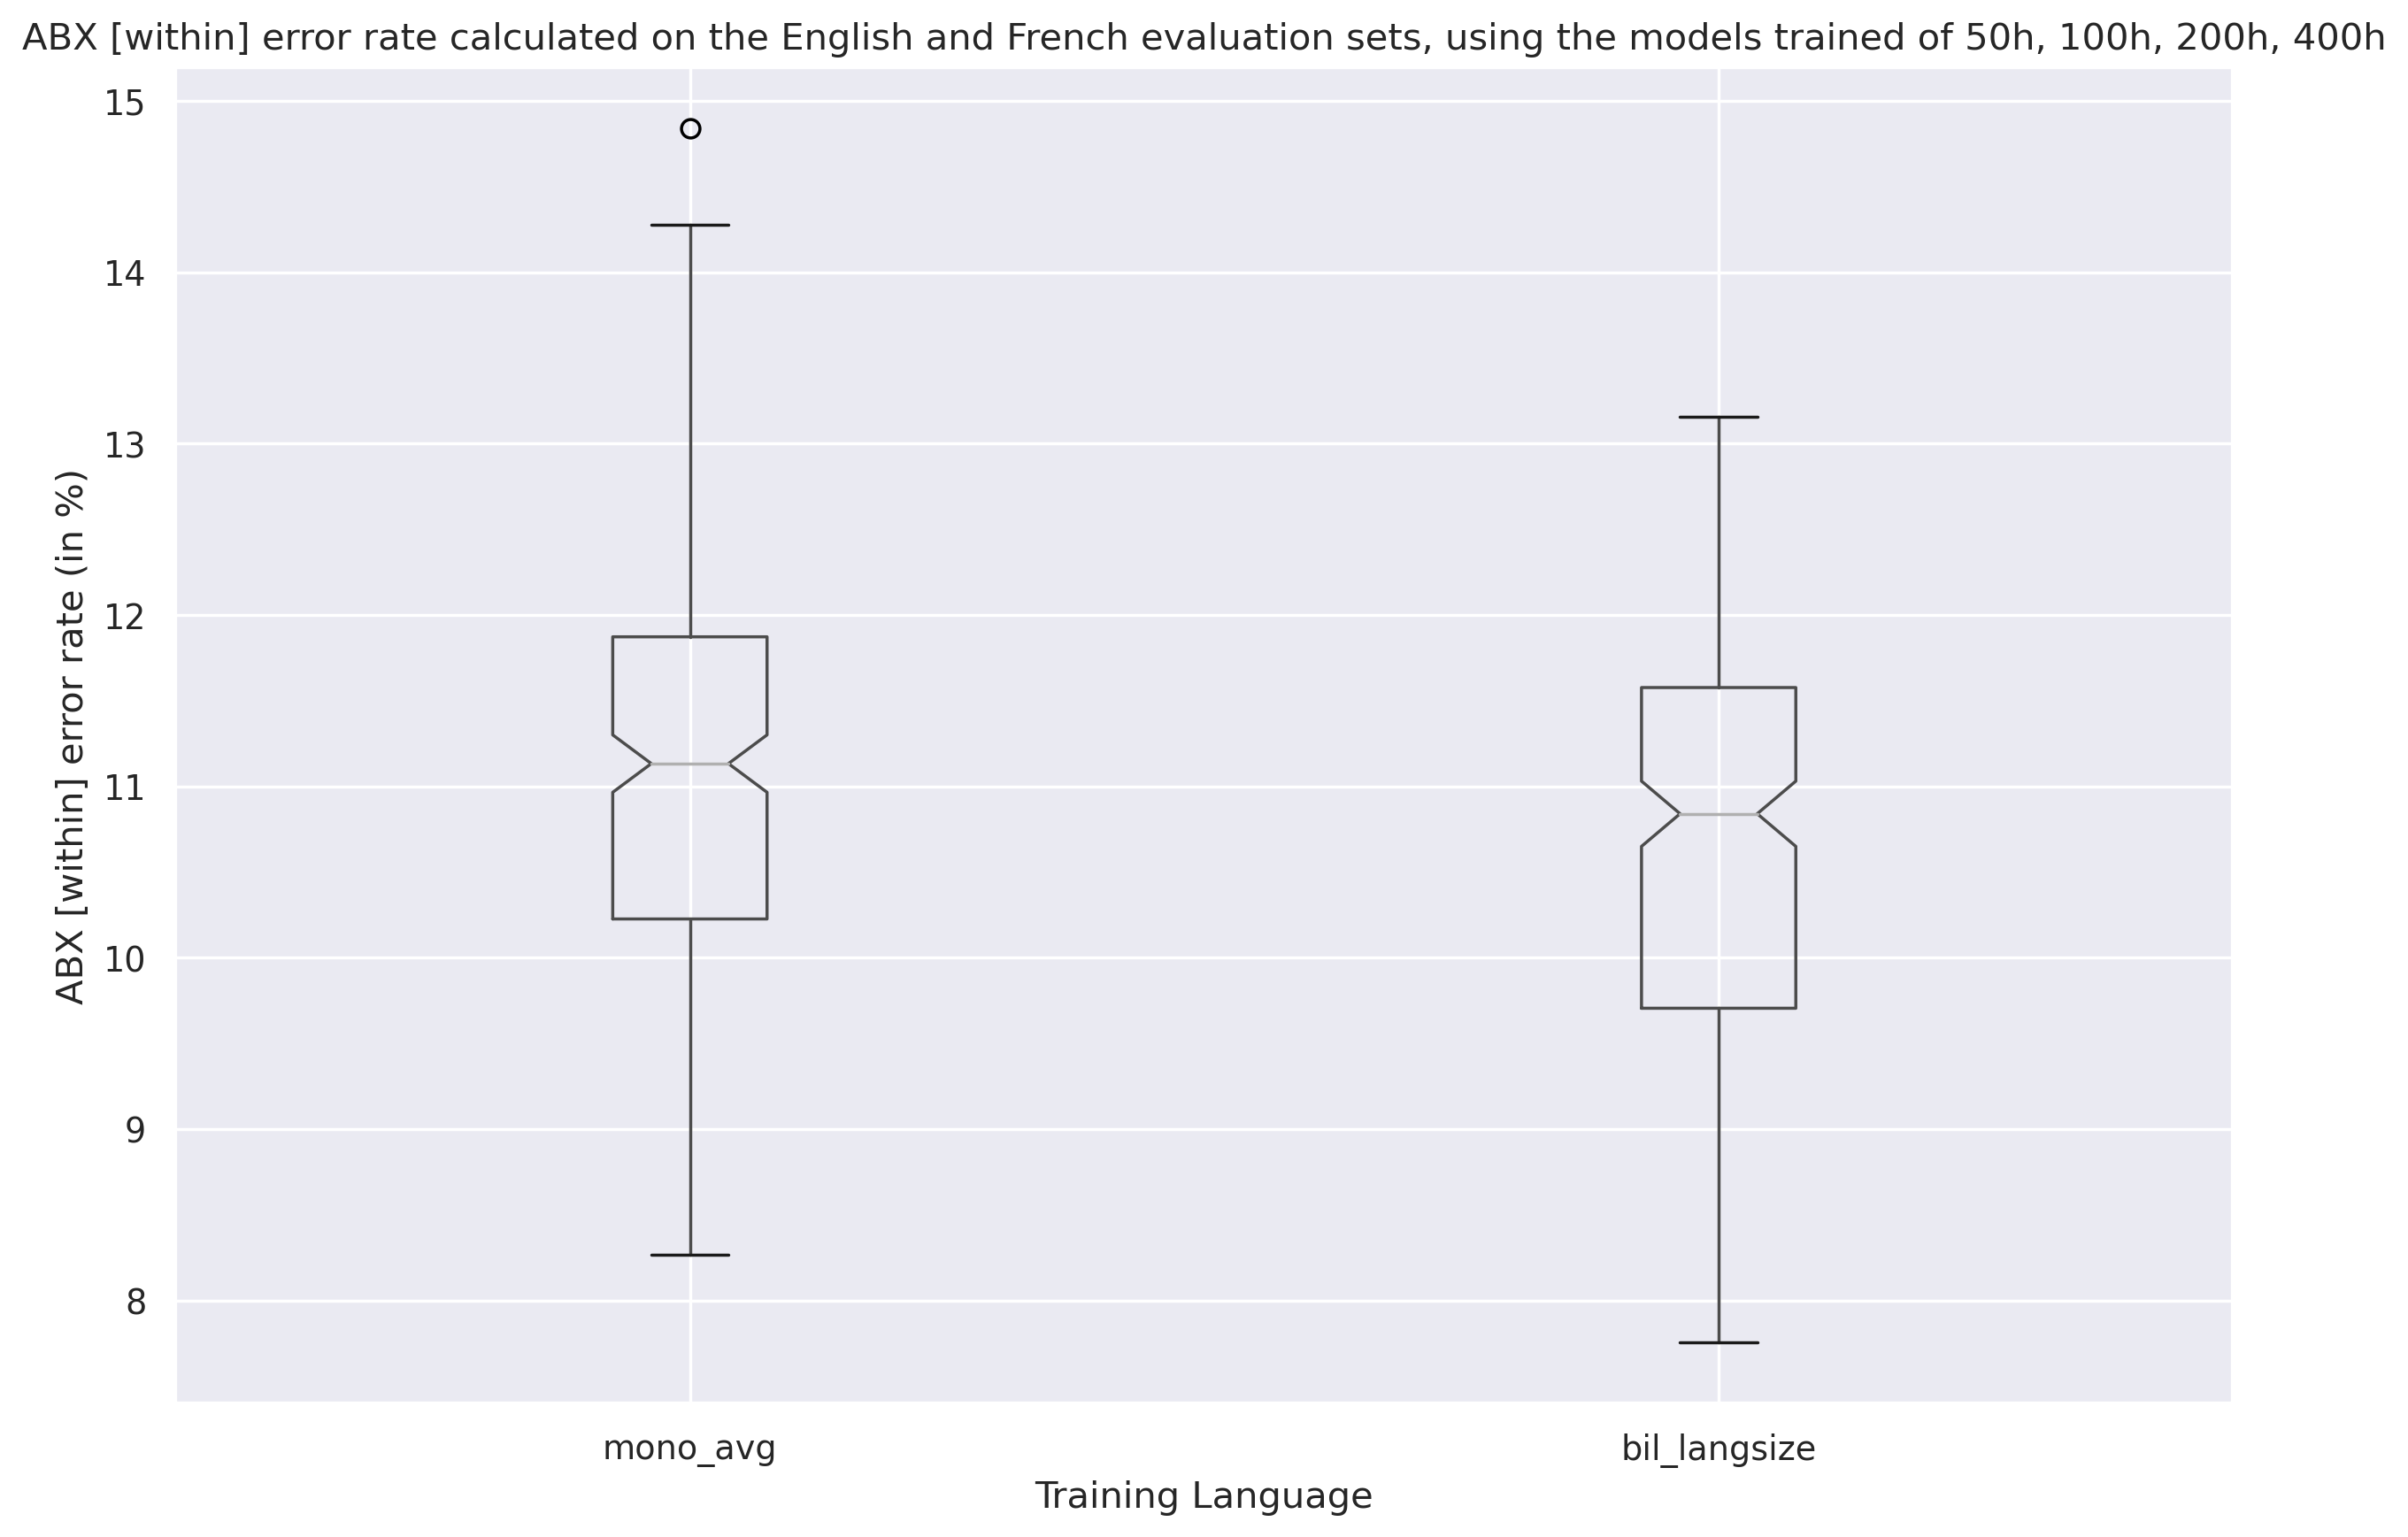

In [37]:
boxplot = df_within[['mono_avg', 'bil_langsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')



## D. Developmental graphs

In [38]:
style_dict =  {'same': 'go-', 'different': 'ro-', 'bil_totalsize': 'bo:', 'bil_langsize':'co:', 'en_model' : 'go--', 'fr_model' : 'ro--', 'mono_avg':'wo-.'}


### D1. Developmental [within] ABX  on both test sets (original)

Text(0.5, 1.0, 'ABX [within] error rate depending on the model type and number of training hours')

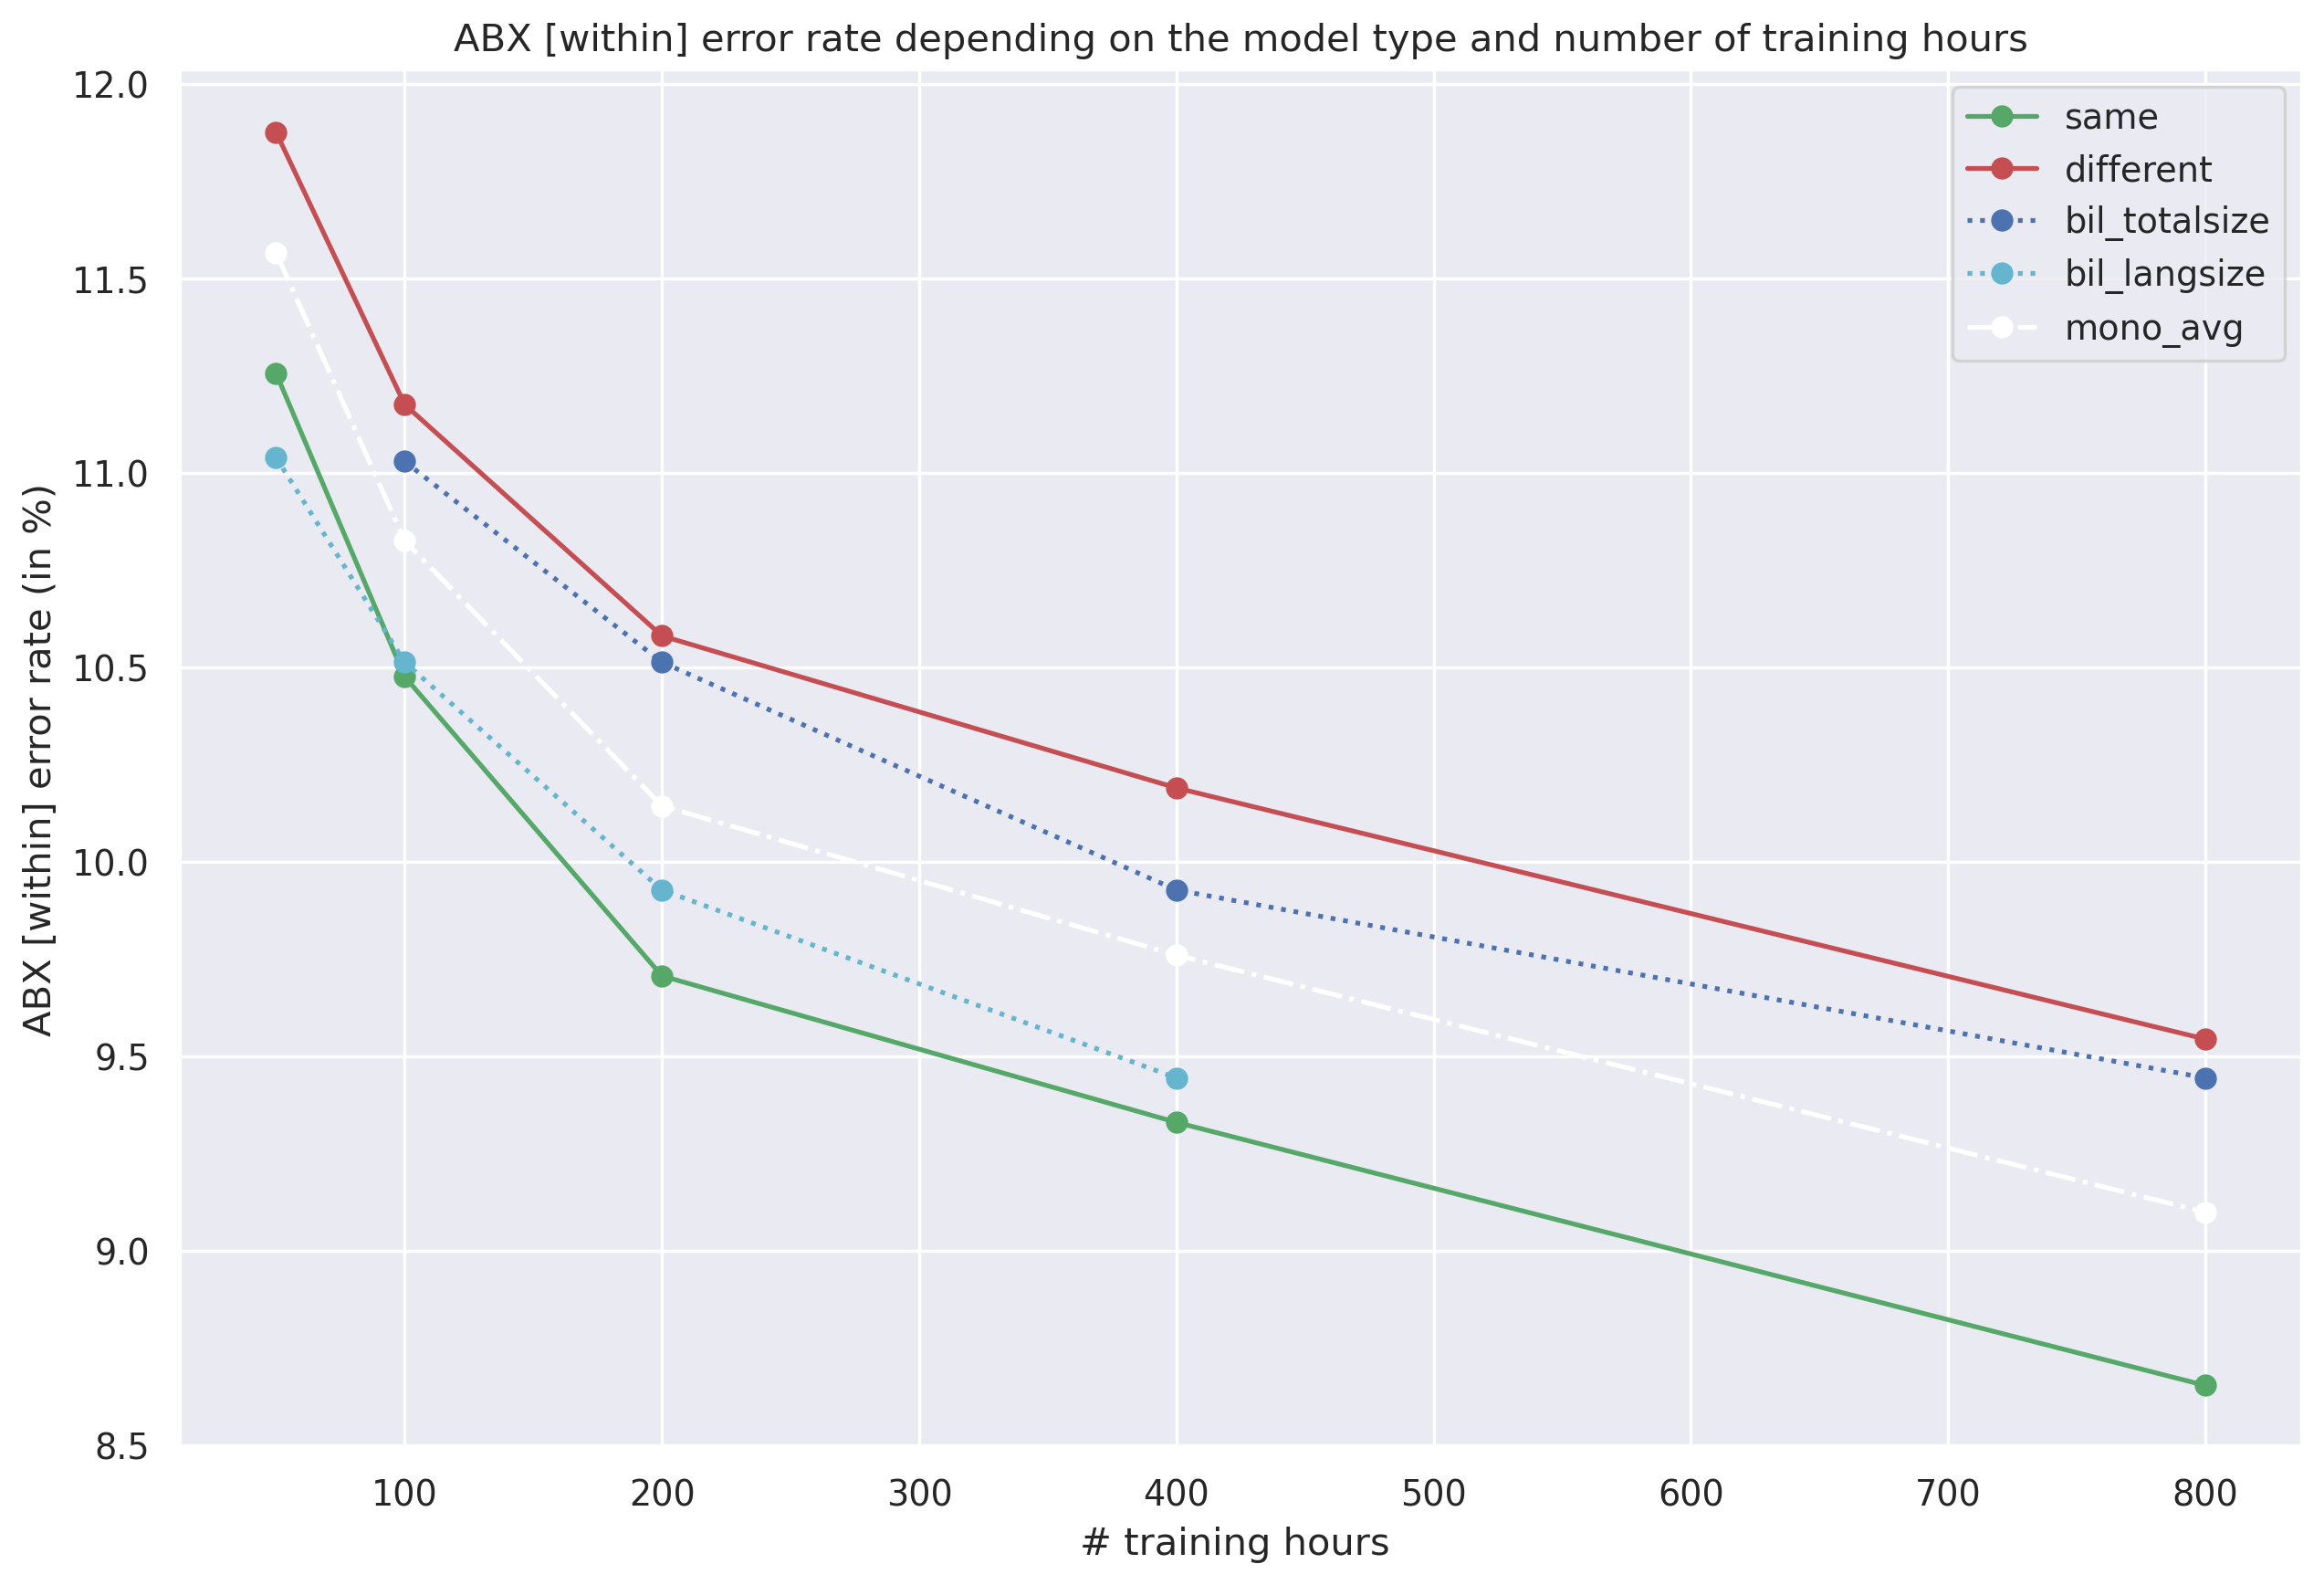

In [40]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours")

### D2. Developmental [within] ABX  on both test sets (QuickFix)

Text(0.5, 1.0, 'ABX error rate depending on the model type and number of training hours')

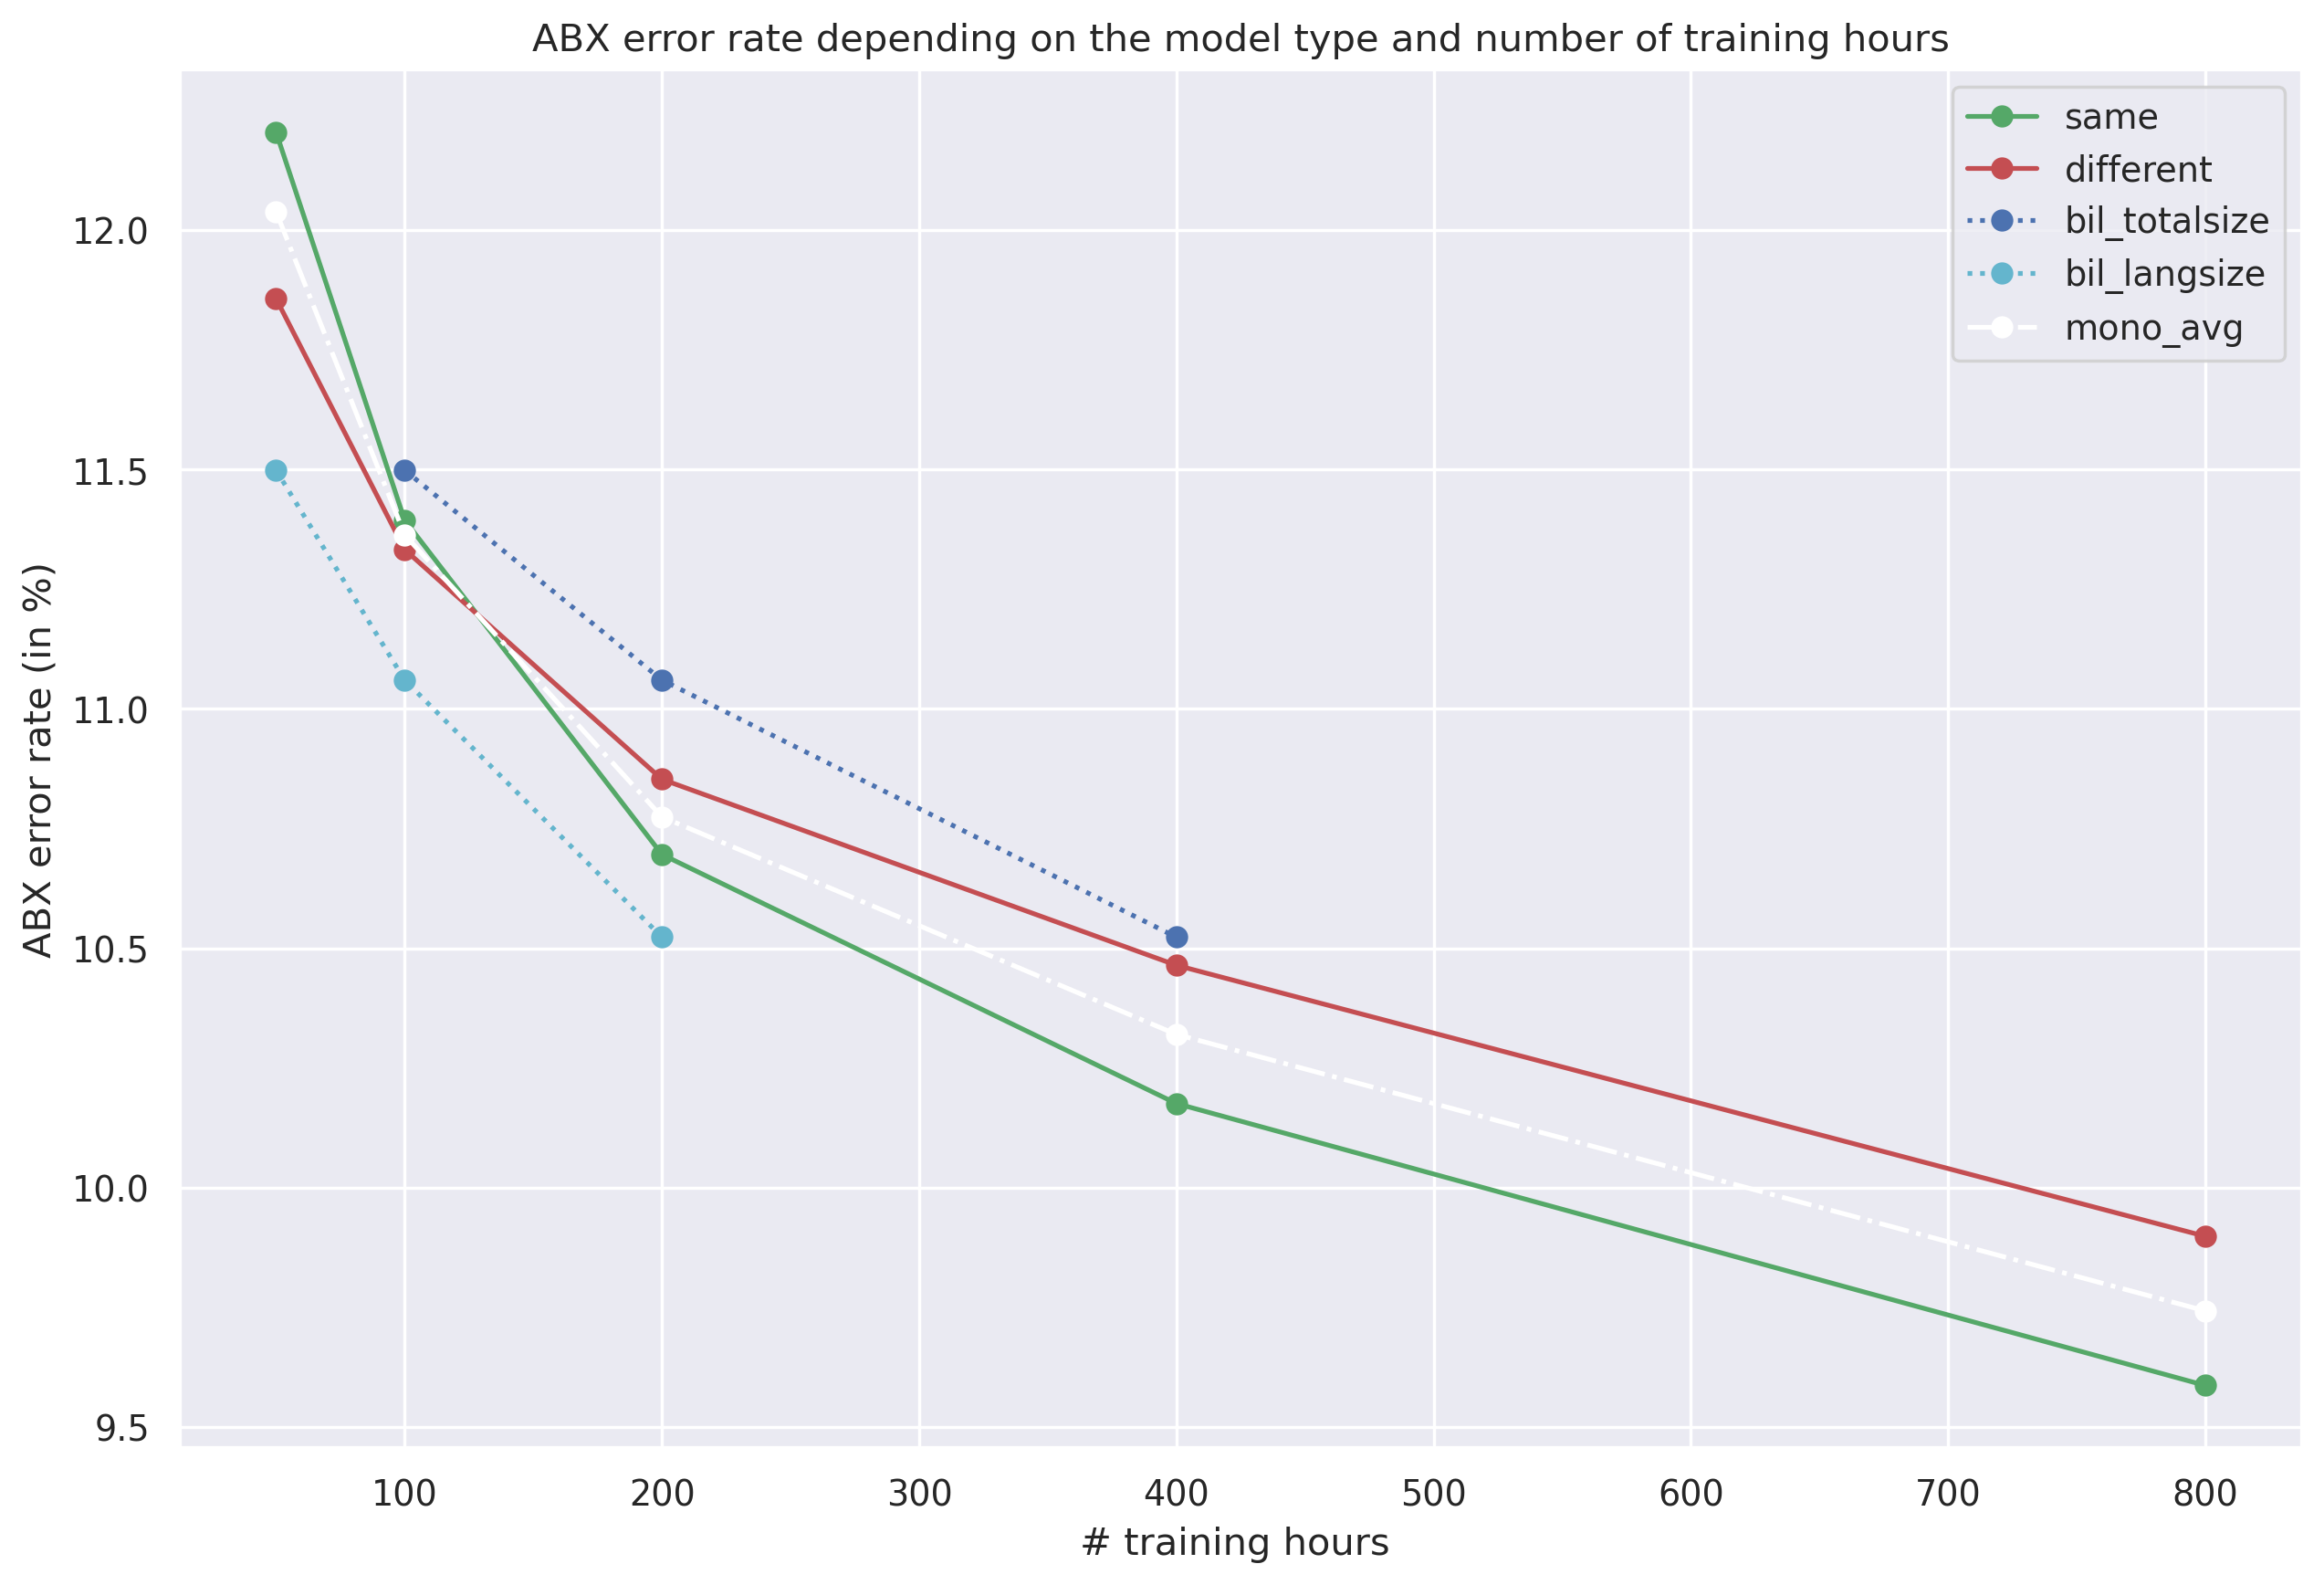

In [42]:
df_ef_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.xlabel('# training hours ')
plt.ylabel("ABX error rate (in %)")
plt.title("ABX error rate depending on the model type and number of training hours")

### D3a. Developmental [within] ABX  on the French test set (original and QuickFix)

Text(0.5, 1.0, 'ABX  [within] error rate on the FRENCH evaluation set (filtered)')

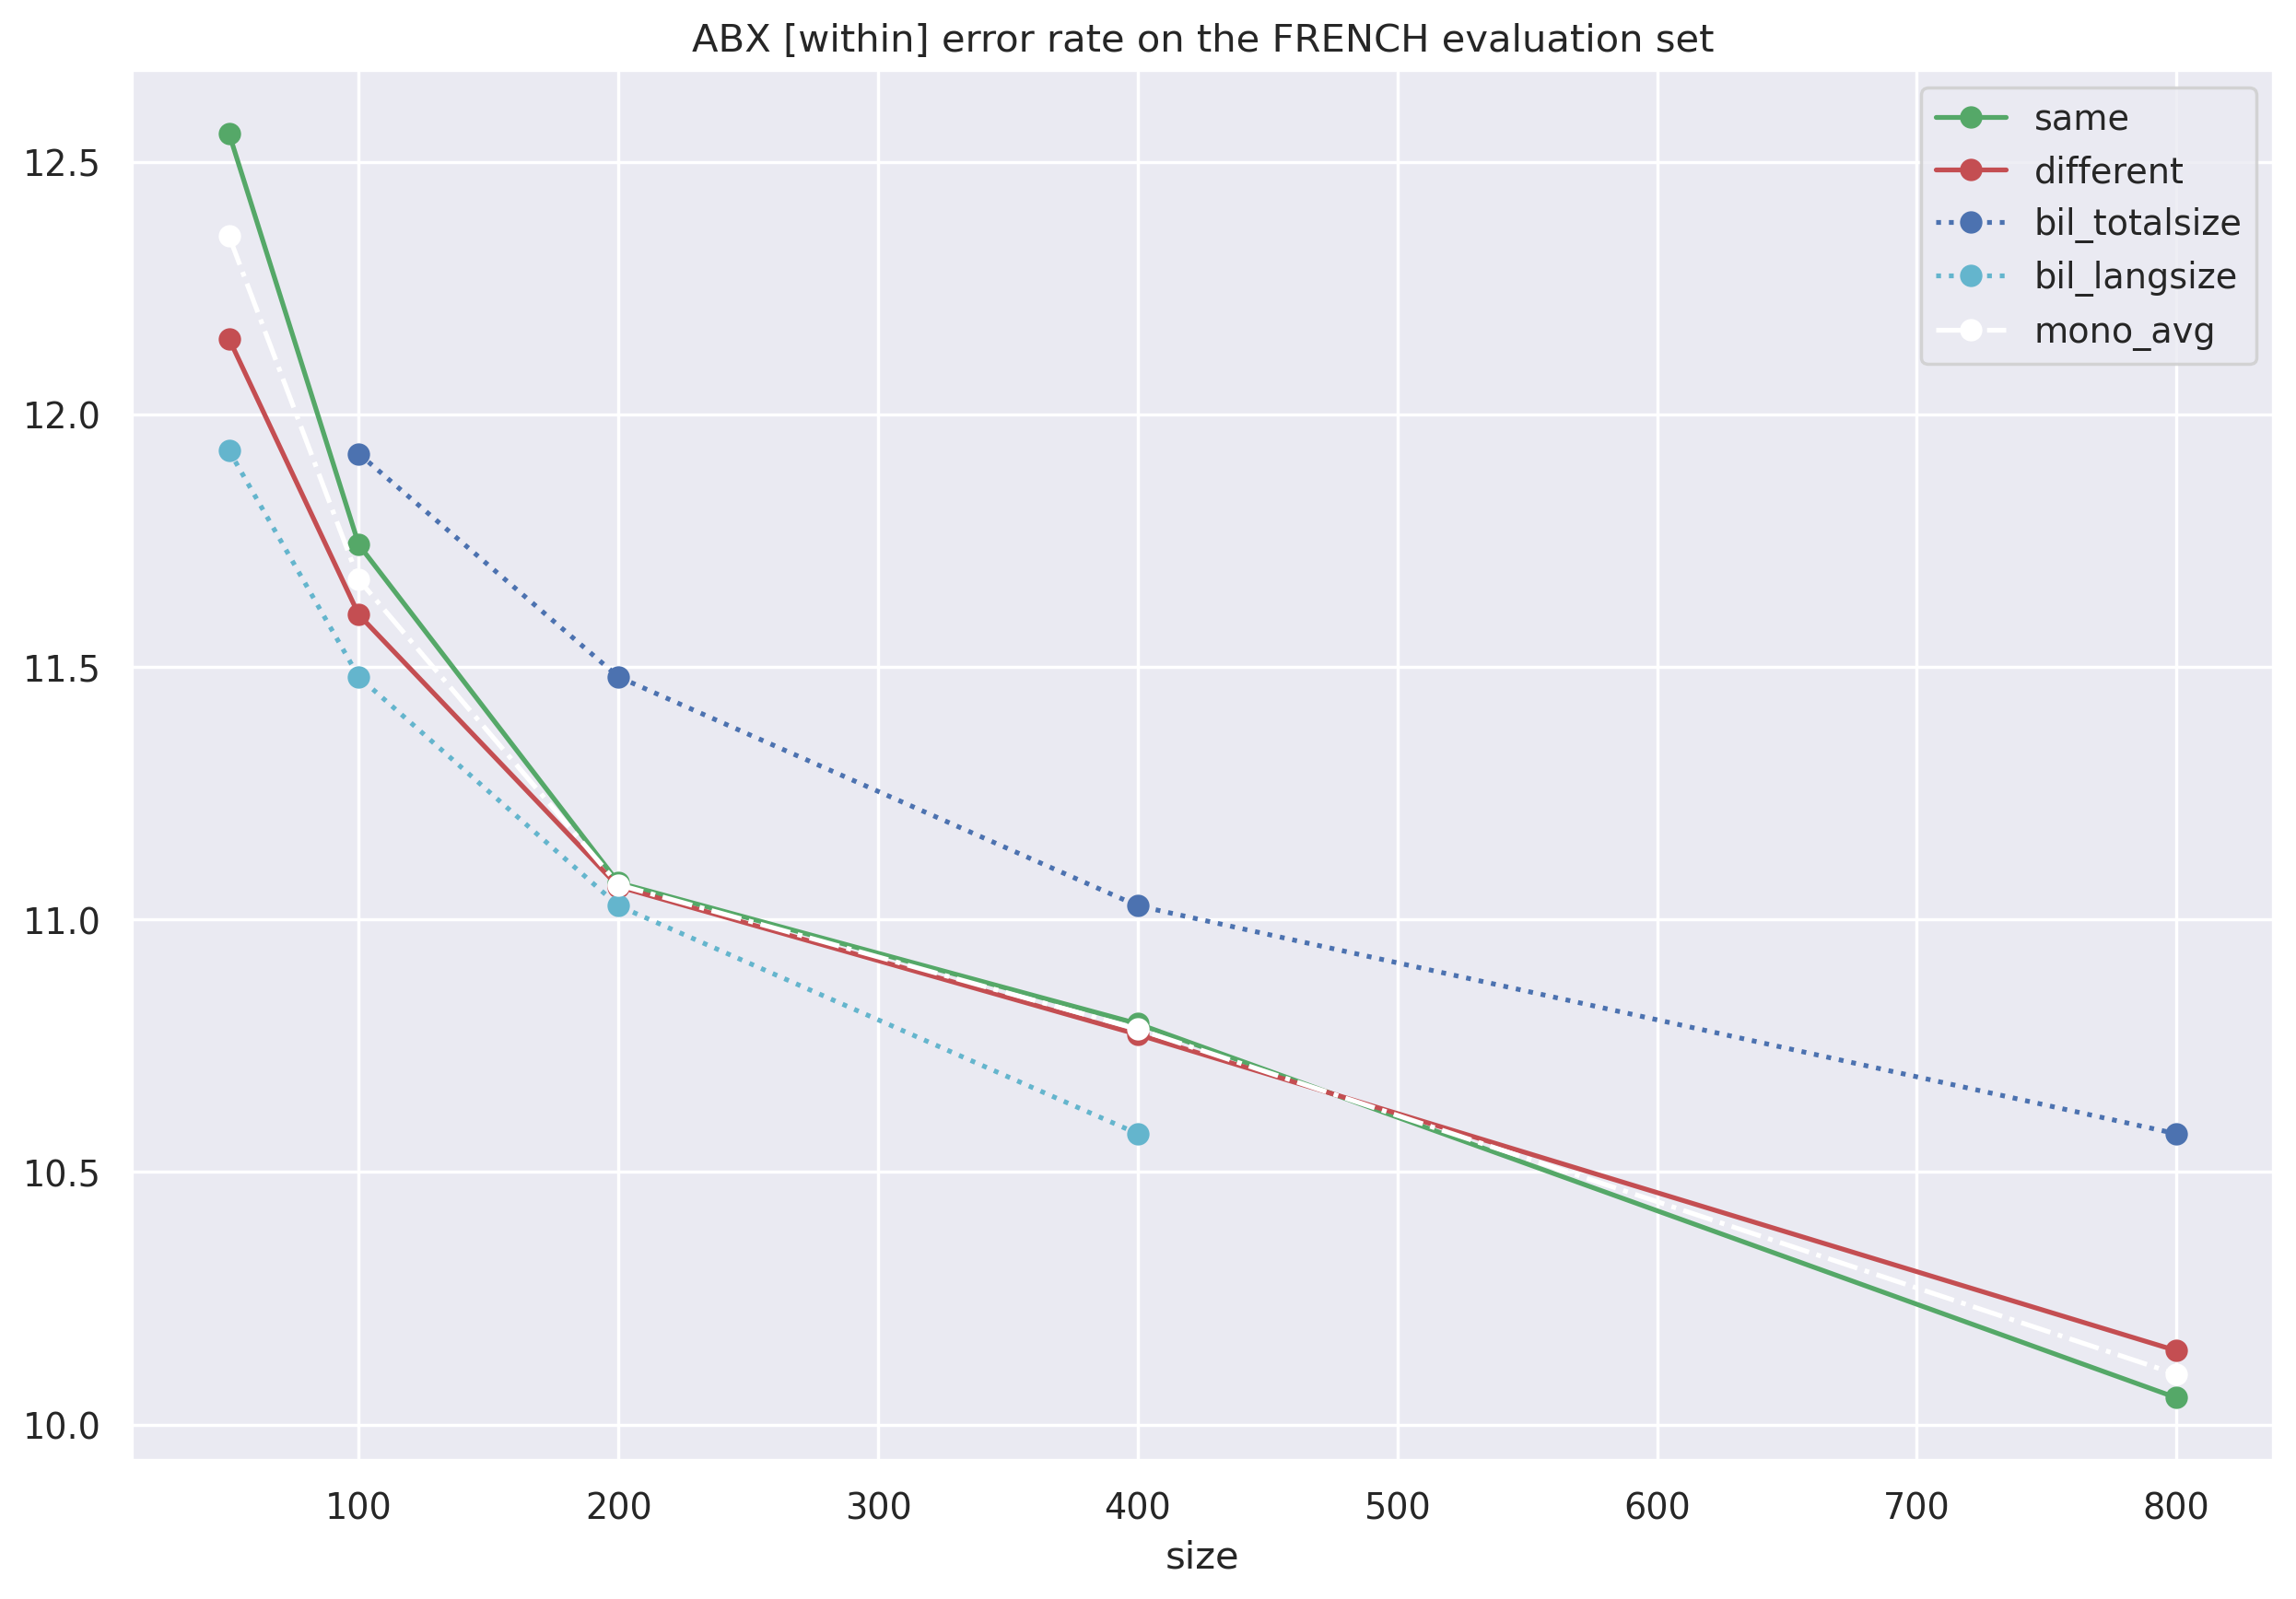

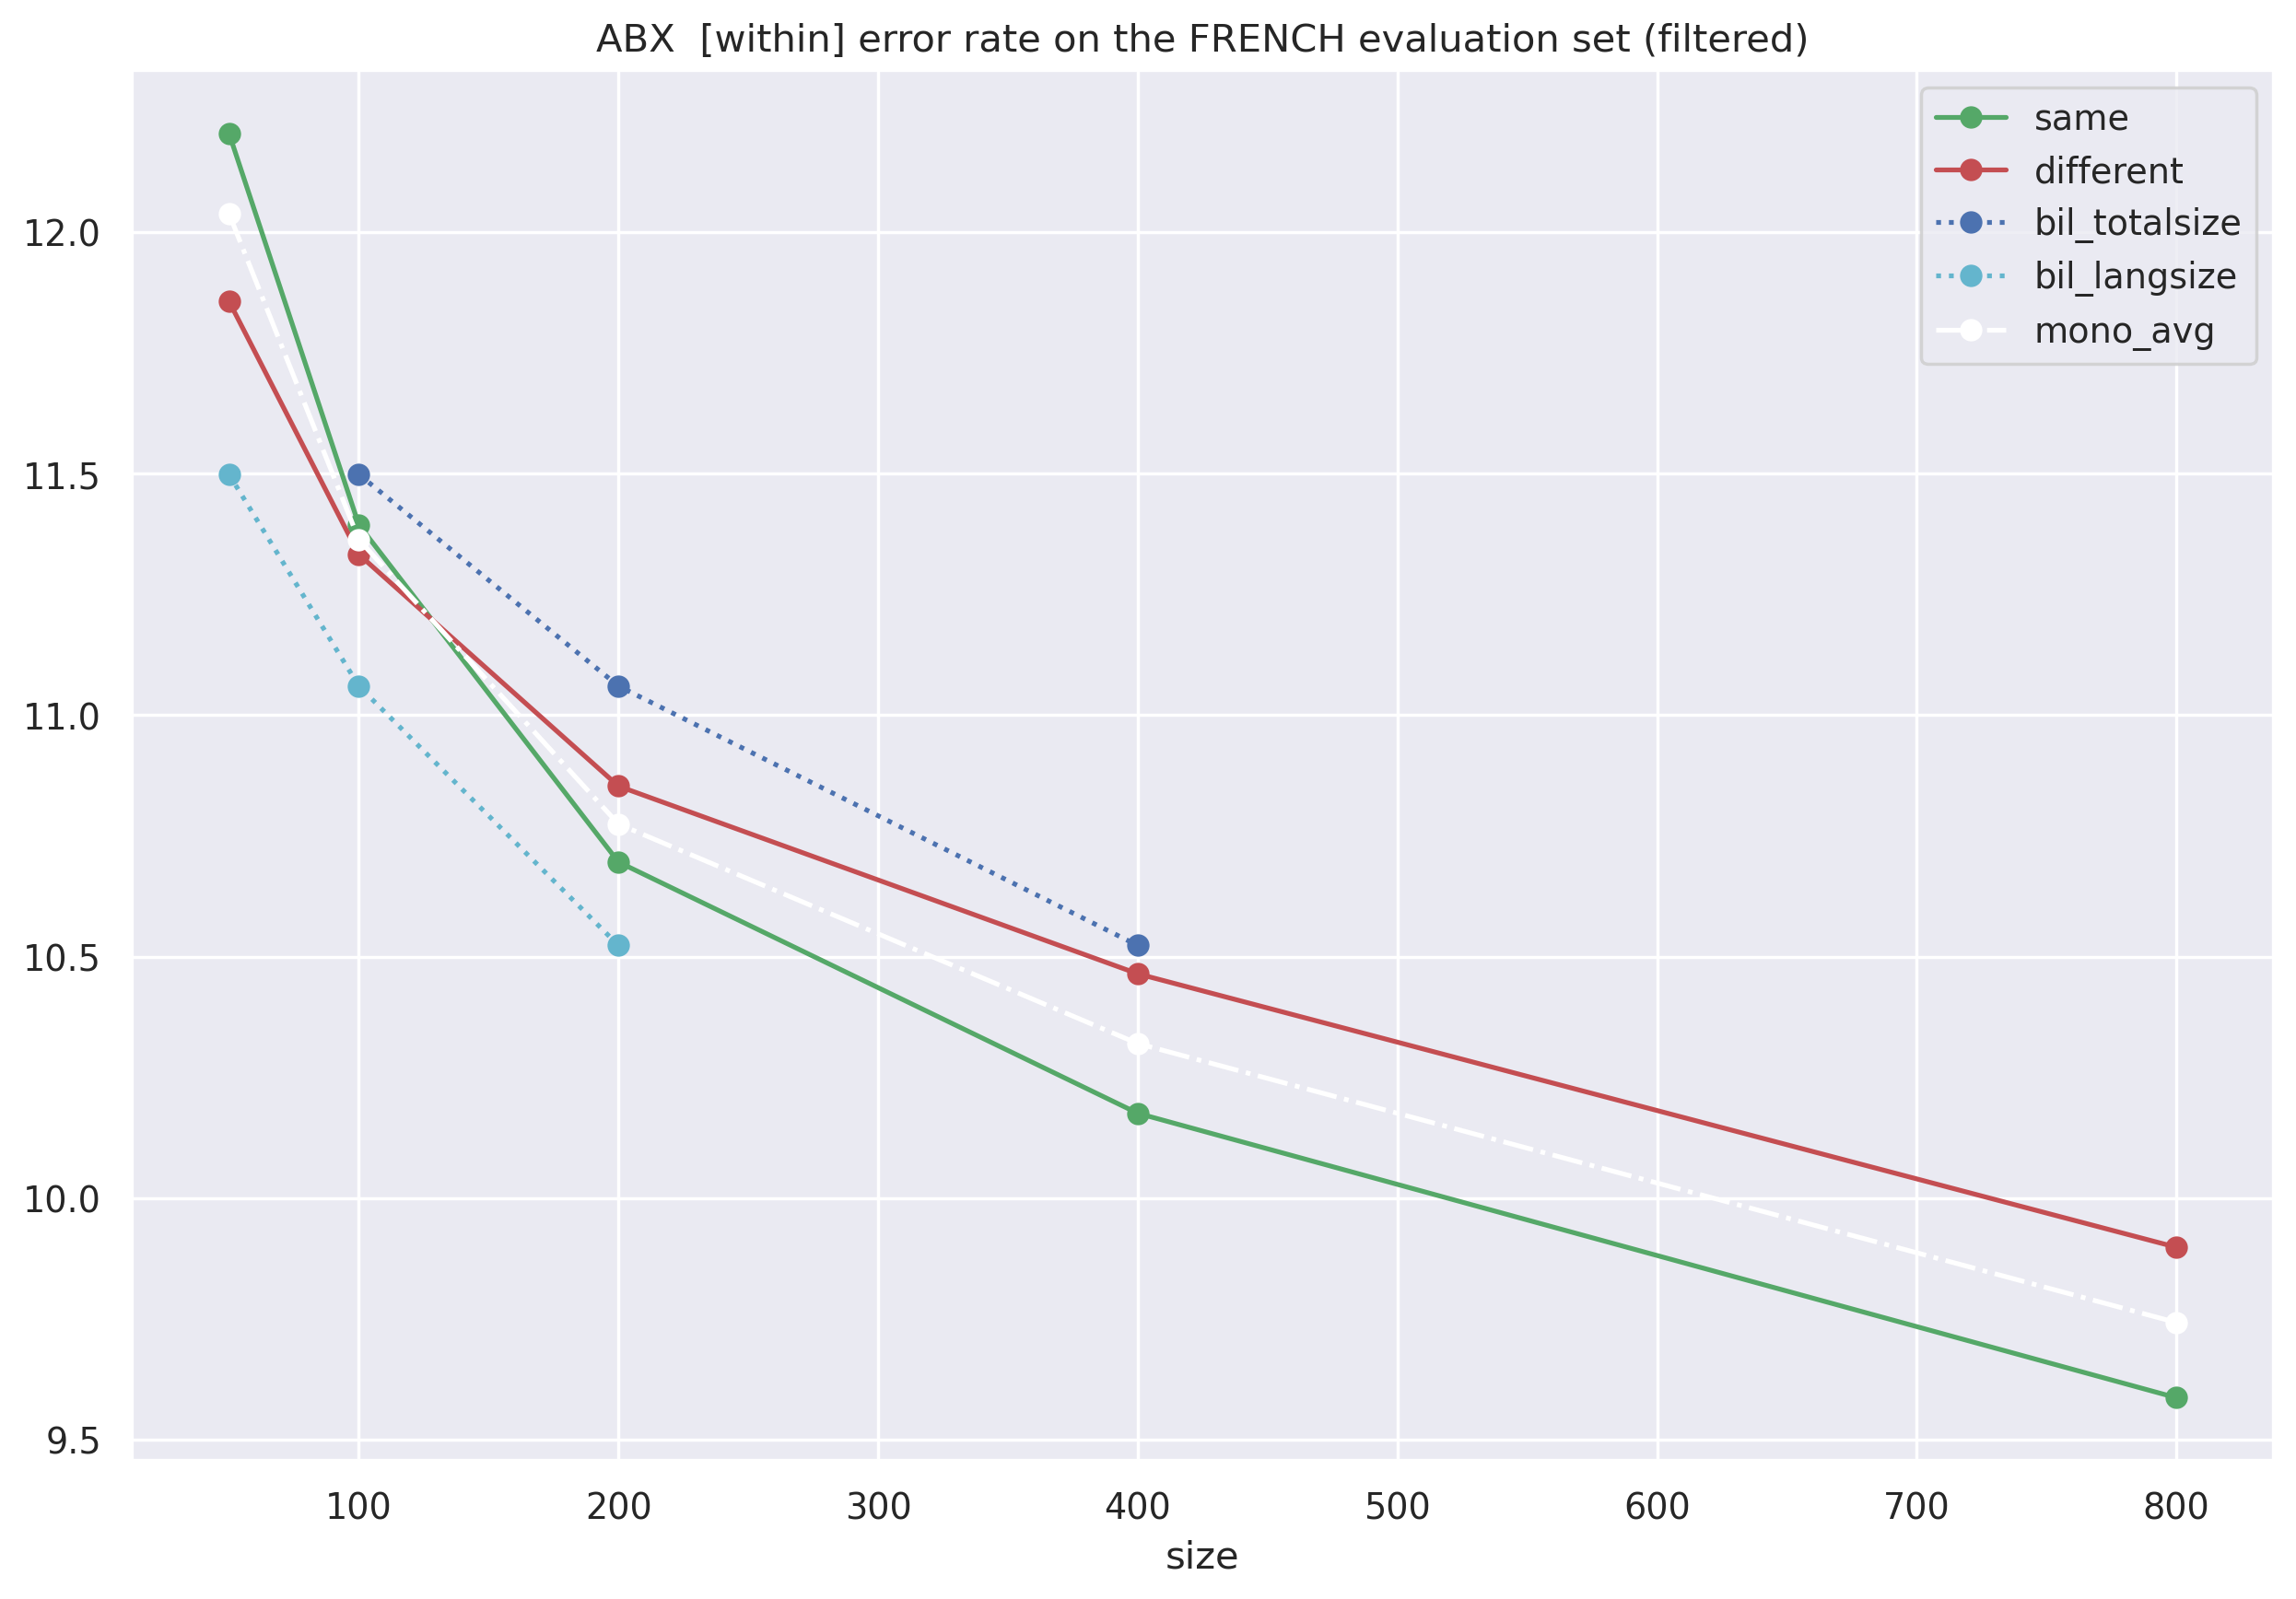

In [44]:
l="french"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate on the FRENCH evaluation set")

df_tmp = df_ef_within[df_ef_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX  [within] error rate on the FRENCH evaluation set (filtered)")


### D3b. Developmental [within] ABX  on the French test set (original and QuickFix) - xLog scale

Text(0, 0.5, 'ABX [within] error rate')

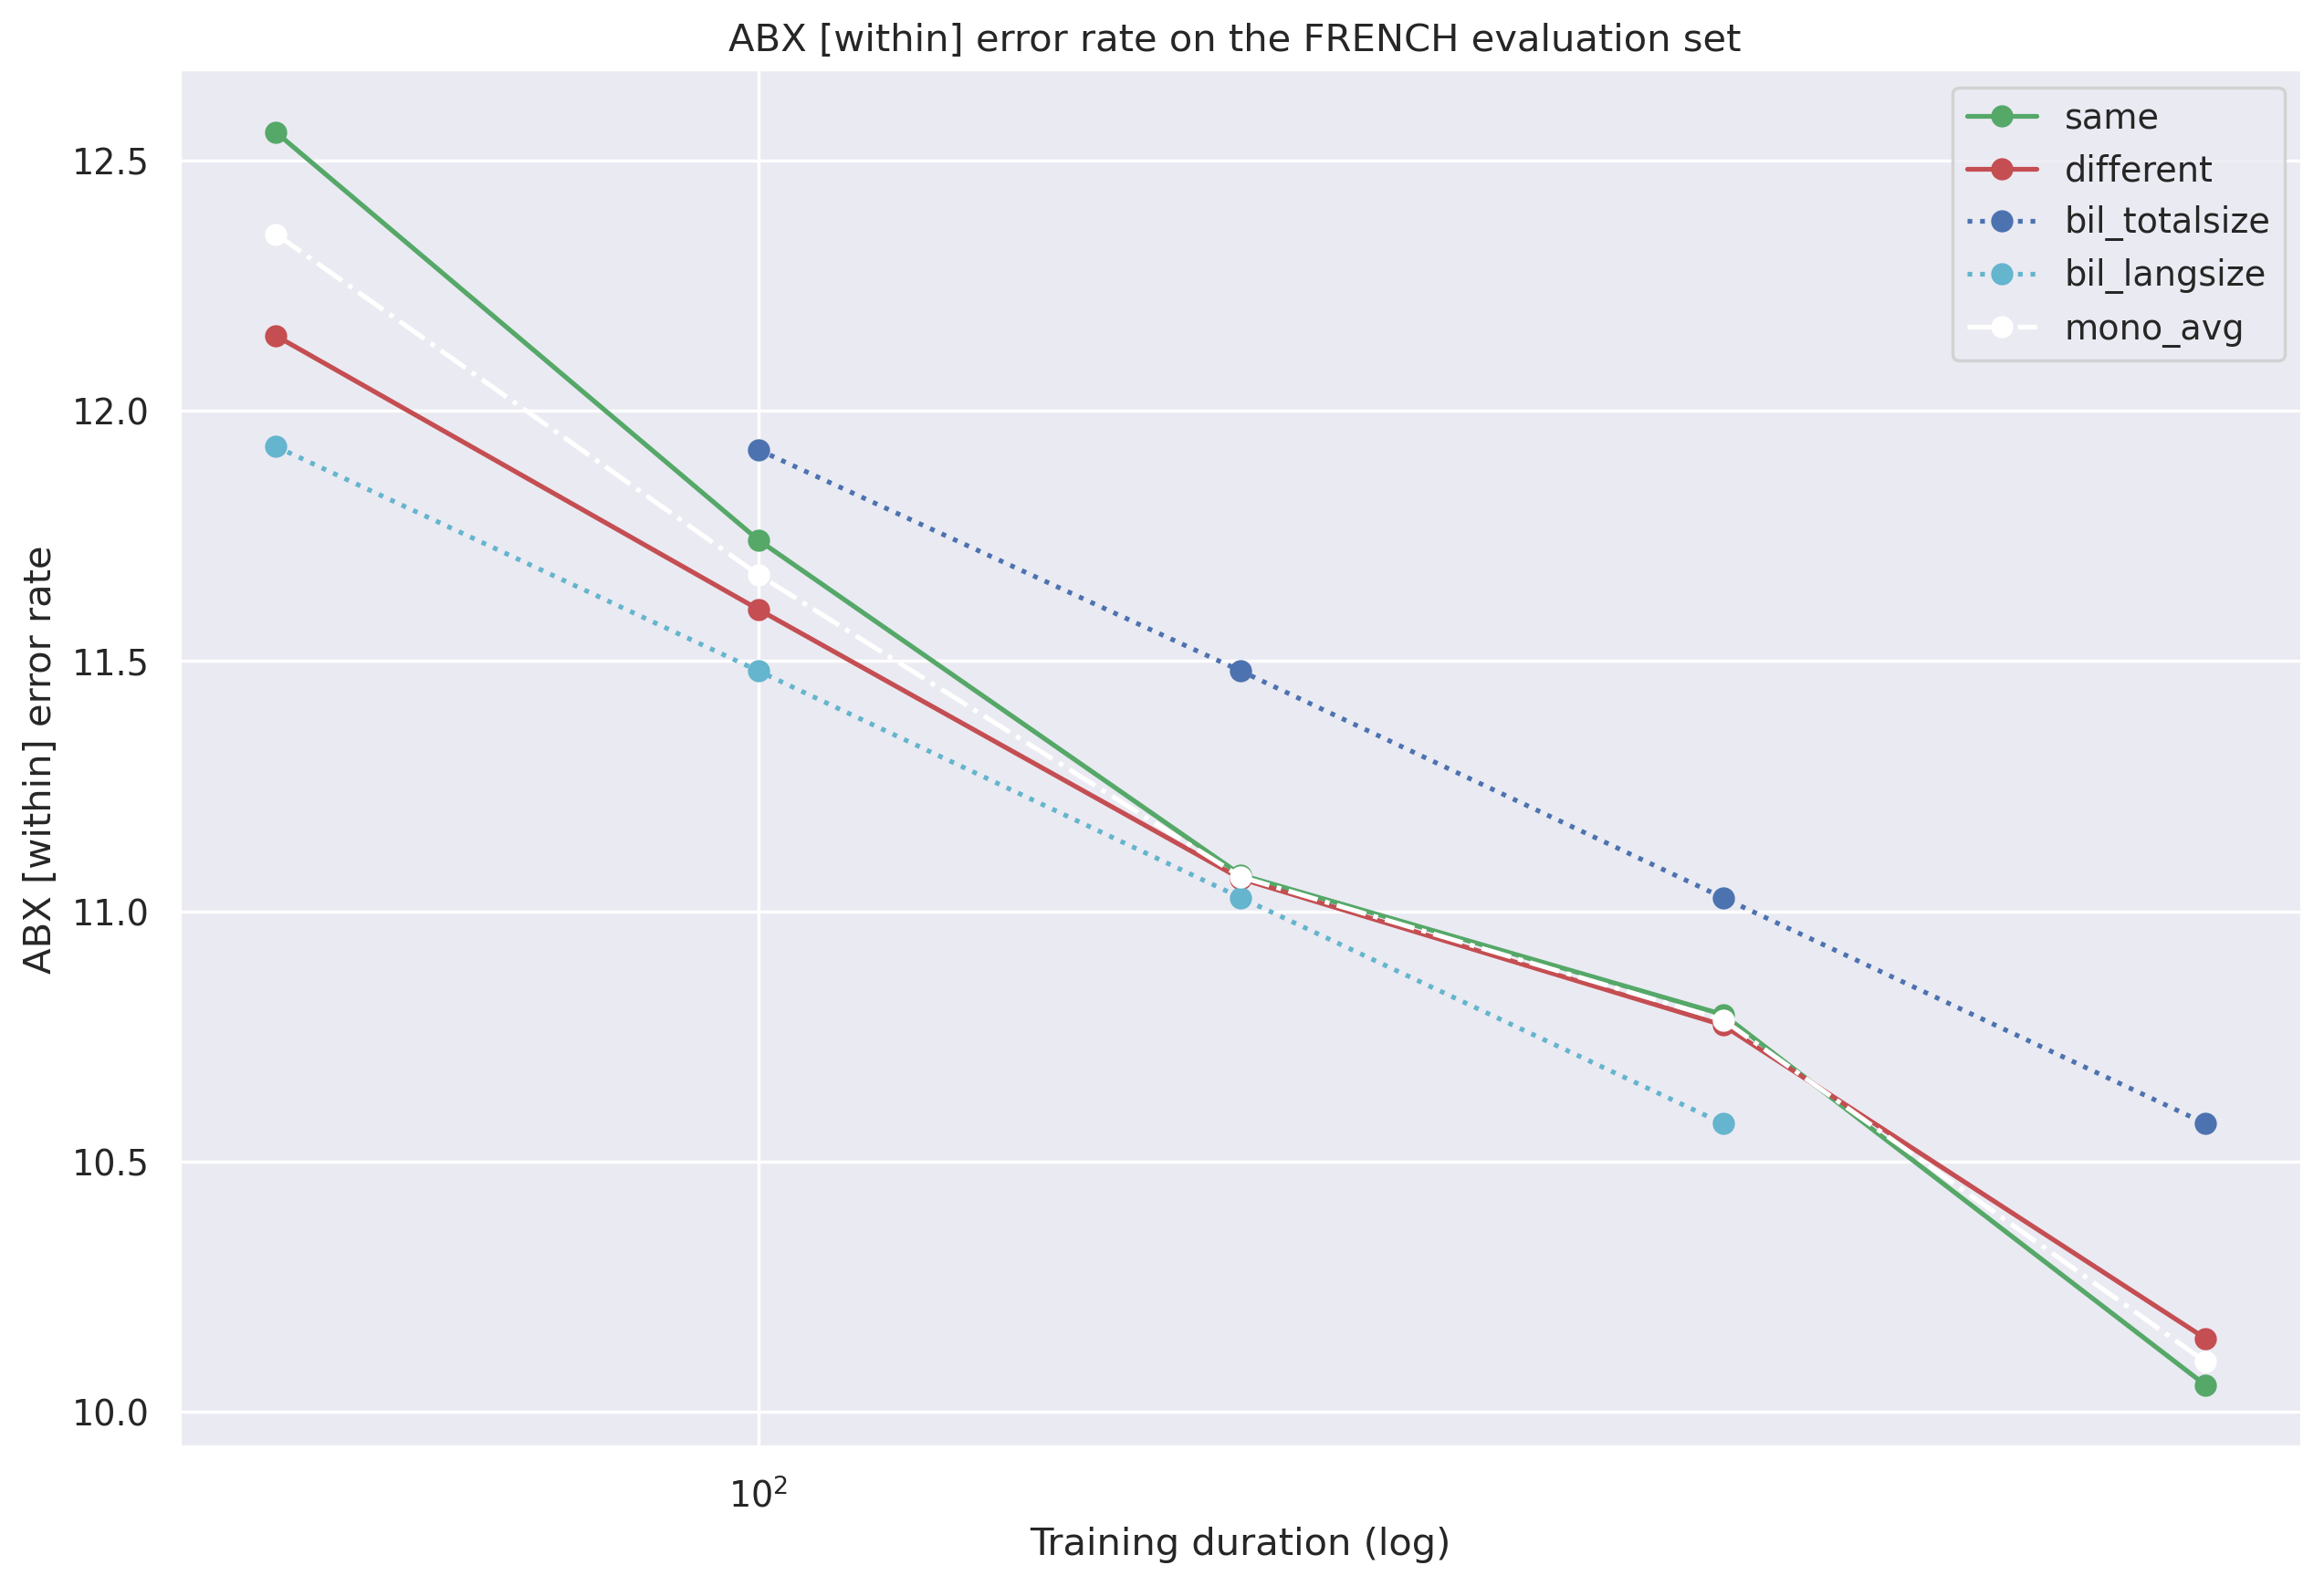

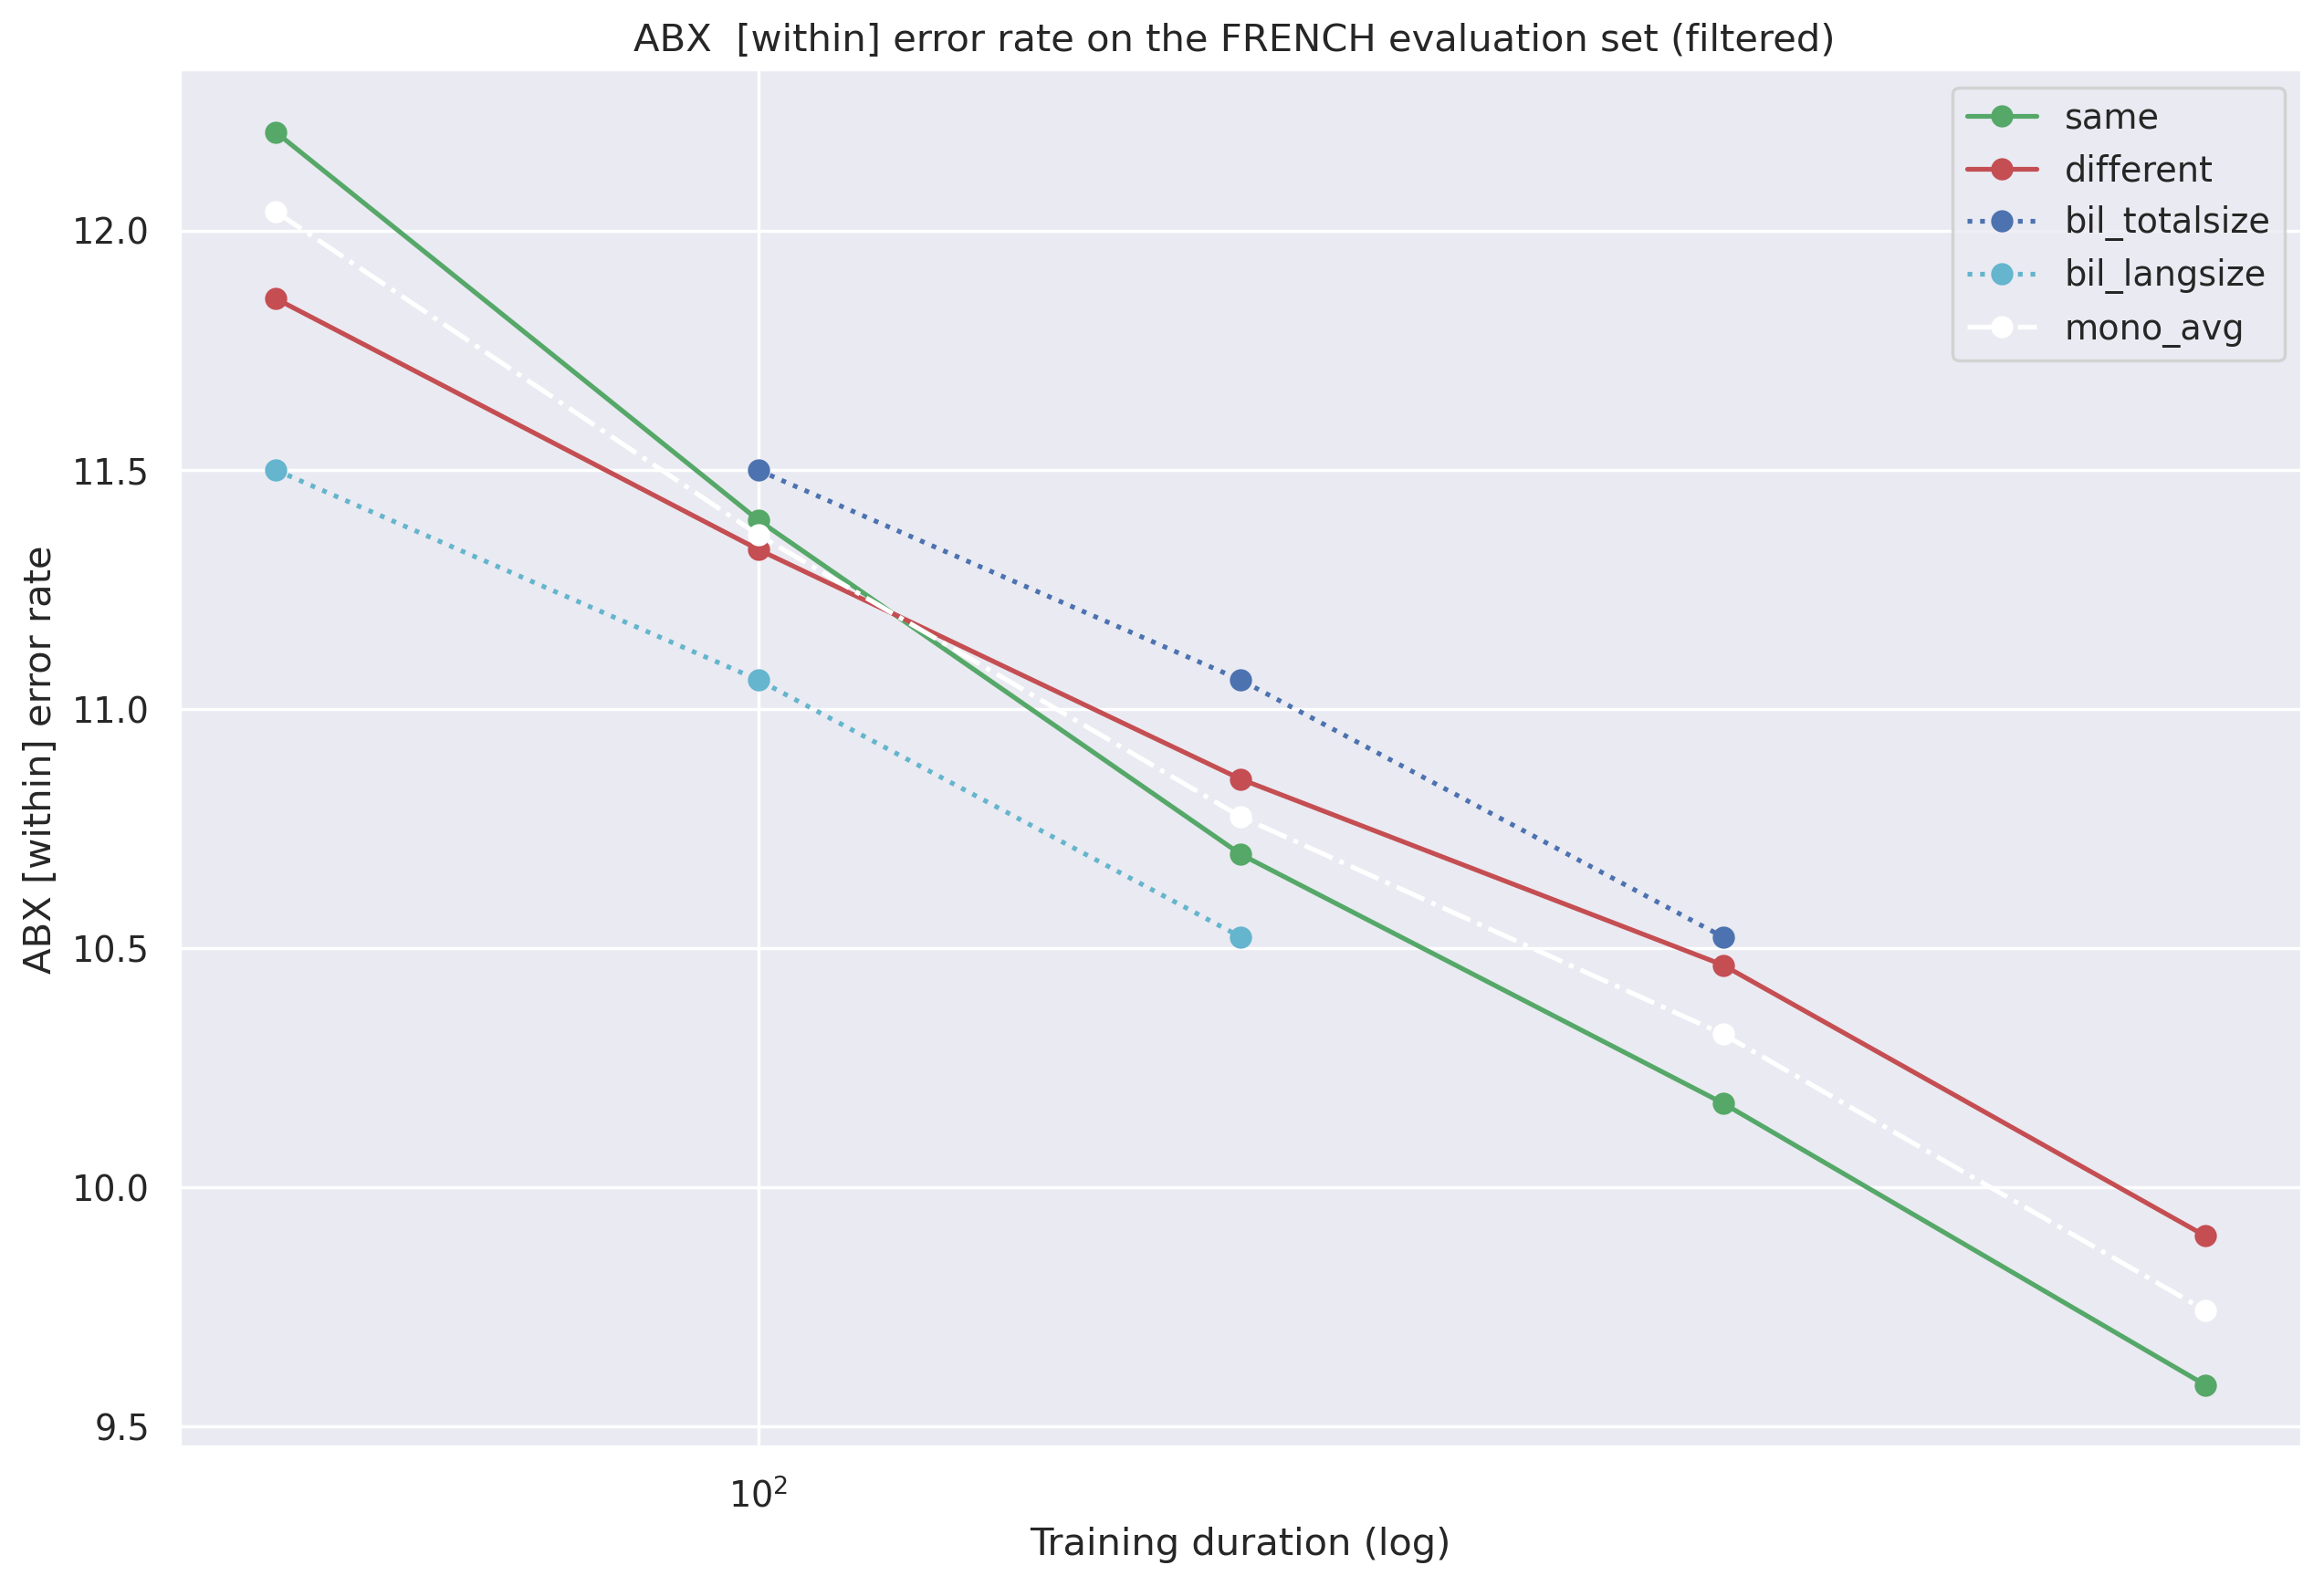

In [46]:
#log

l="french"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, logx=True)
plt.title("ABX [within] error rate on the FRENCH evaluation set ")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate")


df_tmp = df_ef_within[df_ef_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, logx=True)
plt.title("ABX  [within] error rate on the FRENCH evaluation set (filtered) ")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate")


### D3c. Developmental [within] ABX  on the French test set (original and QuickFix) - Loglog scale

(6, 13)

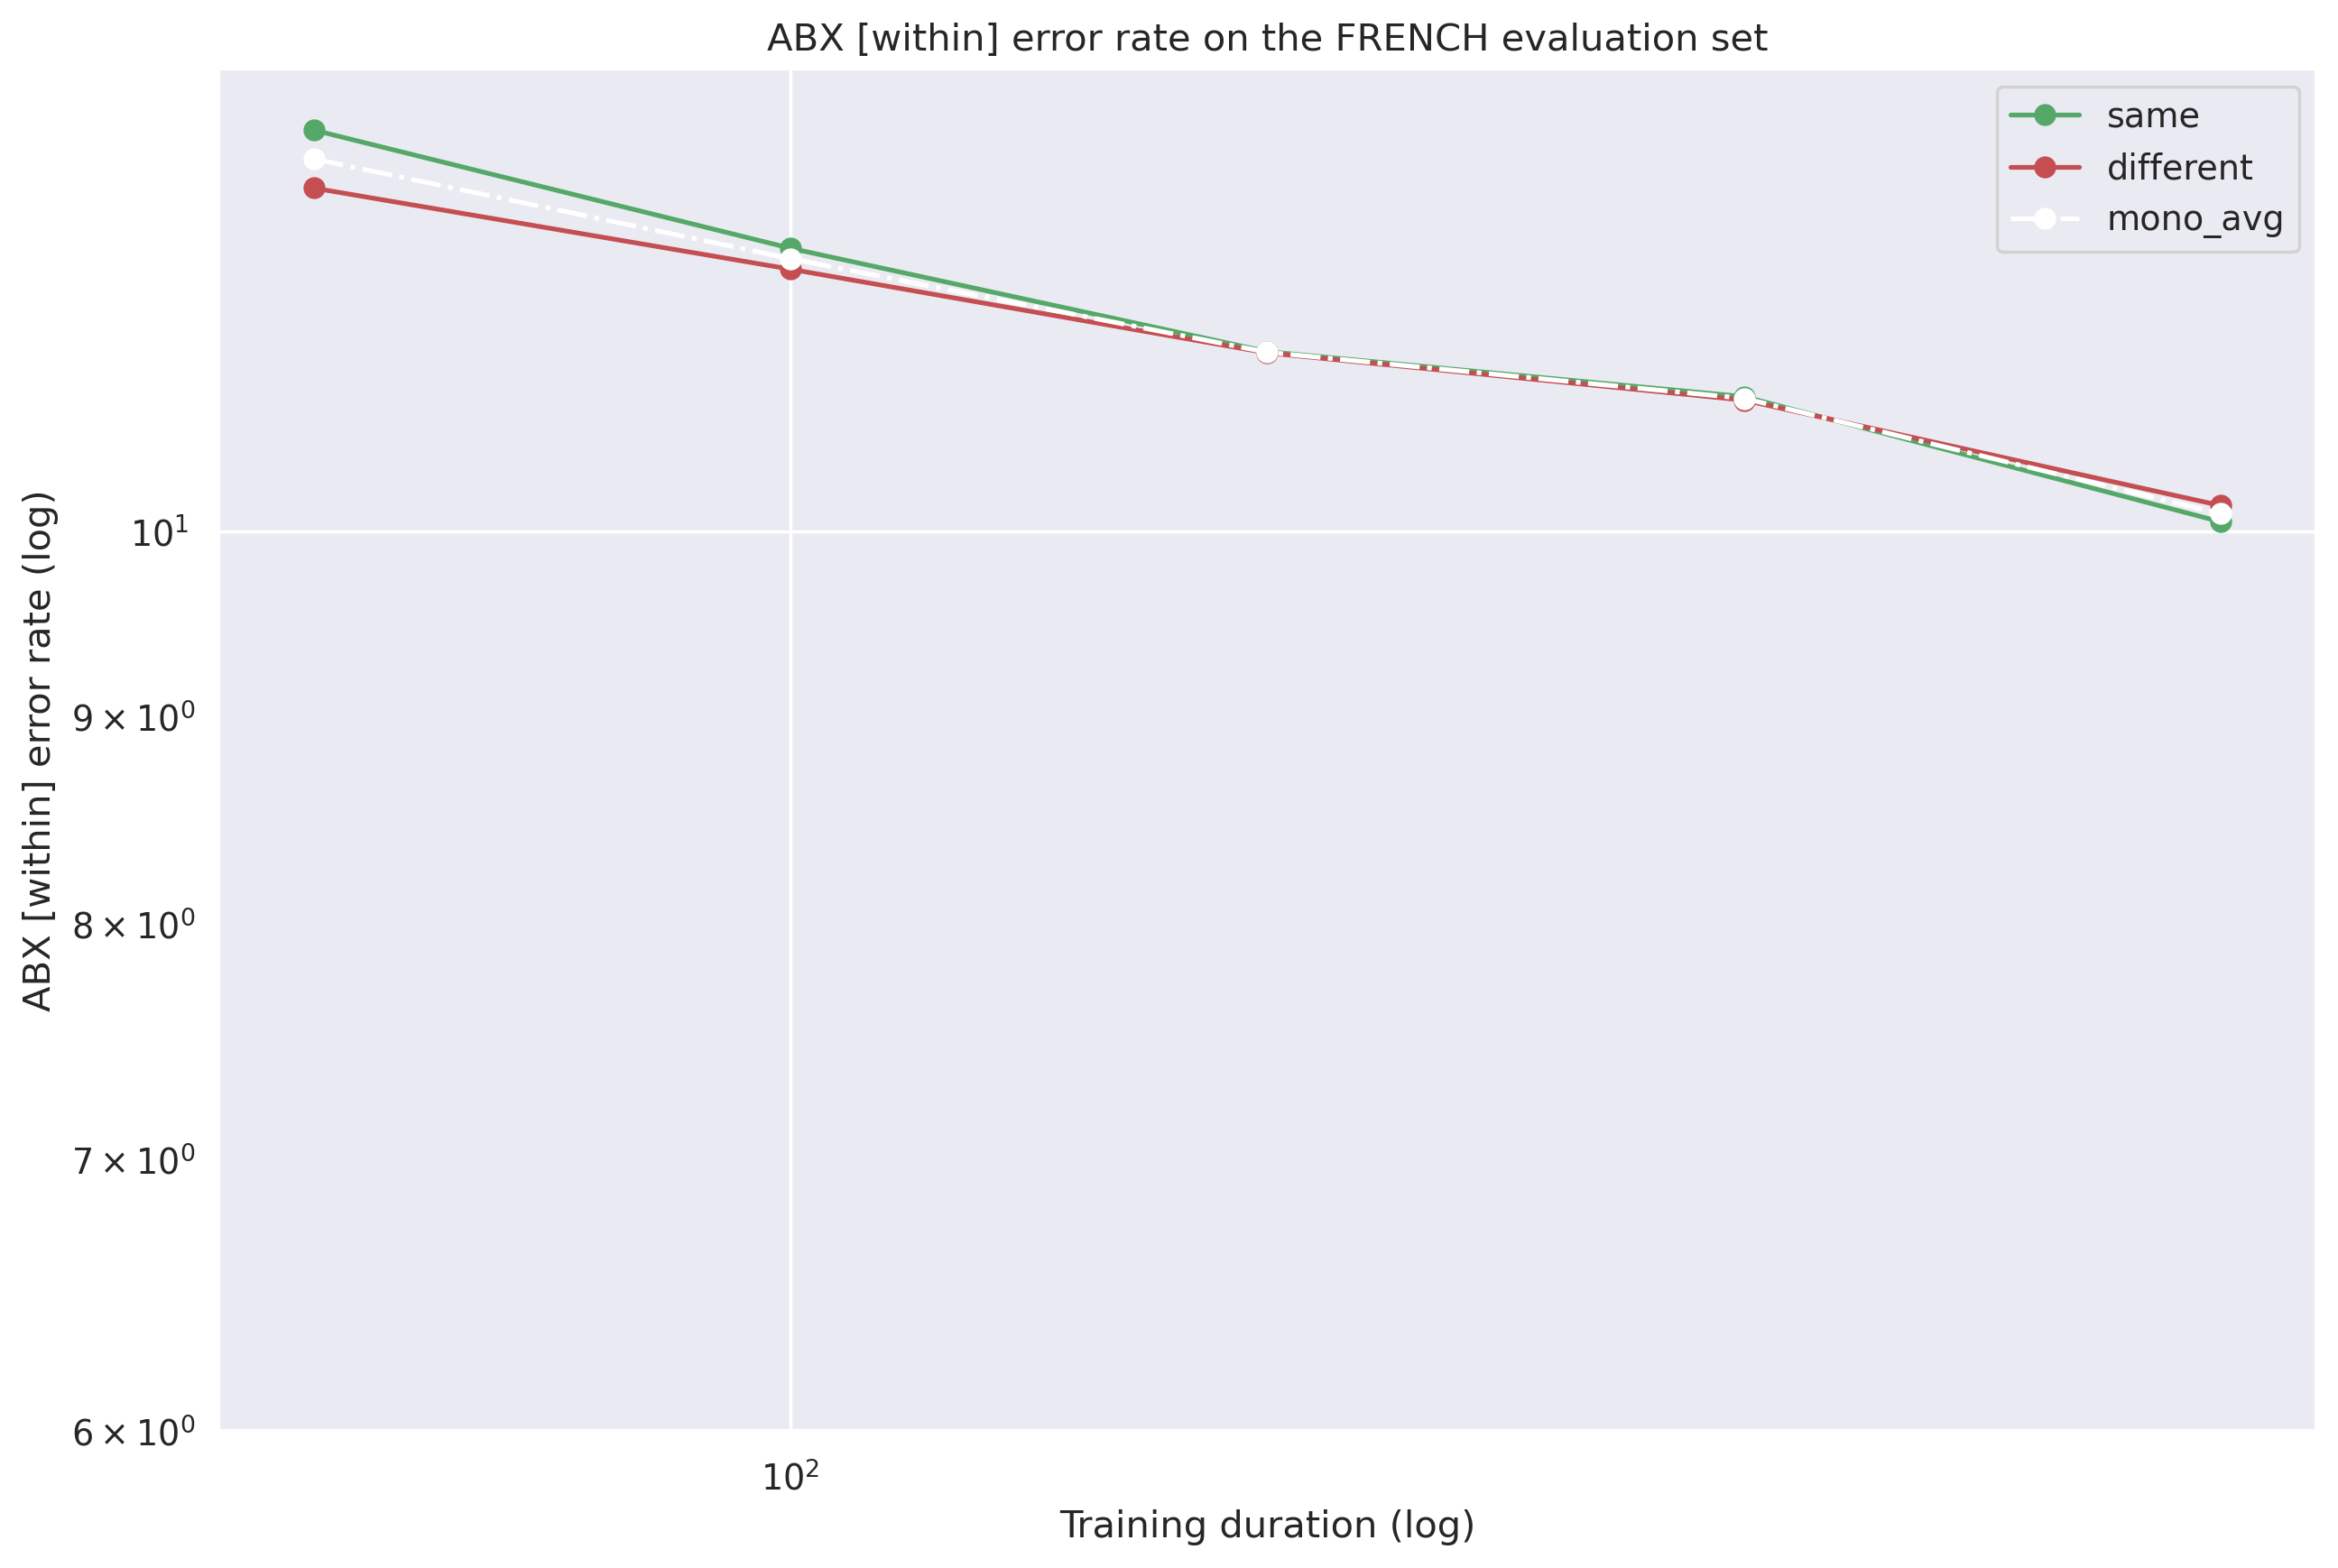

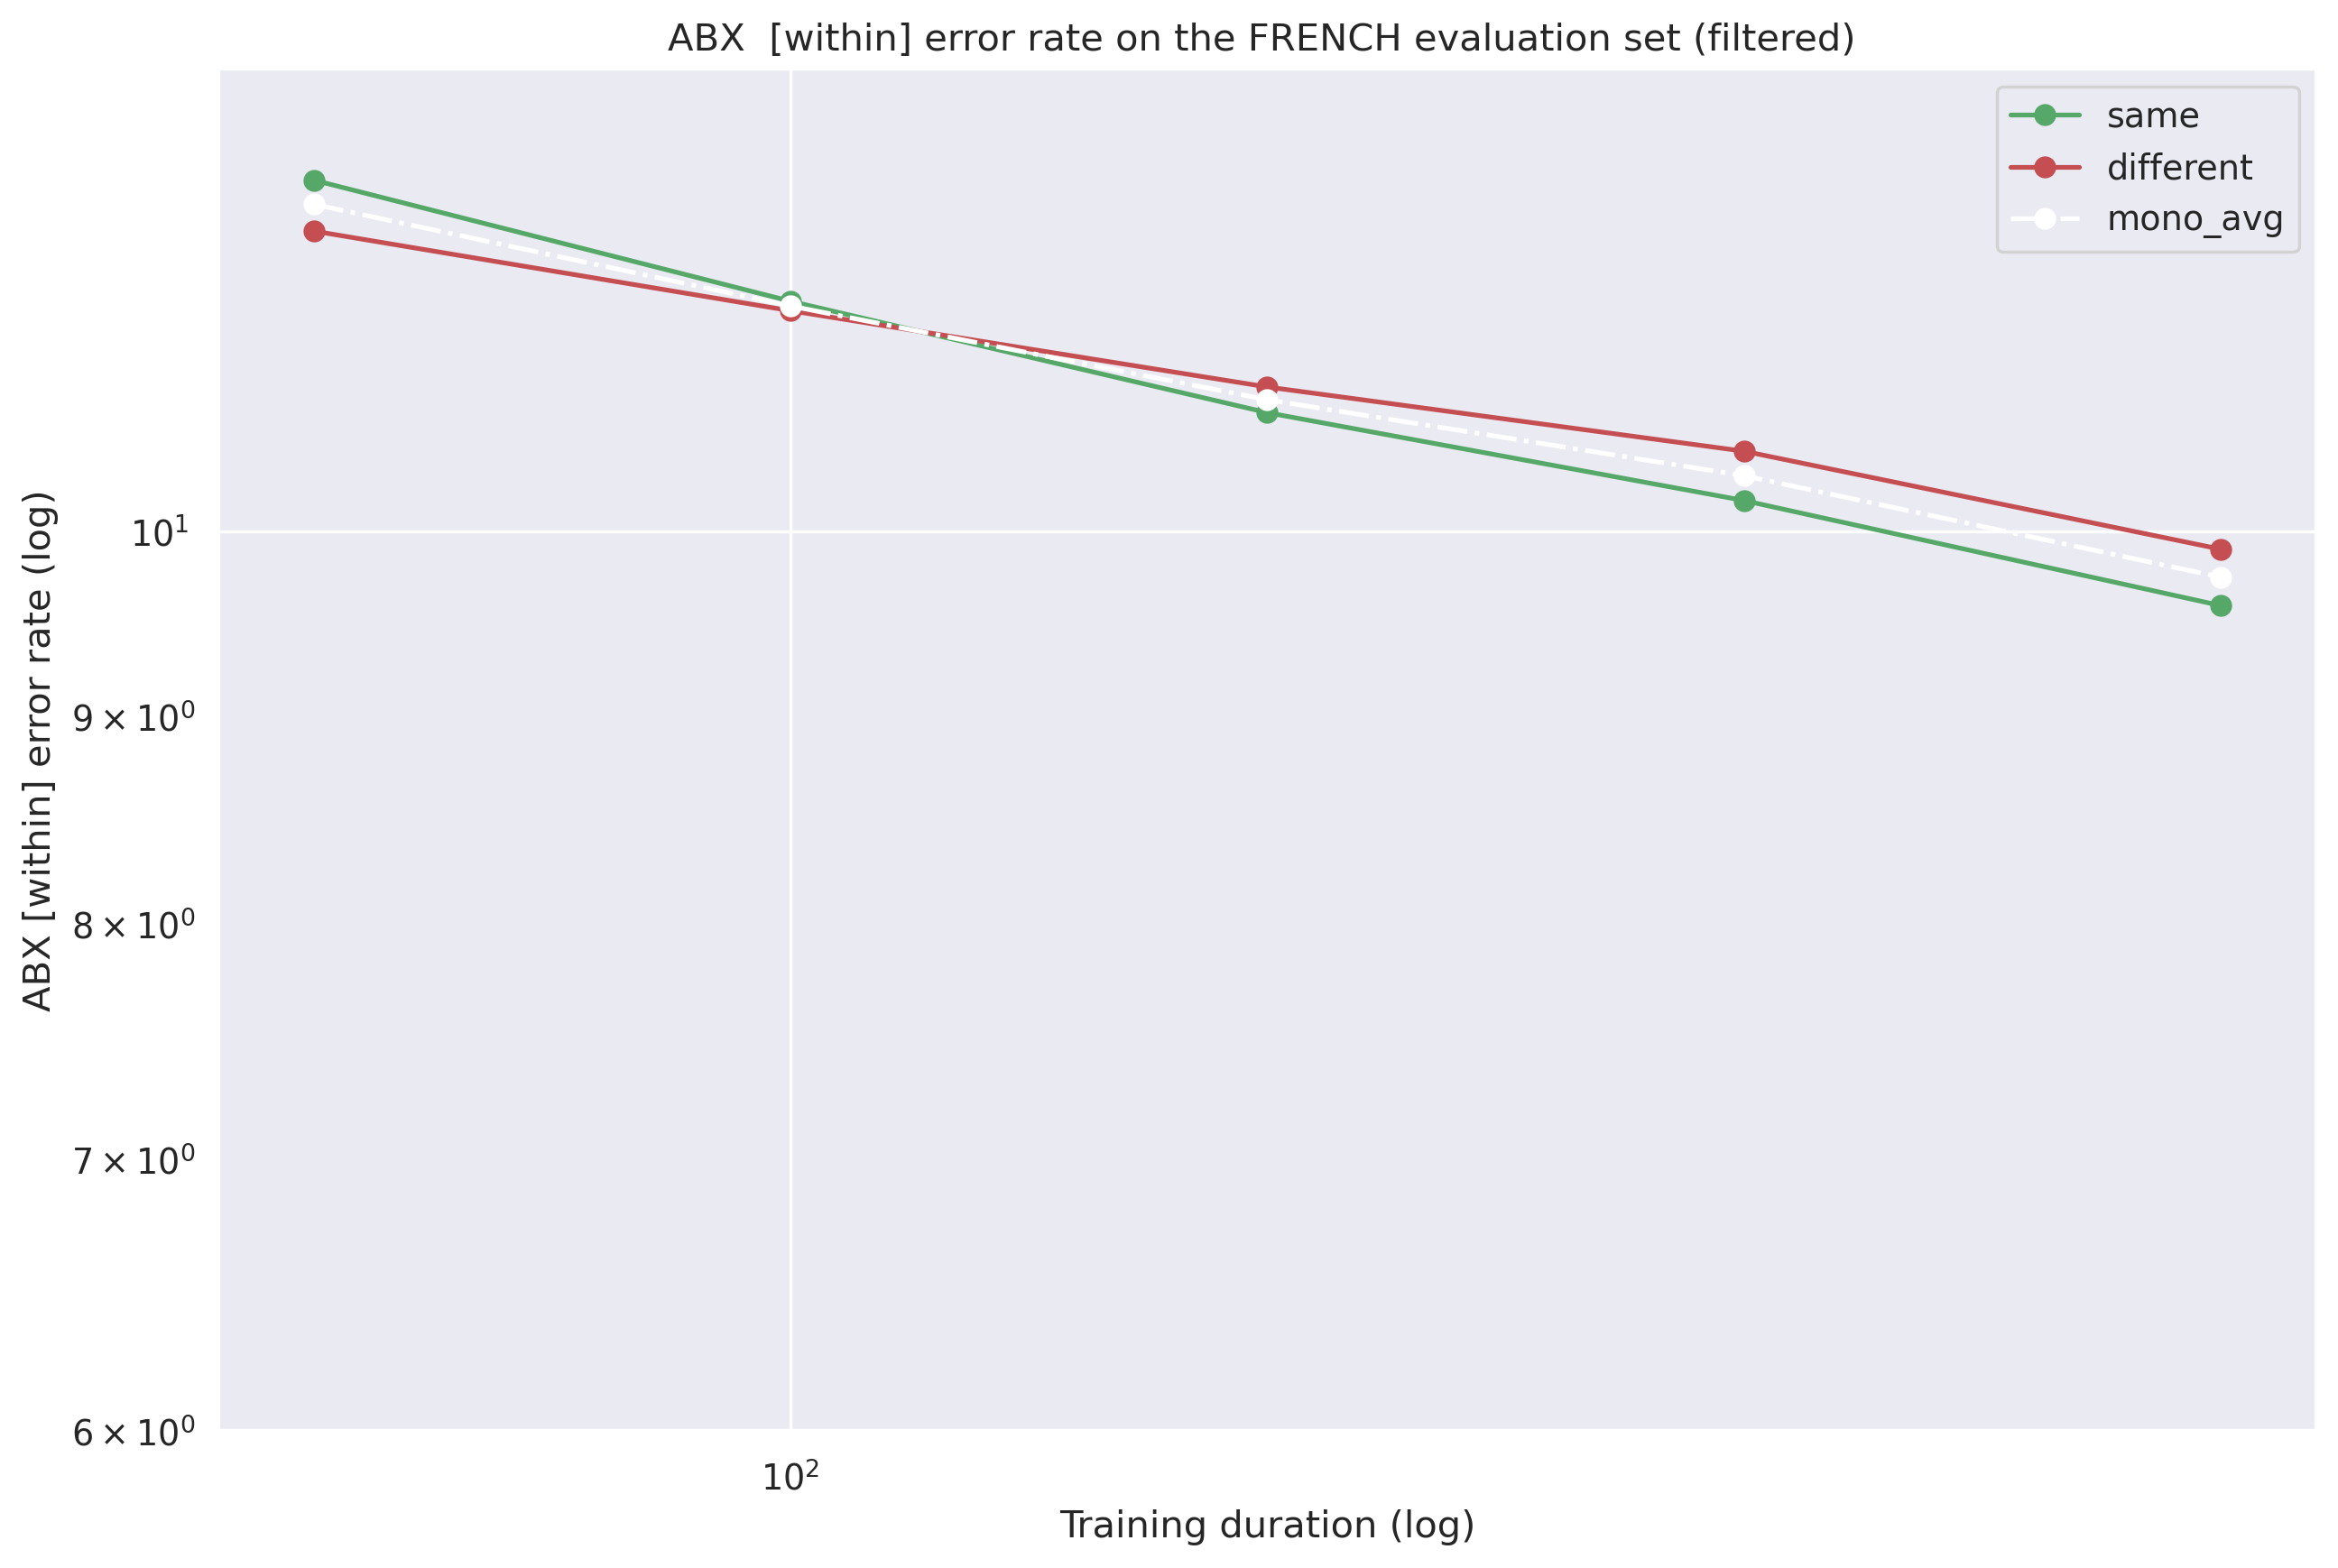

In [161]:
#log

l="french"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'mono_avg']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([6,13])


df_tmp = df_ef_within[df_ef_within["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'mono_avg']].plot(style = style_dict, loglog=True)

plt.title("ABX  [within] error rate on the FRENCH evaluation set (filtered) ")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([6,13])


### D4a. Developmental [within] ABX on the English test set

(6.0, 13.0)

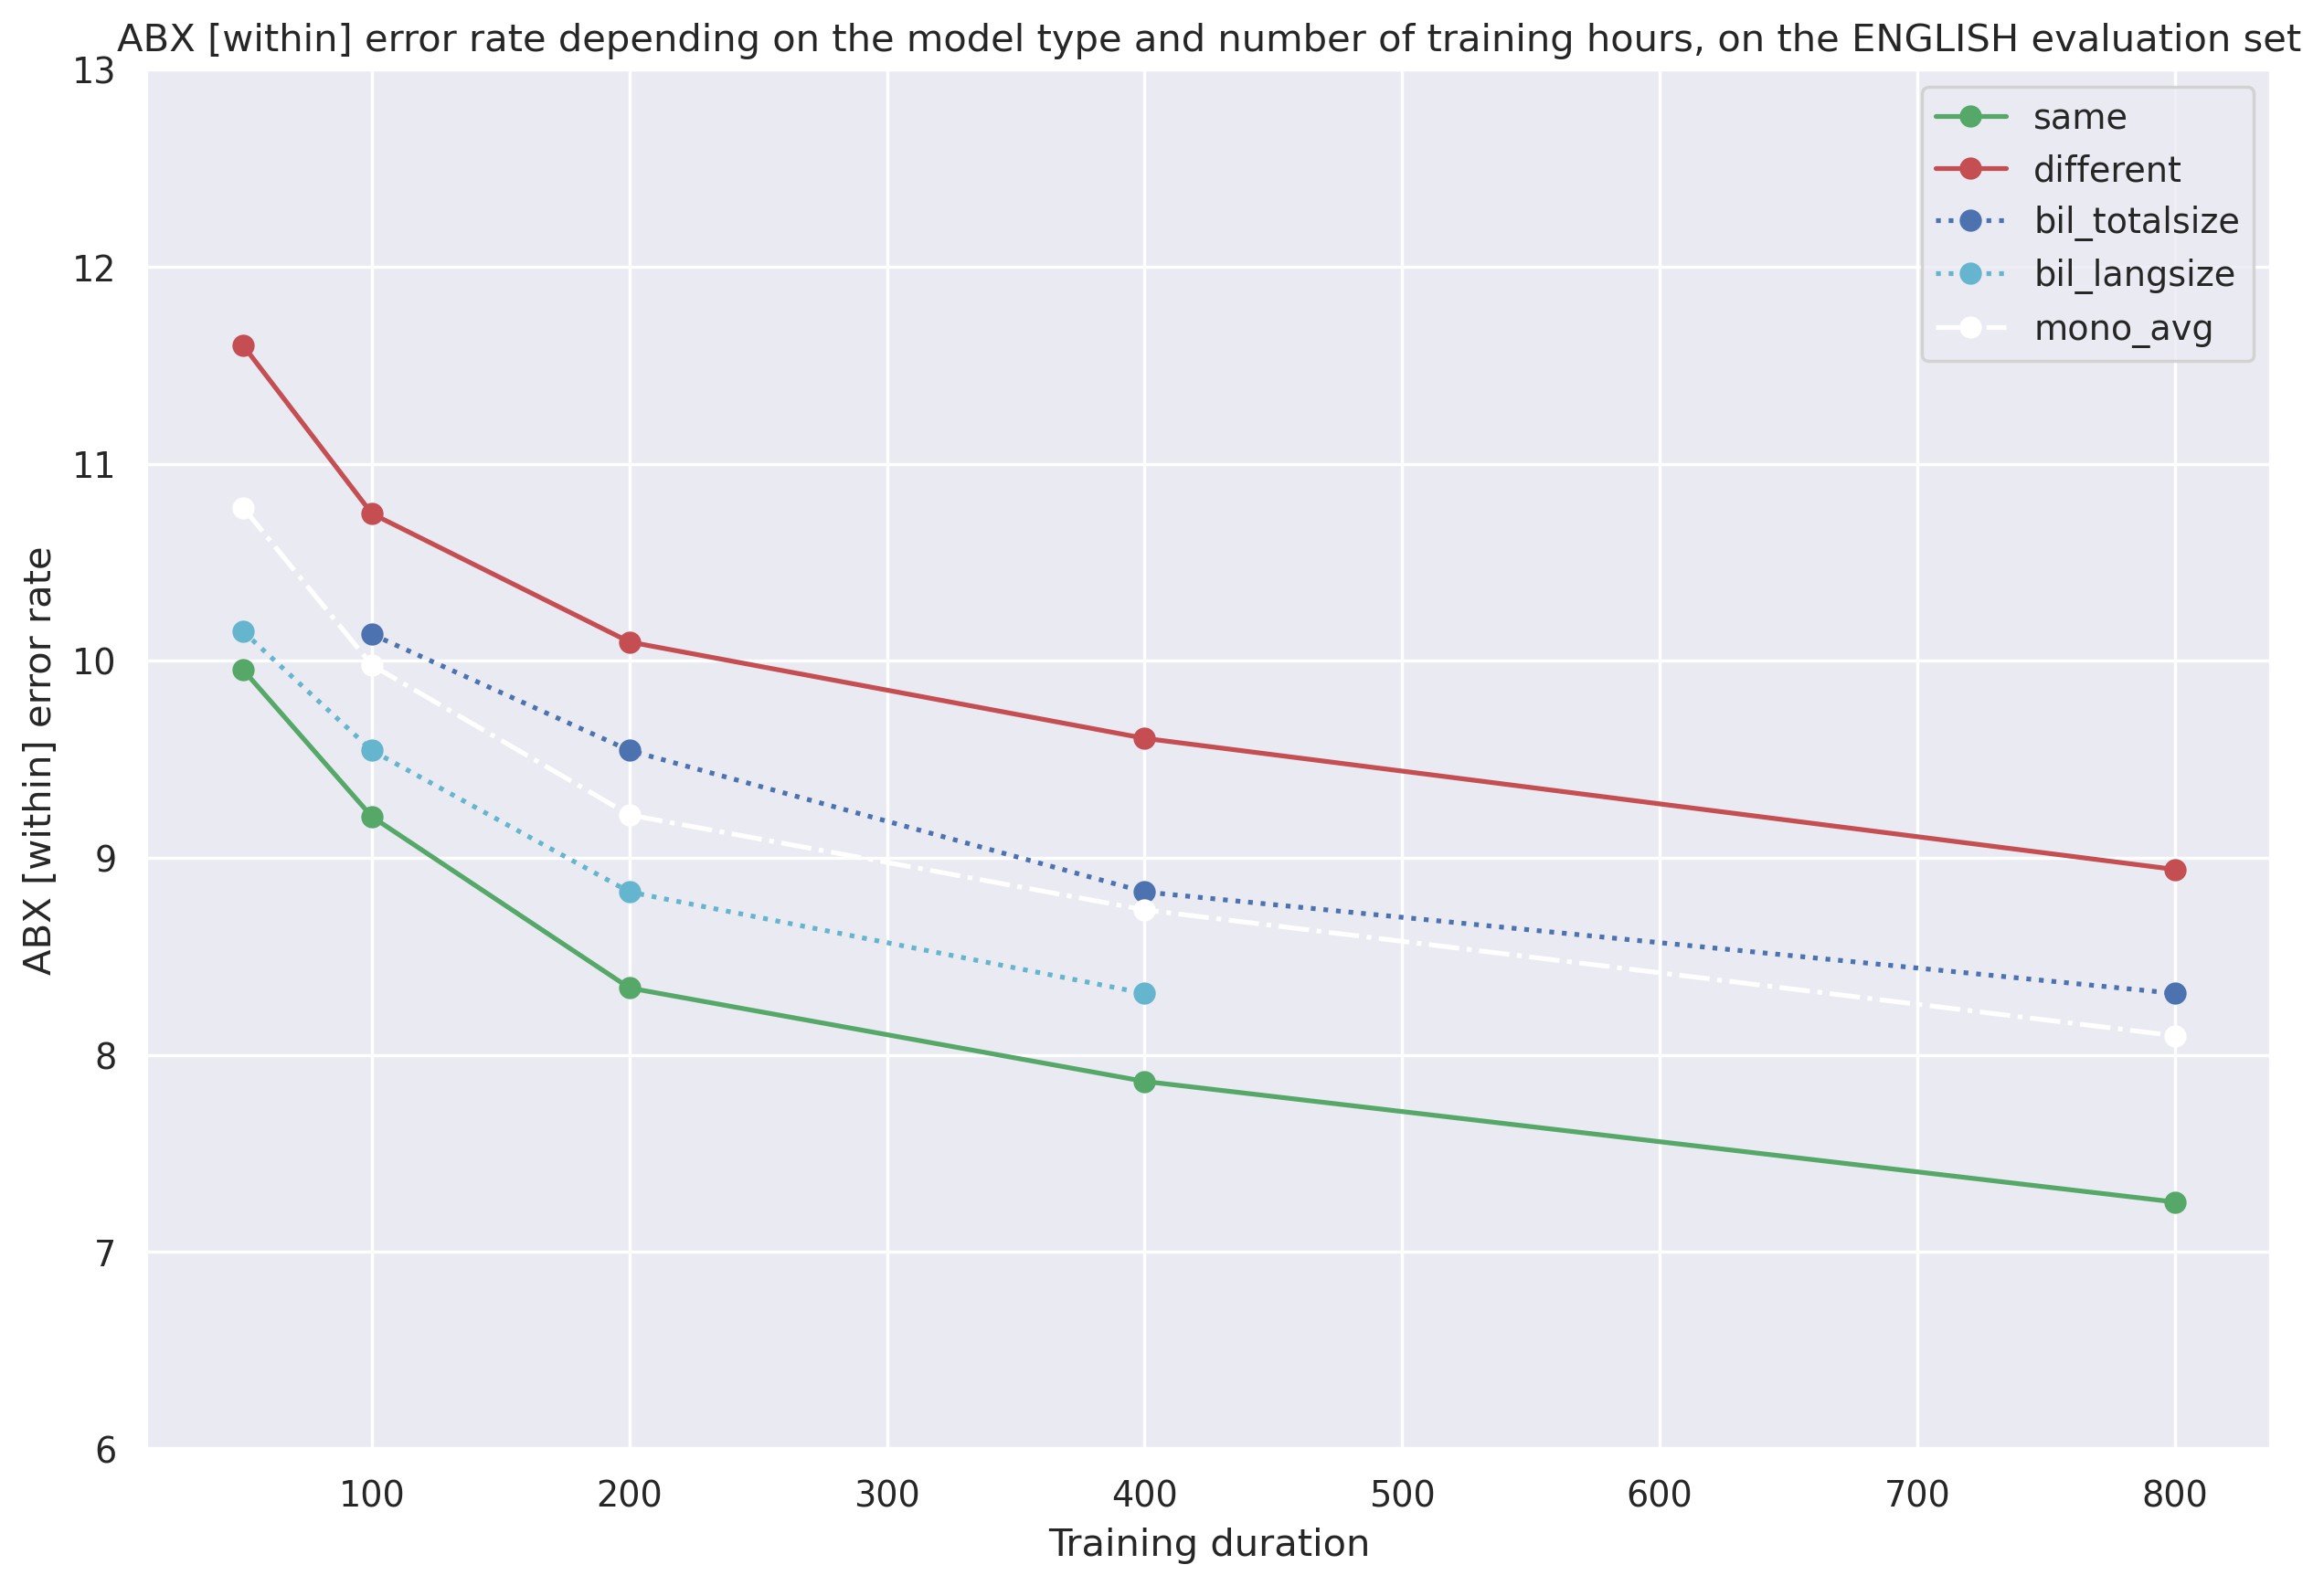

In [157]:
l="english"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate depending on the model type and number of training hours, on the ENGLISH evaluation set")
plt.xlabel("Training duration")
plt.ylabel("ABX [within] error rate")
plt.ylim([6,13])

### D4a. Developmental [within] ABX on the English test set - loglog scale

(6, 13)

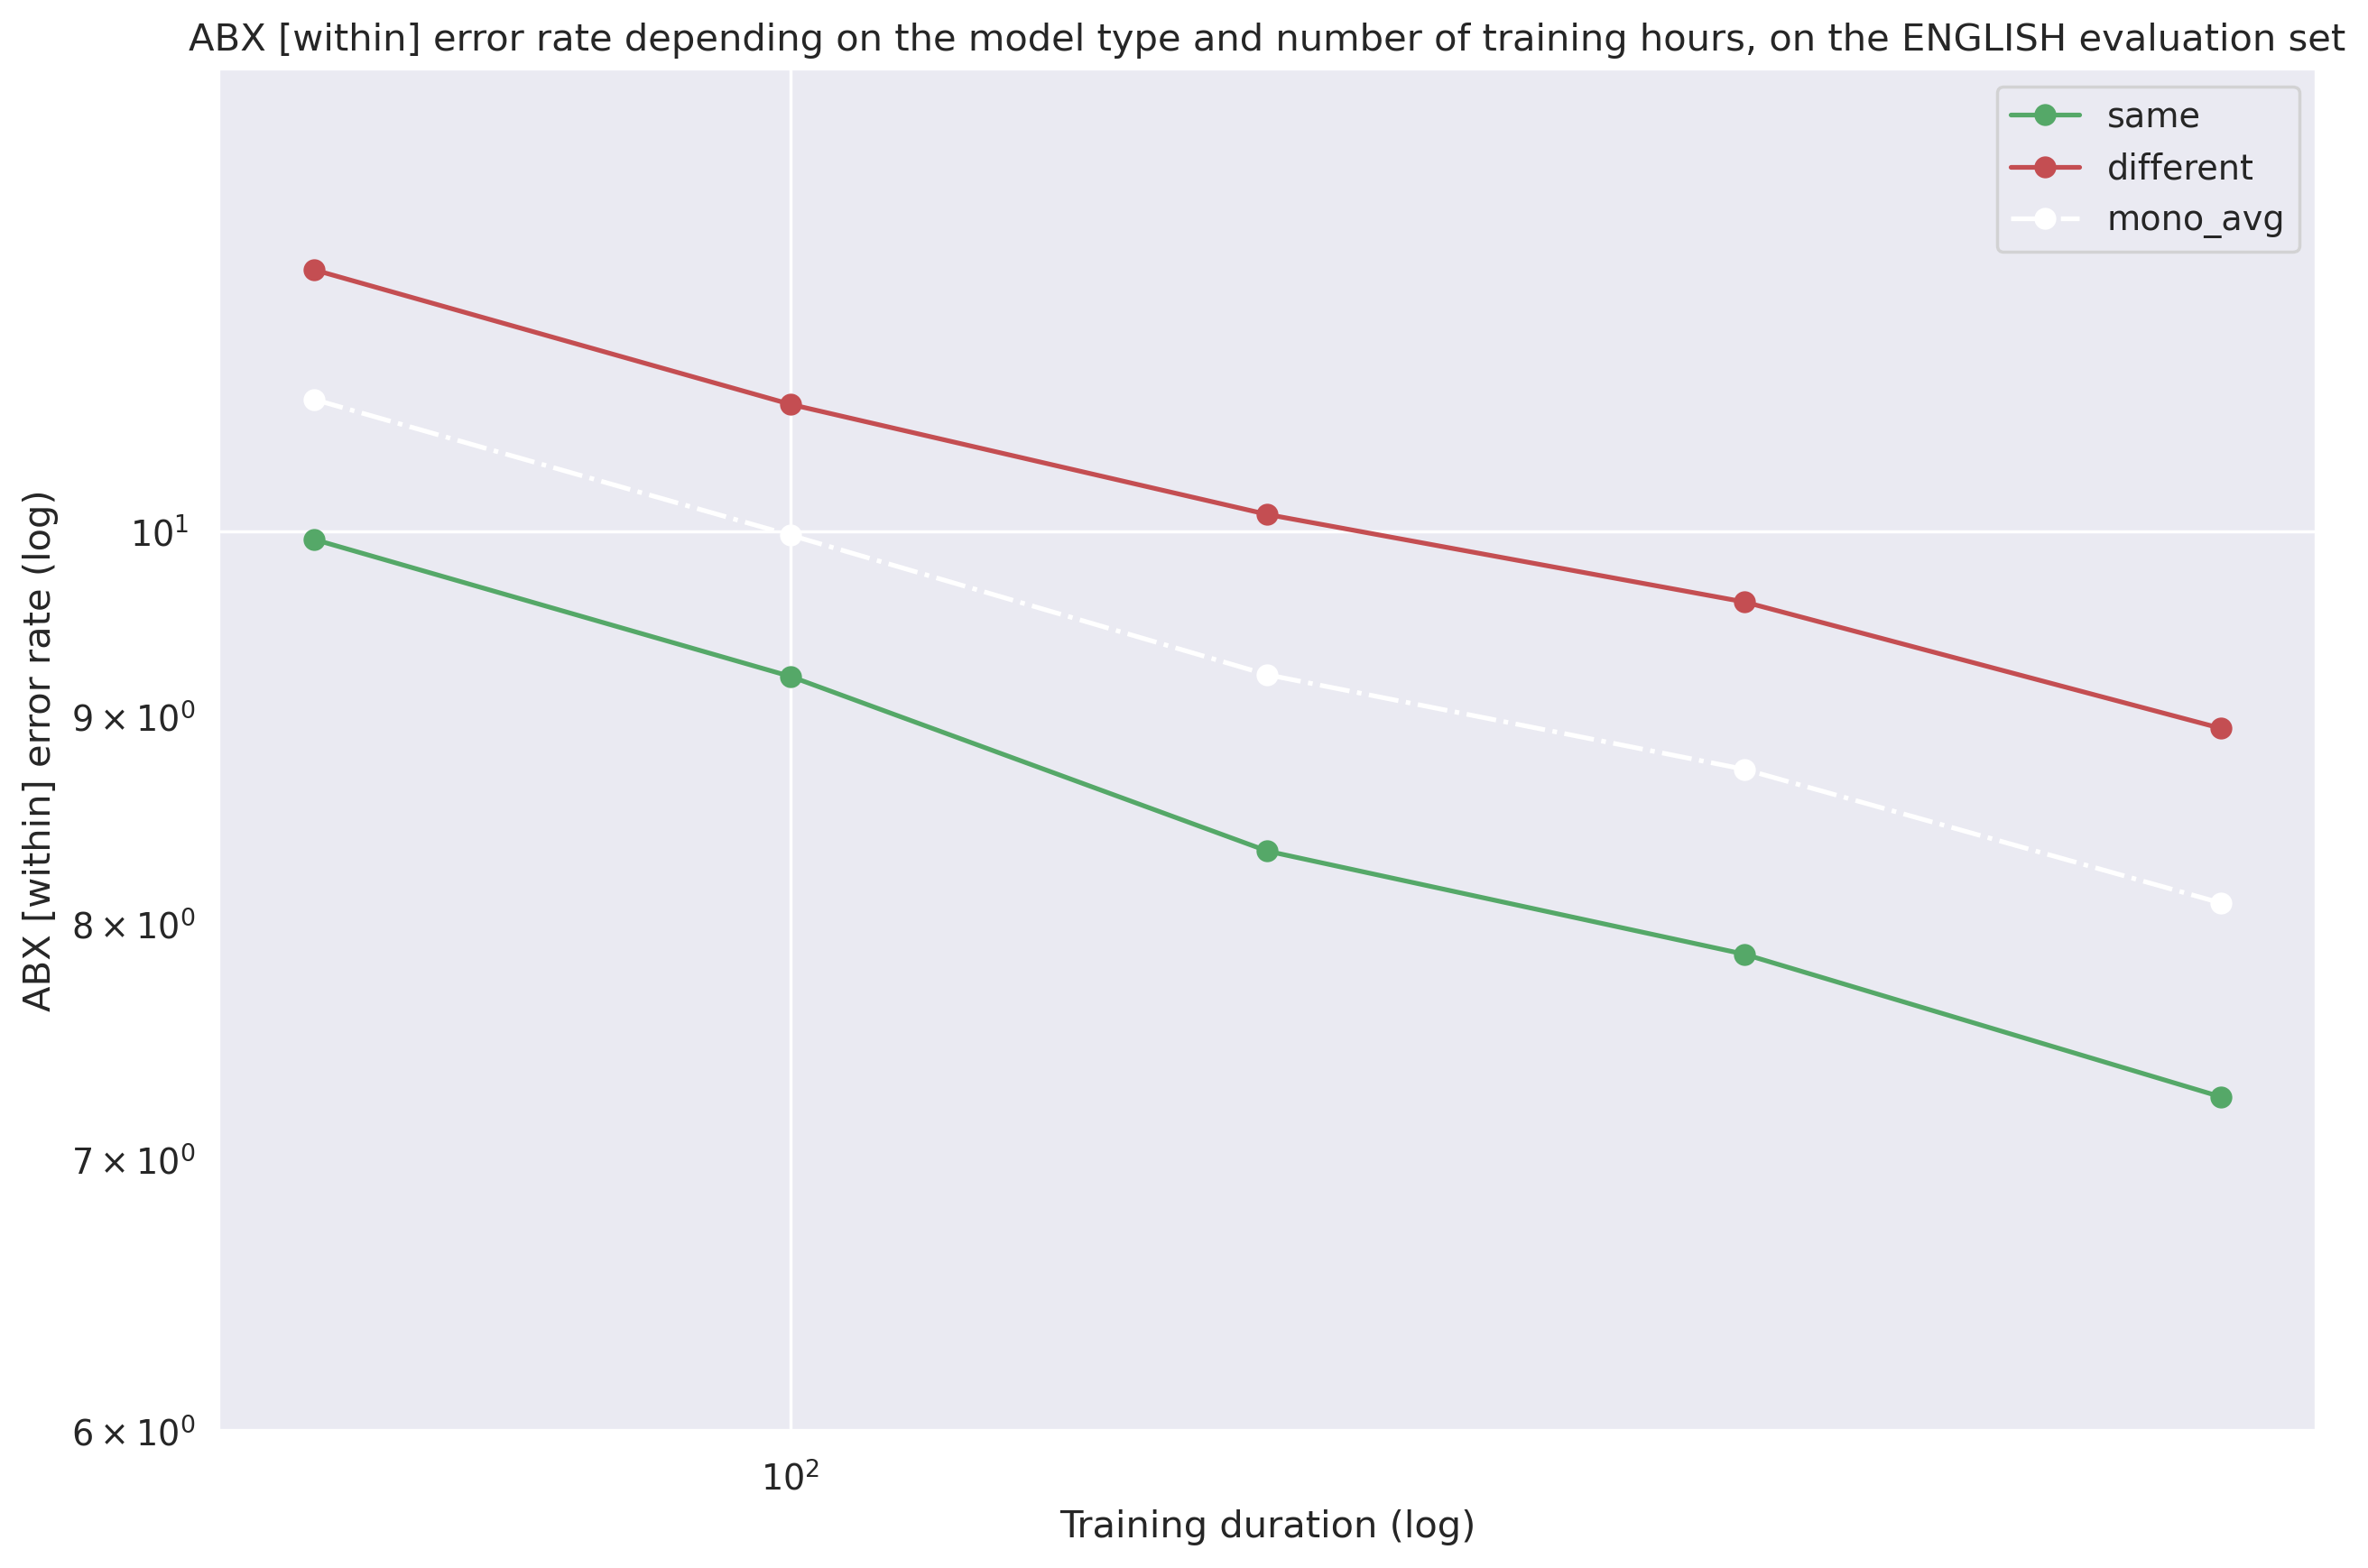

In [162]:
l="english"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different',  'mono_avg']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate depending on the model type and number of training hours, on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([6,13])

### D5. Developmental [across] ABX  on the French test set (original and QuickFix) - xLog

Text(0, 0.5, 'ABX [within] error rate ')

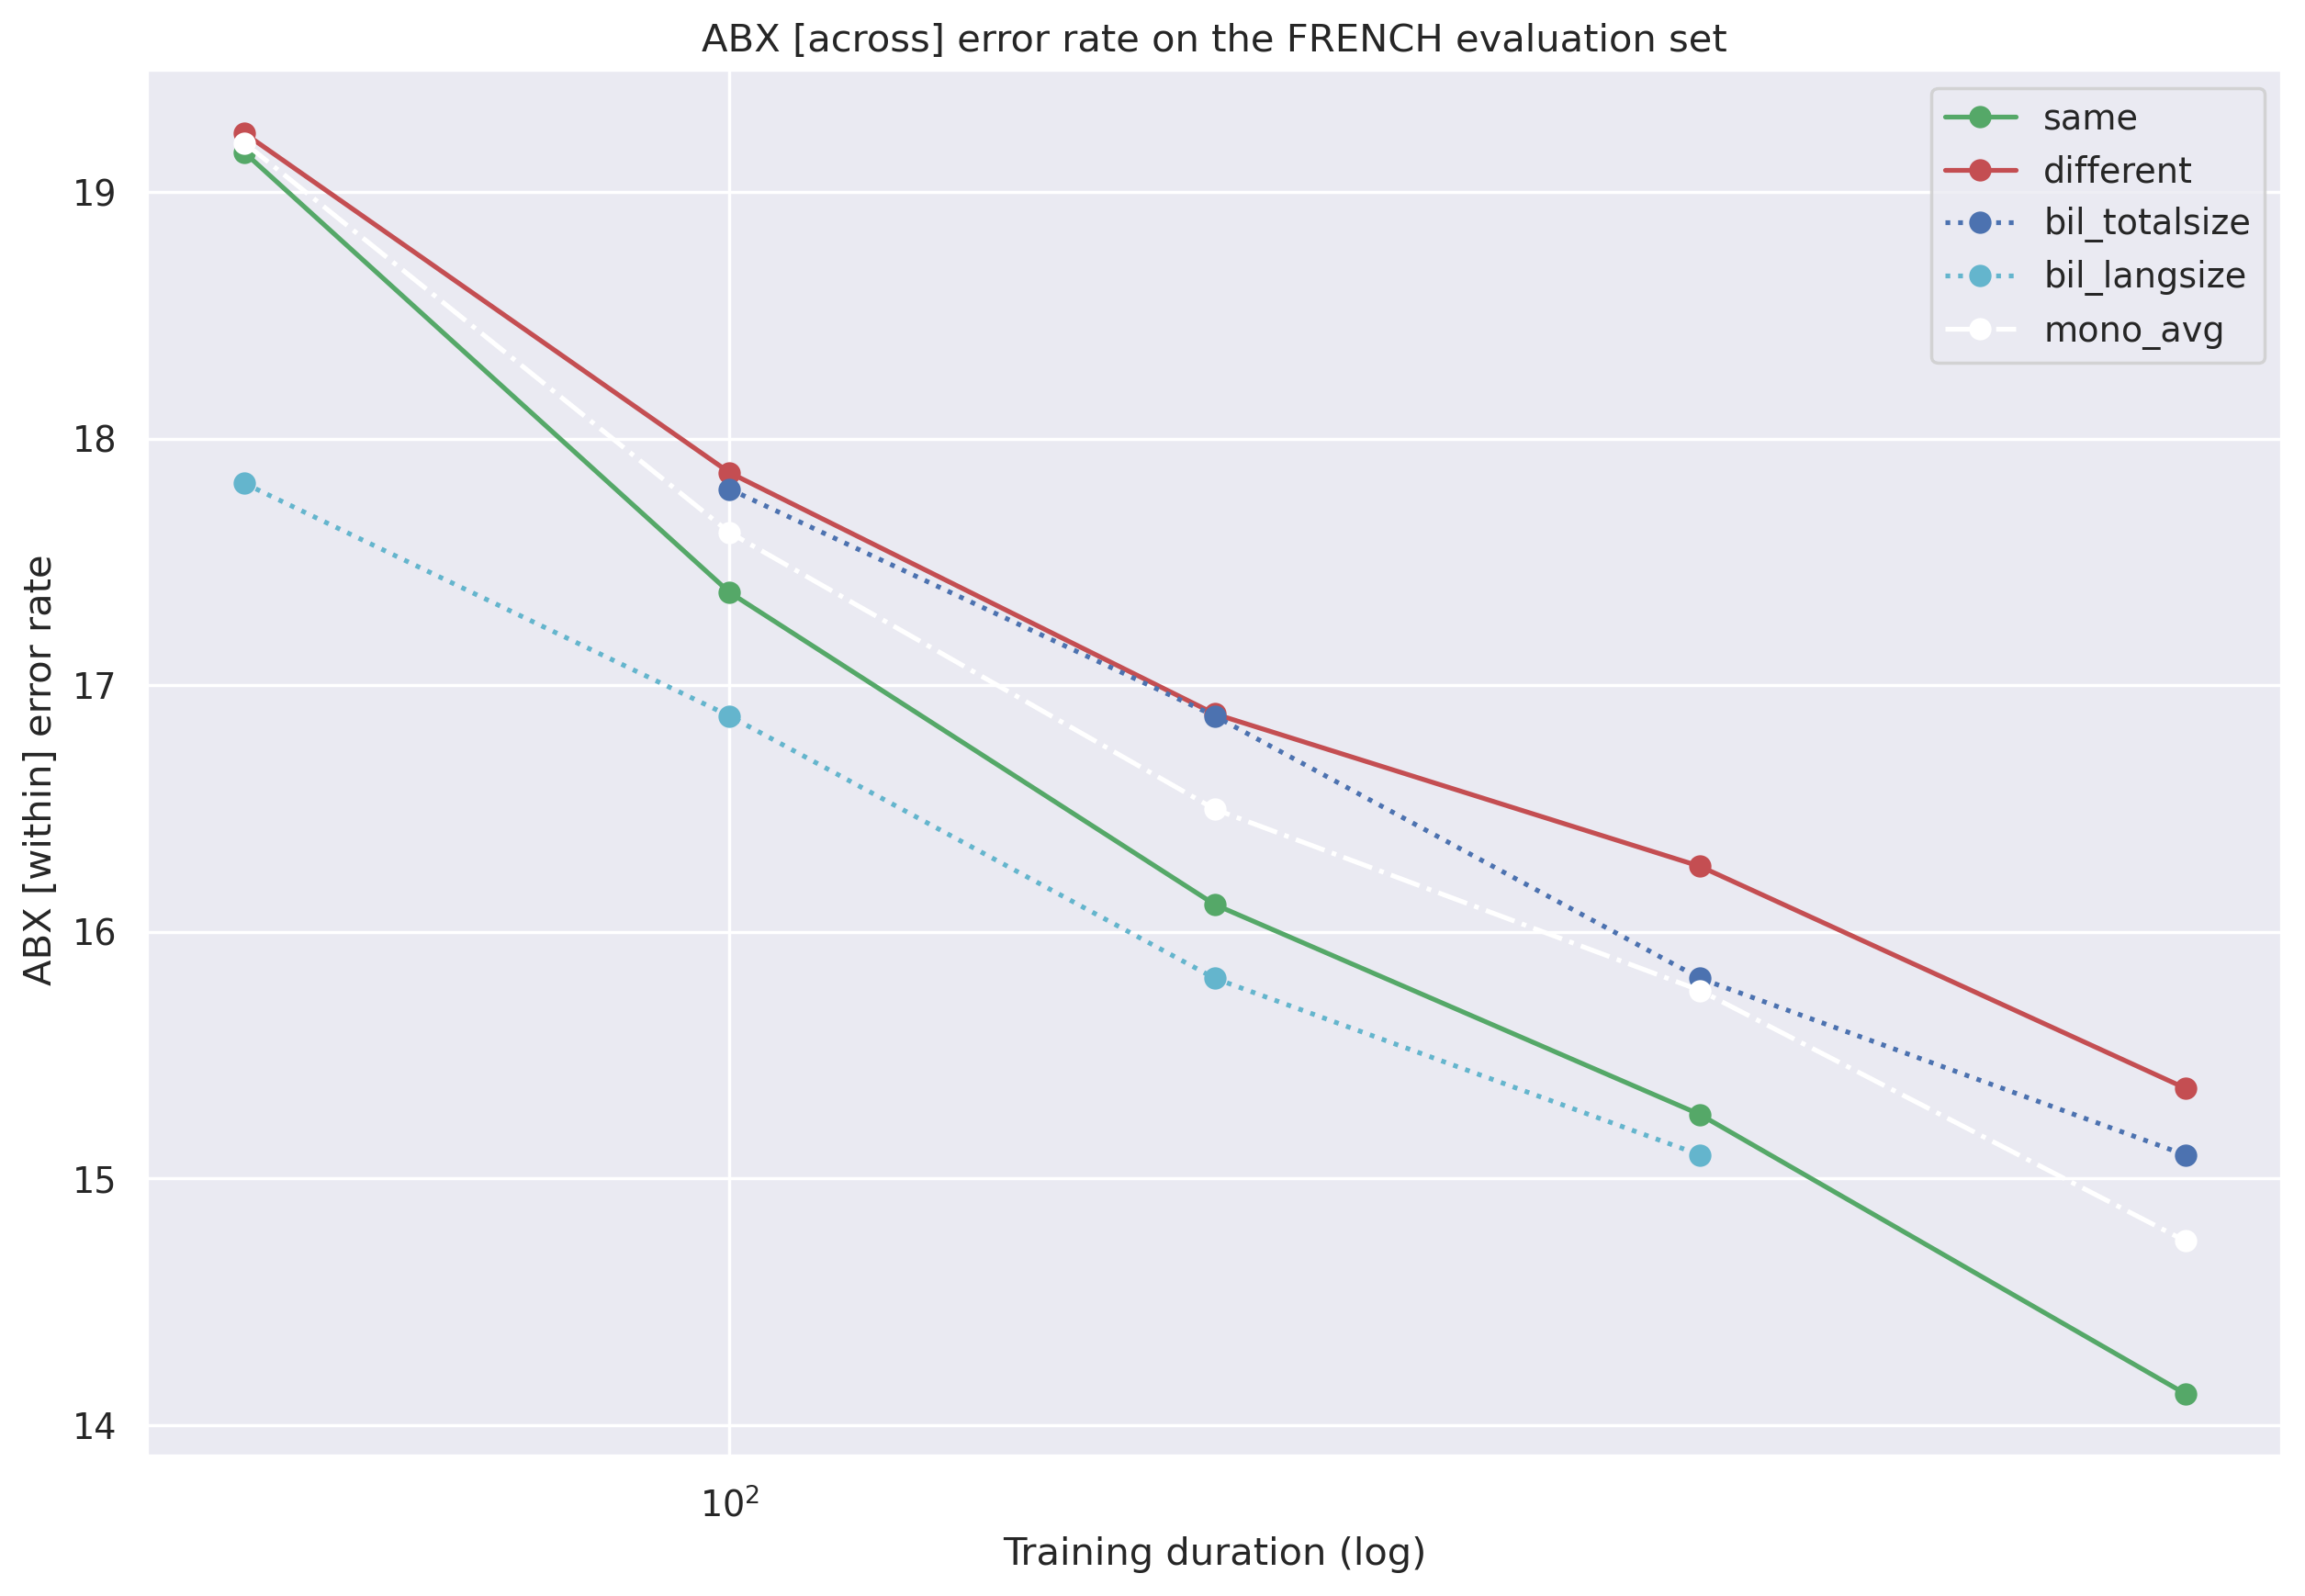

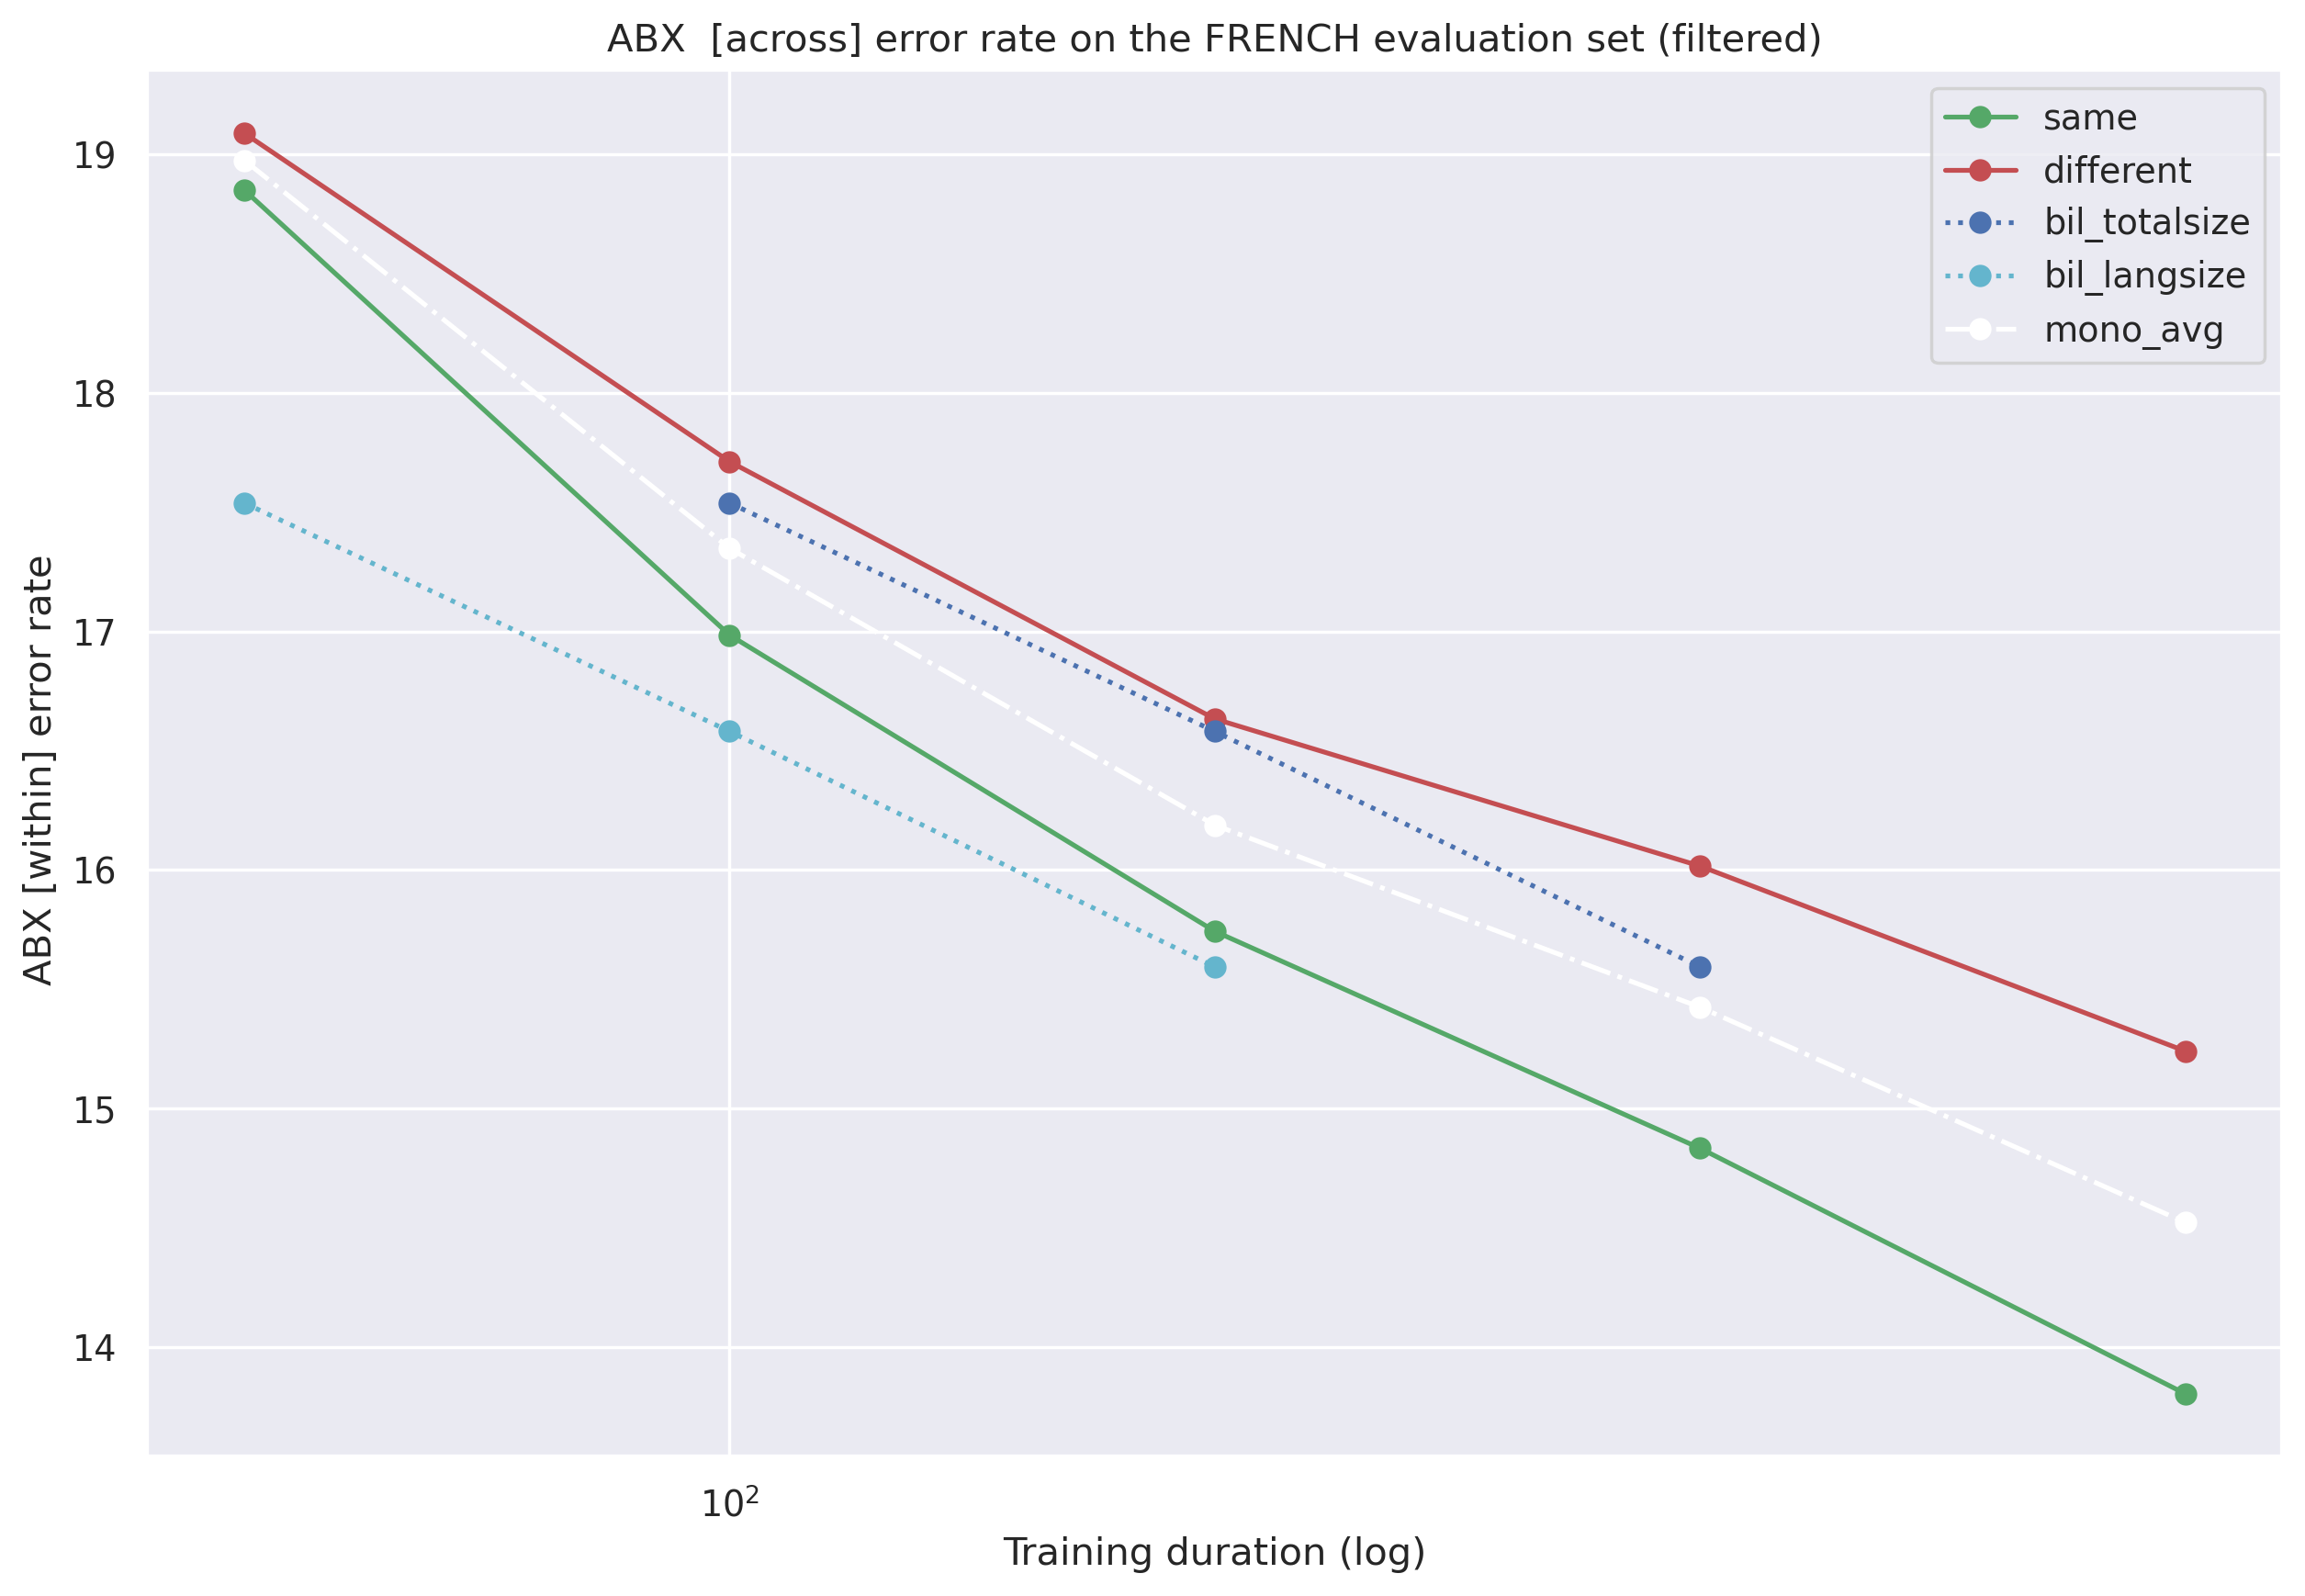

In [66]:
l="french"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, logx=True)
plt.title("ABX [across] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate ")

df_tmp = df_ef_across[df_ef_across["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, logx=True)
plt.title("ABX  [across] error rate on the FRENCH evaluation set (filtered)")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate ")

### D6. Developmental [across] ABX  on the English test set (original and QuickFix) - xLog

Text(0, 0.5, 'ABX [within] error rate ')

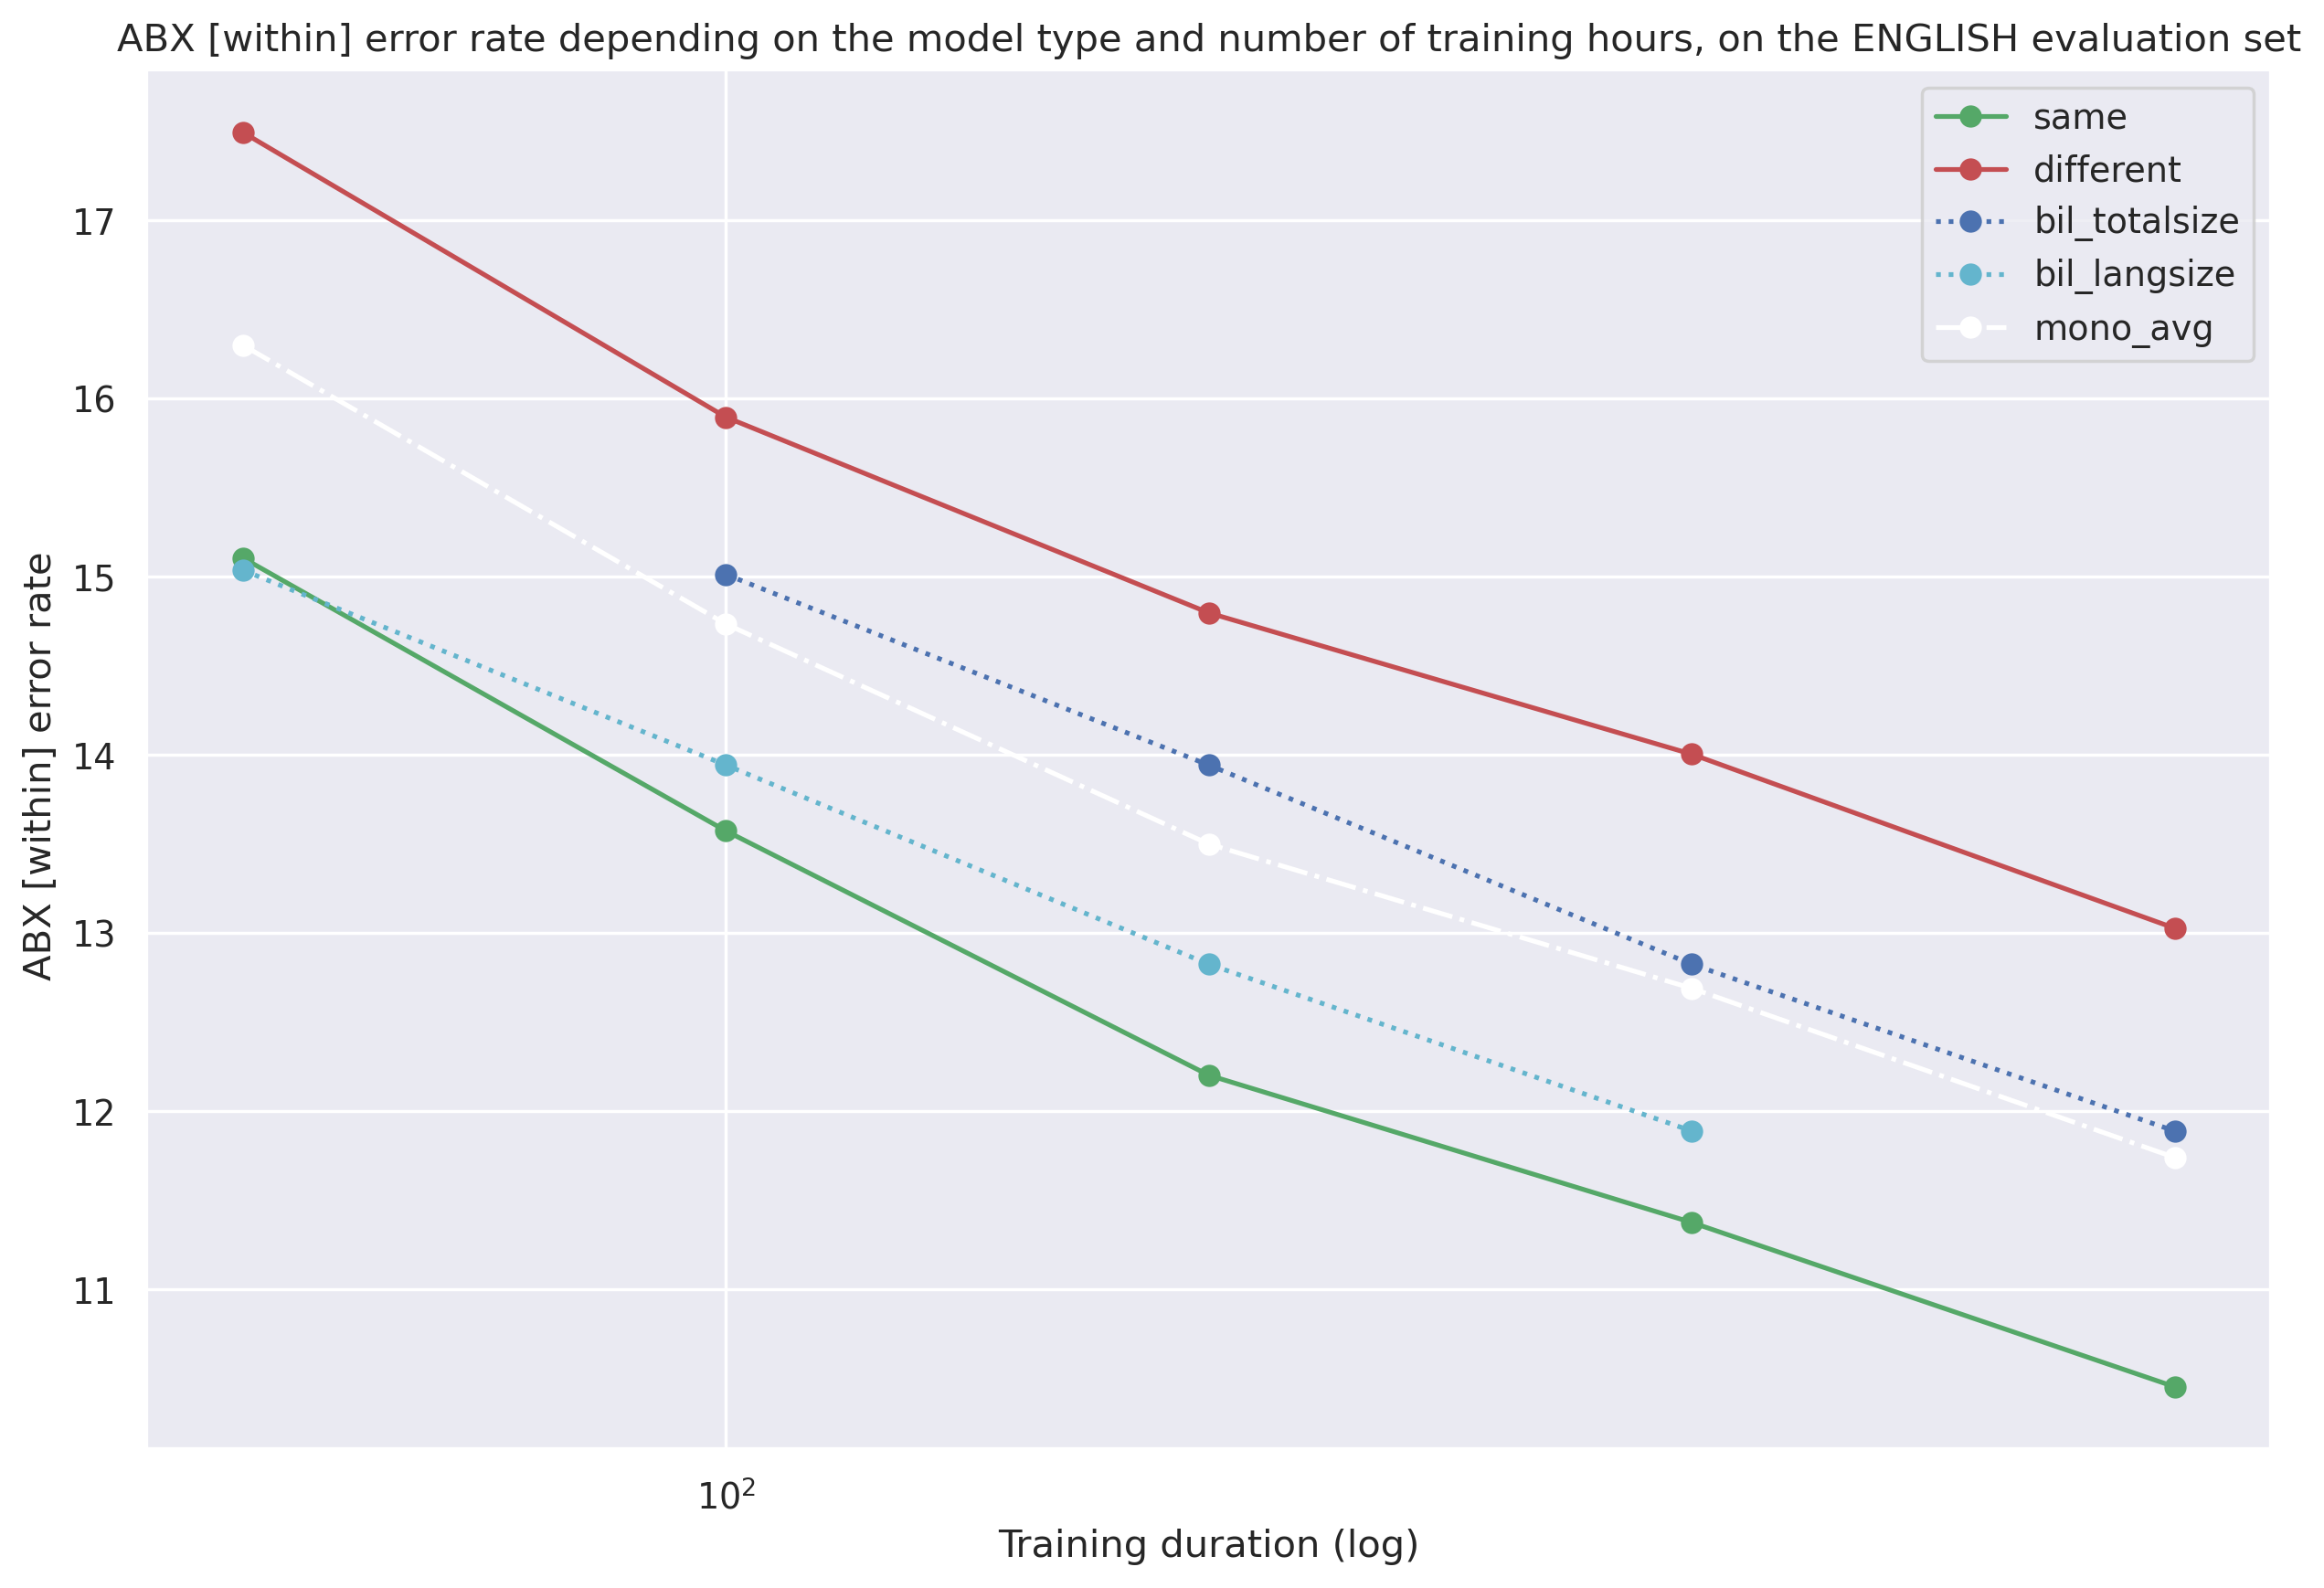

In [67]:
l="english"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, logx=True)
plt.title("ABX [within] error rate depending on the model type and number of training hours, on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate ")

###  Calculating Relative Advantage per data doubling :
Eg There is a **x** improvement when we double the data

In [140]:
l="french"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df["doubling"] = [1, 2, 3, 4, 5]

df

en_model   fr_model  bil_totalsize_A  bil_totalsize_B       same  \
size                                                                      
50    12.150031  12.556733              NaN              NaN  12.556733   
100   11.603361  11.742047        11.972209        11.883759  11.742047   
200   11.065071  11.072798        11.495047        11.465693  11.072798   
400   10.772316  10.793688        11.036441        11.017865  10.793688   
800   10.146320  10.053133        10.621505        10.530125  10.053133   

      different  bil_langsize  bil_totalsize   mono_avg  doubling  
size                                                               
50    12.150031     11.928686            NaN  12.353382         1  
100   11.603361     11.480370      11.922402  11.672704         2  
200   11.065071     11.027153      11.480370  11.068935         3  
400   10.772316     10.575815      11.027153  10.783002         4  
800   10.146320           NaN      10.575815  10.099727         5

In [149]:
l="french"
df = df_ef_within[df_ef_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.8569937825283045
different -4.412478262172598
bil_langsize -4.3357281545696384
bil_totalsize -4.3357281545696384


In [150]:
l="french"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.392328420869466
different -4.39883186553968
bil_langsize -3.9330099581528017
bil_totalsize -3.916099862500156


In [151]:
l="english"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -7.597177968449518
different -6.296222320468983
bil_langsize -6.43445216880439
bil_totalsize -6.389999314876834
